<a href="https://colab.research.google.com/github/emmetorior/CN7030-/blob/main/Copy_of_ASSN_CN7050_FINAL7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install findspark
!pip install --upgrade pyspark pyarrow pandas
from google.colab import drive

In [ ]:
#d=[]
#while(1):
#  d.append('1')

In [ ]:
import pandas as pd
import pyspark
import pyarrow as pa
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import col, explode, split, array, lit
from pyspark.ml.feature import CountVectorizer, IDF
import ast


Check Files Exist and Are Readable.

In [ ]:
import os
parquet_validation_file = "/content/drive/MyDrive/Colab Notebooks/CN7050/validation-00000-of-00001.parquet"
print(os.path.exists(parquet_validation_file))

parquet_test_file = "/content/drive/MyDrive/Colab Notebooks/CN7050/test-00000-of-00001.parquet"
print(os.path.exists(parquet_test_file))

parquet_train_file = "/content/drive/MyDrive/Colab Notebooks/CN7050/train-00000-of-00001.parquet"
print(os.path.exists(parquet_train_file))

True
True
True


Load files into Spark. We have a train, test and validation file. Each one is loaded in from the parquet downloaded from huggingface.co

SET UP A SPARK SESSION AND SET OPTIONS

In [ ]:
spark = SparkSession.Builder().master("local[*]").getOrCreate()
spark.conf.set("spark.sql.parquet.mergeSchema", "false")
spark.conf.set("spark.sql.parquet.binaryAsString", "true")

In [ ]:
dfs_train = spark.read.format("parquet").option("mergeSchema", "false").load(parquet_train_file)
dfs_test = spark.read.format("parquet").option("mergeSchema", "false").load(parquet_test_file)
dfs_validation = spark.read.format("parquet").option("mergeSchema", "false").load(parquet_validation_file)

Check the file contents

In [ ]:
dfs_train.show(5)
dfs_test.show(5)
dfs_validation.show(5)

+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+
|       id|org_index|data_source|        industry|                text|              labels|         label_codes|
+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+
|301972057|      600| Trustpilot|Price Comparison|My experience is ...|[[Staff support: ...|['staff-support.a...|
|301982453|      514|Google Play|         Banking|I love it so hand...|[[Company brand: ...|['company-brand.g...|
|301980653|      369|Google Play|    Ride Hailing|  Sometimes it takes|[[Company brand: ...|['company-brand.g...|
|301979991|      727|Apple Store|         Fashion|This is the worst...|[[Logistics rides...|['logistics-rides...|
|301984330|      549|Google Play|  Travel Booking|So easy & loads o...|[[Company brand: ...|['company-brand.g...|
+---------+---------+-----------+----------------+--------------------+-----------------

File was not loading. Implemented a Workaround by converting the pandas version

1.   List item
2.   List item

of the parquet file converted to CSV and read into spark to create a spark dataframe. Maybe delete this segment later as problem was resolved.  

*italicized text*

In [ ]:
print("Training file row count:", dfs_train.count())
dfs_train.printSchema()
print("Testing file row count:", dfs_test.count())
dfs_test.printSchema()
print("Validation file row count:", dfs_validation.count())
dfs_validation.printSchema()

Training file row count: 7930
root
 |-- id: long (nullable = true)
 |-- org_index: long (nullable = true)
 |-- data_source: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- text: string (nullable = true)
 |-- labels: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- label_codes: string (nullable = true)

Testing file row count: 1587
root
 |-- id: long (nullable = true)
 |-- org_index: long (nullable = true)
 |-- data_source: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- text: string (nullable = true)
 |-- labels: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- label_codes: string (nullable = true)

Validation file row count: 1057
root
 |-- id: long (nullable = true)
 |-- org_index: long (nullable = true)
 |-- data_source: string (nullable = true)
 |-- industry: string (nullable = true

In [ ]:
#findspark.init()
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col, sum


In [ ]:
null_counts_train = dfs_train.select([sum(col(c).isNull().cast("int")).alias(c) for c in dfs_train.columns])
null_counts_train.show()
null_counts_test = dfs_test.select([sum(col(c).isNull().cast("int")).alias(c) for c in dfs_test.columns])
null_counts_test.show()
null_counts_validation = dfs_validation.select([sum(col(c).isNull().cast("int")).alias(c) for c in dfs_validation.columns])
null_counts_validation.show()

+---+---------+-----------+--------+----+------+-----------+
| id|org_index|data_source|industry|text|labels|label_codes|
+---+---------+-----------+--------+----+------+-----------+
|  0|        0|          0|       0|   0|     0|          0|
+---+---------+-----------+--------+----+------+-----------+

+---+---------+-----------+--------+----+------+-----------+
| id|org_index|data_source|industry|text|labels|label_codes|
+---+---------+-----------+--------+----+------+-----------+
|  0|        0|          0|       0|   0|     0|          0|
+---+---------+-----------+--------+----+------+-----------+

+---+---------+-----------+--------+----+------+-----------+
| id|org_index|data_source|industry|text|labels|label_codes|
+---+---------+-----------+--------+----+------+-----------+
|  0|        0|          0|       0|   0|     0|          0|
+---+---------+-----------+--------+----+------+-----------+



In [ ]:
# ACD
from pyspark.sql.functions import col, array_contains, lit, explode, udf
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.sql.types import ArrayType, StringType
import ast

INSERT FULL ABSA

Part 1

In [ ]:
#from pyspark.sql.functions import udf
#from numpy import array
#
#@udf(returnType=ArrayType(StringType()))
#def extract_sentiment_values(label_codes):
#    if isinstance(label_codes, str):
#        codes = ast.literal_eval(label_codes)
#        # Extract the part after the dot which represents the sentiment value
#        return [code.rsplit('.', 1)[1] for code in codes]
#    return []#
#
## We'll also need to extract the category names to know which sentiment belongs to which category
#@udf(returnType=ArrayType(StringType()))
#def extract_categories_and_sentiments(label_codes):
#    if isinstance(label_codes, str):
#        codes = ast.literal_eval(label_codes)
#        # Return tuples of (category, sentiment)
#        return [(code.rsplit('.', 1)[0], code.rsplit('.', 1)[1]) for code in codes]
#    return []#
#
## Create a UDF to check if this category has a specific sentiment
#@udf(returnType="integer")
#def has_sentiment(category_sentiments, target_category, target_sentiment):
#    if category_sentiments is None:
#        return 0
#    for cat, sent in category_sentiments:
#        if cat == target_category and sent == target_sentiment:
#            return 1
#    return 0

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
import ast

# Extract sentiment values
@udf(returnType=ArrayType(StringType()))
def extract_sentiment_values(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [code.rsplit('.', 1)[1] for code in codes]
    return []

# Extract categories and sentiments as structs
@udf(returnType=ArrayType(StructType([
    StructField("category", StringType(), True),
    StructField("sentiment", StringType(), True)
])))
def extract_categories_and_sentiments(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [{"category": code.rsplit('.', 1)[0], "sentiment": code.rsplit('.', 1)[1]} for code in codes]
    return []

# Check if a category has a specific sentiment (using structs)
@udf(returnType="integer")
def has_sentiment(category_sentiments, target_category, target_sentiment):
    if category_sentiments is None:
        return 0
    for item in category_sentiments:
        if item["category"] == target_category and item["sentiment"] == target_sentiment:
            return 1
    return 0

Part 2

Set Up the Data extracting the categories and the sentiments from the Label_codes

In [ ]:
# Step 1: Extract categories and their sentiment values
dfs_train_with_sentiment = dfs_train.withColumn("category_sentiments", extract_categories_and_sentiments(col("label_codes"))).limit(1000)
dfs_test_with_sentiment = dfs_test.withColumn("category_sentiments", extract_categories_and_sentiments(col("label_codes"))).limit(1000)
dfs_validation_with_sentiment = dfs_validation.withColumn("category_sentiments", extract_categories_and_sentiments(col("label_codes"))).limit(1000)

# Step 2: Get all unique categories
all_categories = dfs_train_with_sentiment.select(explode("category_sentiments")).distinct().rdd.flatMap(lambda x: x[0]).collect()
dfs_train_with_sentiment.show(5)
for category in all_categories:
    print(category)


+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+
|       id|org_index|data_source|        industry|                text|              labels|         label_codes| category_sentiments|
+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+
|301972057|      600| Trustpilot|Price Comparison|My experience is ...|[[Staff support: ...|['staff-support.a...|[{staff-support.a...|
|301982453|      514|Google Play|         Banking|I love it so hand...|[[Company brand: ...|['company-brand.g...|[{company-brand.g...|
|301980653|      369|Google Play|    Ride Hailing|  Sometimes it takes|[[Company brand: ...|['company-brand.g...|[{company-brand.g...|
|301979991|      727|Apple Store|         Fashion|This is the worst...|[[Logistics rides...|['logistics-rides...|[{logistics-rides...|
|301984330|      549|Google Play|  Travel Booking|So ea

In [ ]:
# Step 3: For each category, create columns for negative, neutral, and positive sentiment
for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')

    # Create columns for negative (-1), neutral (0), and positive (1) sentiment
    dfs_train_with_sentiment = dfs_train_with_sentiment.withColumn(
        f"{clean_cat}_negative",
        has_sentiment(col("category_sentiments"), lit(category), lit("-1"))
    )
    dfs_train_with_sentiment = dfs_train_with_sentiment.withColumn(
        f"{clean_cat}_neutral",
        has_sentiment(col("category_sentiments"), lit(category), lit("0"))
    )
    dfs_train_with_sentiment = dfs_train_with_sentiment.withColumn(
        f"{clean_cat}_positive",
        has_sentiment(col("category_sentiments"), lit(category), lit("1"))
    )

    # Do the same for test and validation sets
    dfs_test_with_sentiment = dfs_test_with_sentiment.withColumn(
        f"{clean_cat}_negative",
        has_sentiment(col("category_sentiments"), lit(category), lit("-1"))
    )
    dfs_test_with_sentiment = dfs_test_with_sentiment.withColumn(
        f"{clean_cat}_neutral",
        has_sentiment(col("category_sentiments"), lit(category), lit("0"))
    )
    dfs_test_with_sentiment = dfs_test_with_sentiment.withColumn(
        f"{clean_cat}_positive",
        has_sentiment(col("category_sentiments"), lit(category), lit("1"))
    )

    dfs_validation_with_sentiment = dfs_validation_with_sentiment.withColumn(
        f"{clean_cat}_negative",
        has_sentiment(col("category_sentiments"), lit(category), lit("-1"))
    )
    dfs_validation_with_sentiment = dfs_validation_with_sentiment.withColumn(
        f"{clean_cat}_neutral",
        has_sentiment(col("category_sentiments"), lit(category), lit("0"))
    )
    dfs_validation_with_sentiment = dfs_validation_with_sentiment.withColumn(
        f"{clean_cat}_positive",
        has_sentiment(col("category_sentiments"), lit(category), lit("1"))
    )

# Cache dataframes
dfs_train_with_sentiment.cache()
dfs_test_with_sentiment.cache()
dfs_validation_with_sentiment.cache()

DataFrame[id: bigint, org_index: bigint, data_source: string, industry: string, text: string, labels: array<array<string>>, label_codes: string, category_sentiments: array<struct<category:string,sentiment:string>>, staff_support_attitude_of_staff_negative: int, staff_support_attitude_of_staff_neutral: int, staff_support_attitude_of_staff_positive: int, _1_negative: int, _1_neutral: int, _1_positive: int, company_brand_reviews_negative: int, company_brand_reviews_neutral: int, company_brand_reviews_positive: int, company_brand_general_satisfaction_negative: int, company_brand_general_satisfaction_neutral: int, company_brand_general_satisfaction_positive: int, 1_negative: int, 1_neutral: int, 1_positive: int, company_brand_competitor_negative: int, company_brand_competitor_neutral: int, company_brand_competitor_positive: int, logistics_rides_speed_negative: int, logistics_rides_speed_neutral: int, logistics_rides_speed_positive: int, online_experience_app_website_negative: int, online_ex

In [ ]:

# Step 3: For each category, create columns for negative, neutral, and positive sentiment
#for category in all_categories:
#    clean_cat = category.replace('-', '_').replace('.', '_')
#
#    # Create columns for negative (-1), neutral (0), and positive (1) sentiment
#    dfs_train_with_sentiment = dfs_train_with_sentiment.withColumn(
#        f"{clean_cat}_negative",
#        has_sentiment(col("category_sentiments"), lit(category), lit("-1"))
#    )
#    dfs_train_with_sentiment = dfs_train_with_sentiment.withColumn(
#        f"{clean_cat}_neutral",
#        has_sentiment(col("category_sentiments"), lit(category), lit("0"))
#    )
#    dfs_train_with_sentiment = dfs_train_with_sentiment.withColumn(
#        f"{clean_cat}_positive",
#        has_sentiment(col("category_sentiments"), lit(category), lit("1"))
#    )

    # Do the same for test and validation sets
#    dfs_test_with_sentiment = dfs_test_with_sentiment.withColumn(
#        f"{clean_cat}_negative",
#        has_sentiment(col("category_sentiments"), lit(category), lit("-1"))
#    )
#    dfs_test_with_sentiment = dfs_test_with_sentiment.withColumn(
#        f"{clean_cat}_neutral",
#        has_sentiment(col("category_sentiments"), lit(category), lit("0"))
#    )
#    dfs_test_with_sentiment = dfs_test_with_sentiment.withColumn(
#        f"{clean_cat}_positive",
#        has_sentiment(col("category_sentiments"), lit(category), lit("1"))
#    )
#
#    dfs_validation_with_sentiment = dfs_validation_with_sentiment.withColumn(
#        f"{clean_cat}_negative",
#        has_sentiment(col("category_sentiments"), lit(category), lit("-1"))
#    )
#    dfs_validation_with_sentiment = dfs_validation_with_sentiment.withColumn(
#        f"{clean_cat}_neutral",
#        has_sentiment(col("category_sentiments"), lit(category), lit("0"))
#    )
#    dfs_validation_with_sentiment = dfs_validation_with_sentiment.withColumn(
#        f"{clean_cat}_positive",
#        has_sentiment(col("category_sentiments"), lit(category), lit("1"))
#    )

# Cache dataframes
#dfs_train_with_sentiment.cache()
#dfs_test_with_sentiment.cache()
#dfs_validation_with_sentiment.cache()

DataFrame[id: bigint, org_index: bigint, data_source: string, industry: string, text: string, labels: array<array<string>>, label_codes: string, category_sentiments: array<struct<category:string,sentiment:string>>, staff_support_attitude_of_staff_negative: int, staff_support_attitude_of_staff_neutral: int, staff_support_attitude_of_staff_positive: int, _1_negative: int, _1_neutral: int, _1_positive: int, company_brand_reviews_negative: int, company_brand_reviews_neutral: int, company_brand_reviews_positive: int, company_brand_general_satisfaction_negative: int, company_brand_general_satisfaction_neutral: int, company_brand_general_satisfaction_positive: int, 1_negative: int, 1_neutral: int, 1_positive: int, company_brand_competitor_negative: int, company_brand_competitor_neutral: int, company_brand_competitor_positive: int, logistics_rides_speed_negative: int, logistics_rides_speed_neutral: int, logistics_rides_speed_positive: int, online_experience_app_website_negative: int, online_ex

 Part 3


In [ ]:
# Step 4: Text vectorization with TF-IDF (same as before)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=2)

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_with_sentiment)
test_tokenized = tokenizer.transform(dfs_test_with_sentiment)

train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)
idf_model = idf.fit(train_hashed)

train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Step 5: Train sentiment classifiers for each category
from pyspark.ml.classification import LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sentiment_results = {}

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')

    # Create a combined label with 3 classes: -1, 0, 1
    # We'll use a UDF to convert the 3 binary columns into a single multiclass label
    @udf(returnType="double")
    def combine_sentiment(negative, neutral, positive):
        if negative == 1:
            return 0.0  # Class 0 = negative
        elif neutral == 1:
            return 1.0  # Class 1 = neutral
        elif positive == 1:
            return 2.0  # Class 2 = positive
        else:
            return 1.0  # Default to neutral if no sentiment is available

    # Create multiclass label column
    train_data = train_tfidf.withColumn(
        "sentiment_label",
        combine_sentiment(
            col(f"{clean_cat}_negative"),
            col(f"{clean_cat}_neutral"),
            col(f"{clean_cat}_positive")
        )
    )

    test_data = test_tfidf.withColumn(
        "sentiment_label",
        combine_sentiment(
            col(f"{clean_cat}_negative"),
            col(f"{clean_cat}_neutral"),
            col(f"{clean_cat}_positive")
        )
    )

    # Use TF-IDF features for prediction
    assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")
    train_assembled = assembler.transform(train_data).select("features", "sentiment_label")
    test_assembled = assembler.transform(test_data).select("features", "sentiment_label")

    # Train multiclass classifier - LogisticRegression for 3 classes
    lr = LogisticRegression(featuresCol="features", labelCol="sentiment_label", maxIter=20)
    lr_model = lr.fit(train_assembled)

    # Make predictions
    predictions = lr_model.transform(test_assembled)

    # Evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

    sentiment_results[category] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy
    }

    print(f"Category: {category}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")

Category: staff-support.attitude-of-staff, F1: 0.8574, Precision: 0.8768, Recall: 0.8430, Accuracy: 0.8430
Category: -1, F1: 1.0000, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Category: company-brand.reviews, F1: 0.9531, Precision: 0.9669, Recall: 0.9410, Accuracy: 0.9410
Category: -1, F1: 1.0000, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Category: company-brand.general-satisfaction, F1: 0.6184, Precision: 0.6283, Recall: 0.6110, Accuracy: 0.6110
Category: -1, F1: 1.0000, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Category: company-brand.general-satisfaction, F1: 0.6184, Precision: 0.6283, Recall: 0.6110, Accuracy: 0.6110
Category: 1, F1: 1.0000, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Category: company-brand.competitor, F1: 0.8551, Precision: 0.8976, Recall: 0.8240, Accuracy: 0.8240
Category: 1, F1: 1.0000, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000
Category: logistics-rides.speed, F1: 0.7936, Precision: 0.8458, Recall: 0.7530, Accuracy

Deep learning model for sentiment analysis:

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.7770 - loss: 0.7021 - val_accuracy: 0.8850 - val_loss: 0.4264
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8541 - loss: 0.5023 - val_accuracy: 0.8850 - val_loss: 0.4043
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8536 - loss: 0.4558 - val_accuracy: 0.8860 - val_loss: 0.3703
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9001 - loss: 0.3532 - val_accuracy: 0.8950 - val_loss: 0.3457
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9323 - loss: 0.2474 - val_accuracy: 0.9240 - val_loss: 0.2956
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9544 - loss: 0.1335 - val_accuracy: 0.9000 - val_loss: 0.3635
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9683 - loss: 0.1018 - val_accuracy: 0.9020 - val_loss: 0.3912
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9759 - loss: 0.0648 - val_accuracy: 0.8880 - val_loss: 0

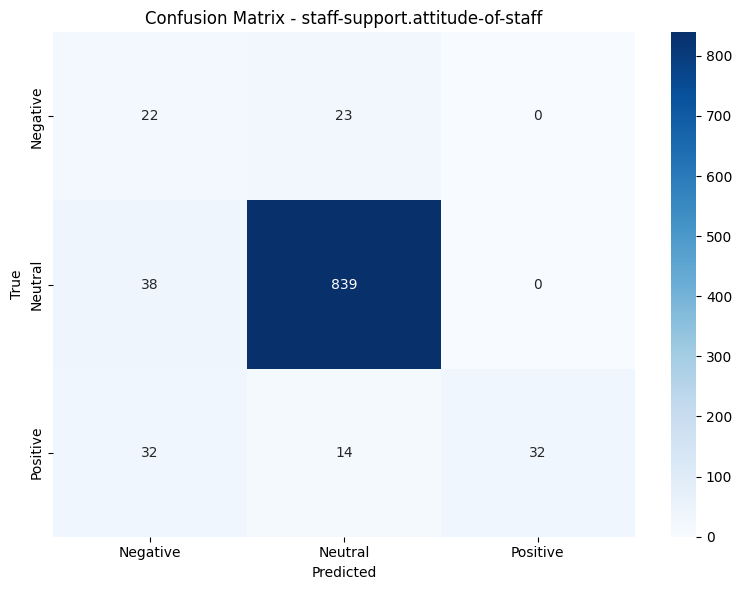

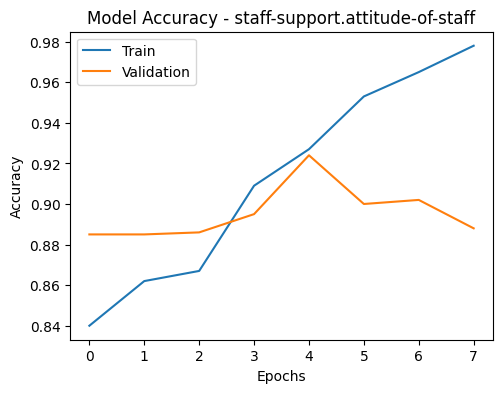

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.8672 - loss: 0.5367 - val_accuracy: 1.0000 - val_loss: 7.2749e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 4.8604e-05 - val_accuracy: 1.0000 - val_loss: 2.0175e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 1.0000 - loss: 1.1441e-05 - val_accuracy: 1.0000 - val_loss: 1.6913e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 4.8069e-06 - val_accuracy: 1.0000 - val_loss: 1.5299e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.8740e-06 - val_accuracy: 1.0000 - val_loss: 1.3990e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.5078e-06 - val_accuracy: 1.0000 - val_loss: 1.2303e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 2.0052e-06 - val_accuracy: 1.0000 - val_loss: 1.1292e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


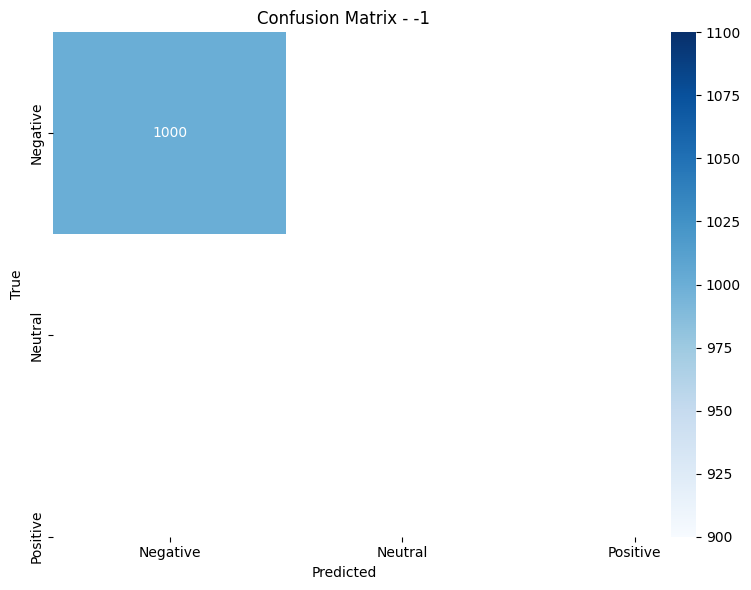

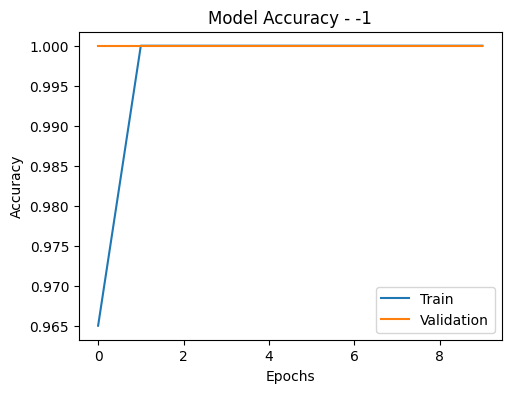

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9289 - loss: 0.5028 - val_accuracy: 0.9790 - val_loss: 0.1143
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9702 - loss: 0.1519 - val_accuracy: 0.9790 - val_loss: 0.1139
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9699 - loss: 0.1633 - val_accuracy: 0.9790 - val_loss: 0.1314
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9730 - loss: 0.1418 - val_accuracy: 0.9790 - val_loss: 0.1275
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9686 - loss: 0.1503 - val_accuracy: 0.9790 - val_loss: 0.1197
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: company-brand.reviews, Accuracy: 0.9760, F1 (weighted): 0.9641
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


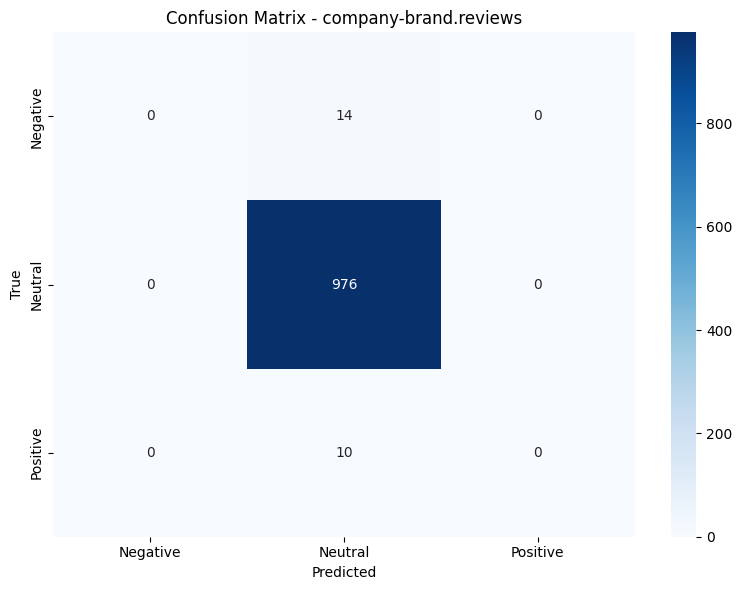

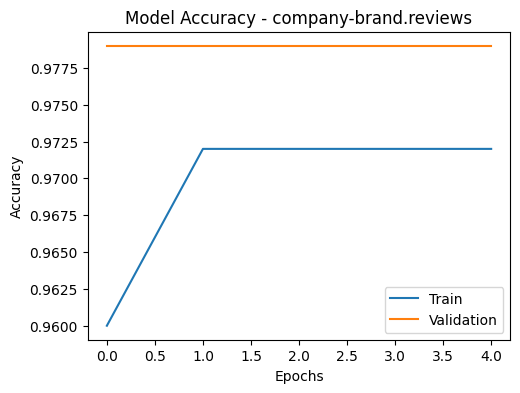

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9923 - loss: 0.3548 - val_accuracy: 1.0000 - val_loss: 5.3991e-06
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 2.0958e-06 - val_accuracy: 1.0000 - val_loss: 1.8522e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.1253e-07 - val_accuracy: 1.0000 - val_loss: 1.7116e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 1.0000 - loss: 4.9681e-07 - val_accuracy: 1.0000 - val_loss: 1.6642e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 6.4237e-07 - val_accuracy: 1.0000 - val_loss: 1.6177e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 1.0000 - loss: 4.0732e-07 - val_accuracy: 1.0000 - val_loss: 1.5699e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 1.0000 - loss: 4.9750e-07 - val_accuracy: 1.0000 - val_loss: 1.5158e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


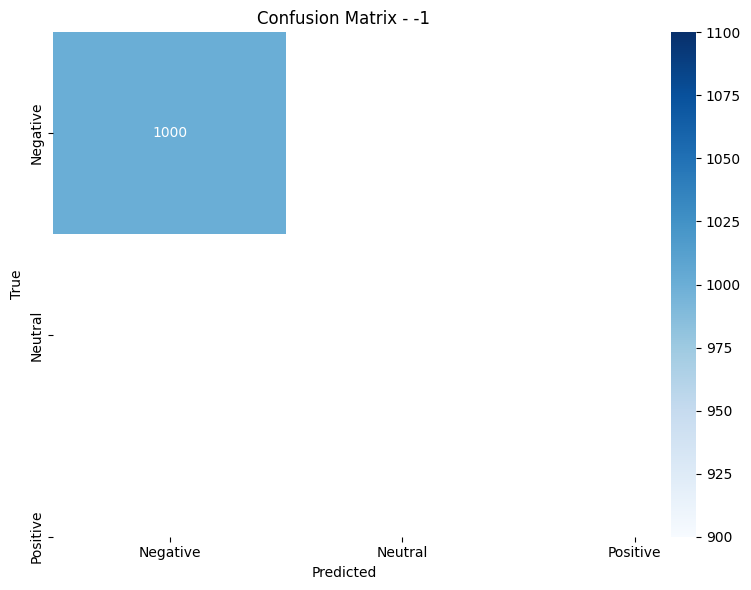

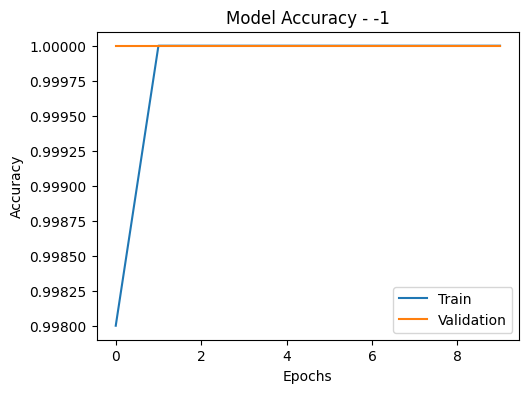

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.6110 - loss: 0.9371 - val_accuracy: 0.6240 - val_loss: 0.8431
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6225 - loss: 0.8610 - val_accuracy: 0.6240 - val_loss: 0.8307
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6433 - loss: 0.7805 - val_accuracy: 0.6240 - val_loss: 0.8020
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7004 - loss: 0.6961 - val_accuracy: 0.6380 - val_loss: 0.7745
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7889 - loss: 0.5139 - val_accuracy: 0.6420 - val_loss: 0.8749
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.8835 - loss: 0.3210 - val_accuracy: 0.6500 - val_loss: 0.9637
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9185 - loss: 0.1950 - val_accuracy: 0.6390 - val_loss: 1.1220
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Category: company-brand.general-satisfaction, Accuracy: 0.6480, F1 (weighted): 0

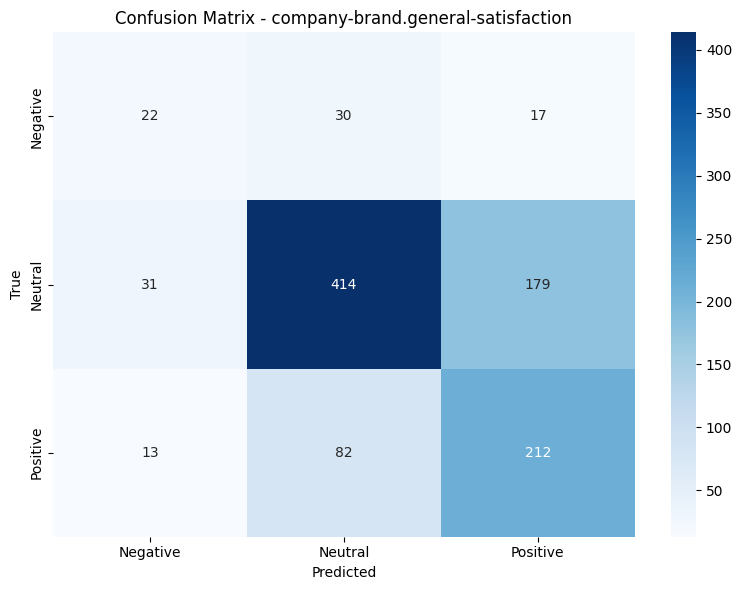

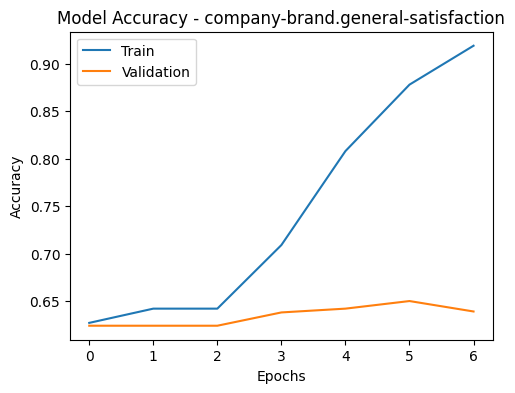

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9070 - loss: 0.4402 - val_accuracy: 1.0000 - val_loss: 3.8000e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 6.2648e-06 - val_accuracy: 1.0000 - val_loss: 1.2655e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 1.0000 - loss: 4.9241e-06 - val_accuracy: 1.0000 - val_loss: 1.0796e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 3.9800e-06 - val_accuracy: 1.0000 - val_loss: 9.4626e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 1.0000 - loss: 1.0683e-06 - val_accuracy: 1.0000 - val_loss: 8.5600e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 1.0000 - loss: 1.7584e-06 - val_accuracy: 1.0000 - val_loss: 7.8653e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.7911e-07 - val_accuracy: 1.0000 - val_loss: 7.4105e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


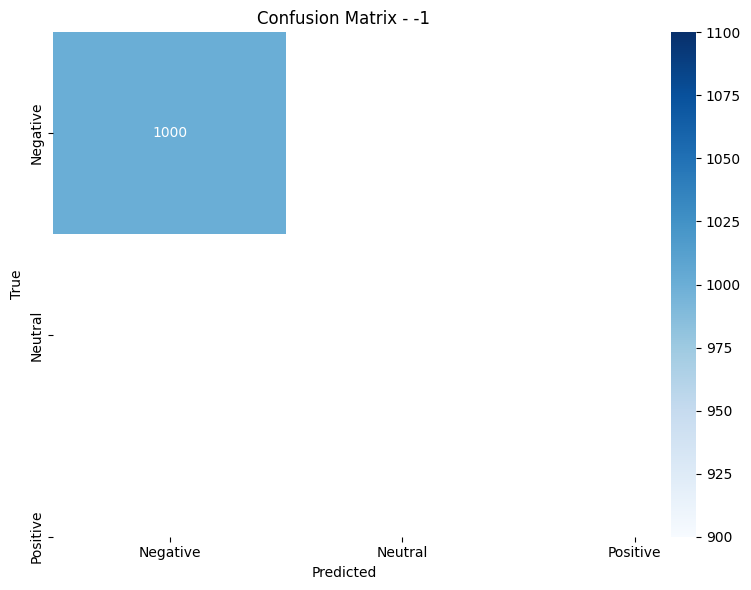

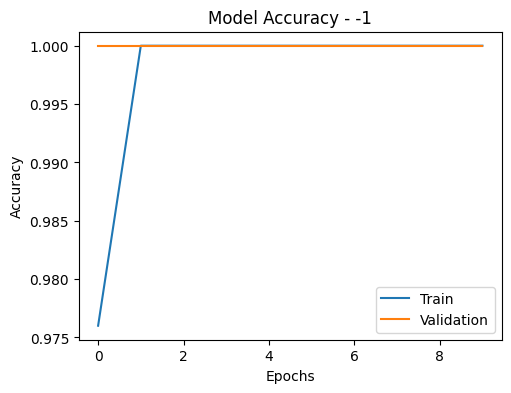

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5779 - loss: 0.9336 - val_accuracy: 0.6240 - val_loss: 0.8447
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6544 - loss: 0.8372 - val_accuracy: 0.6240 - val_loss: 0.8055
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6399 - loss: 0.7772 - val_accuracy: 0.6200 - val_loss: 0.7682
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6975 - loss: 0.6555 - val_accuracy: 0.6110 - val_loss: 0.8060
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.8180 - loss: 0.4842 - val_accuracy: 0.6460 - val_loss: 0.8201
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8684 - loss: 0.3241 - val_accuracy: 0.6310 - val_loss: 0.9795
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Category: company-brand.general-satisfaction, Accuracy: 0.6390, F1 (weighted): 0.6348
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


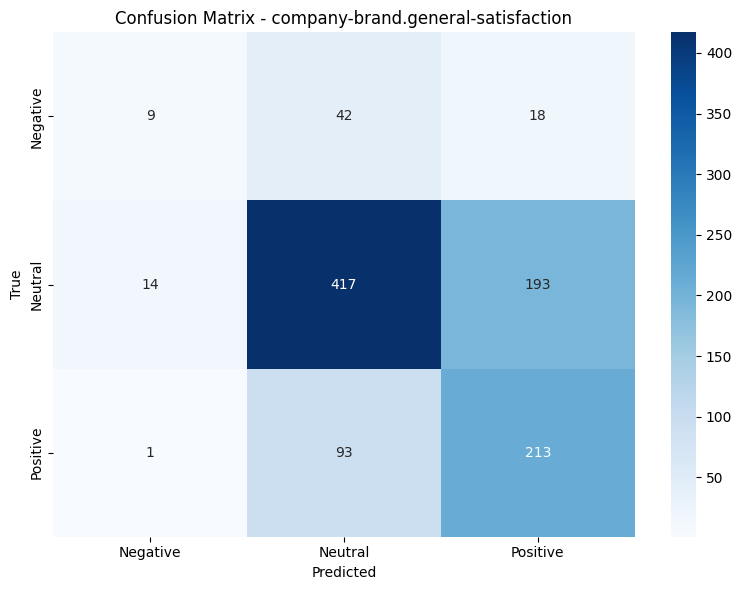

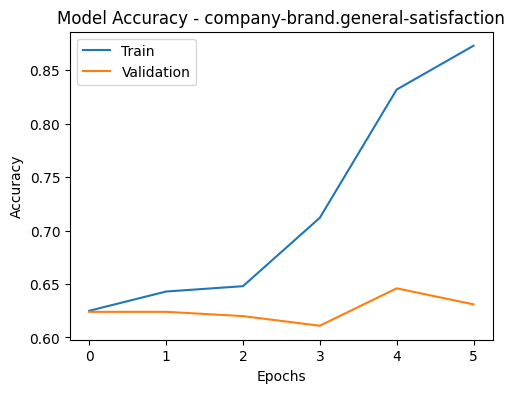

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.8731 - loss: 0.4757 - val_accuracy: 1.0000 - val_loss: 5.2759e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 1.7161e-05 - val_accuracy: 1.0000 - val_loss: 1.7962e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 1.0000 - loss: 9.6856e-06 - val_accuracy: 1.0000 - val_loss: 1.5401e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 8.1750e-06 - val_accuracy: 1.0000 - val_loss: 1.4222e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 3.7053e-06 - val_accuracy: 1.0000 - val_loss: 1.3463e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 1.0000 - loss: 3.3180e-06 - val_accuracy: 1.0000 - val_loss: 1.2801e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.0000 - loss: 7.3814e-06 - val_accuracy: 1.0000 - val_loss: 1.1456e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 1.0000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


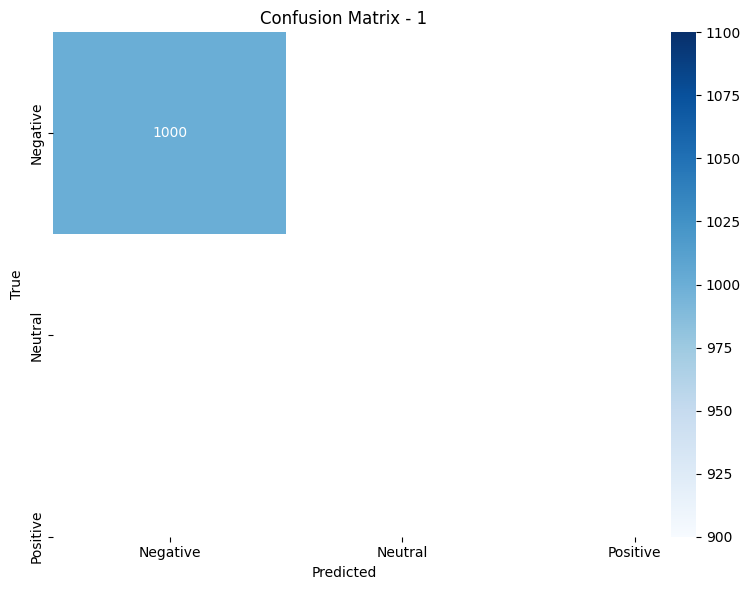

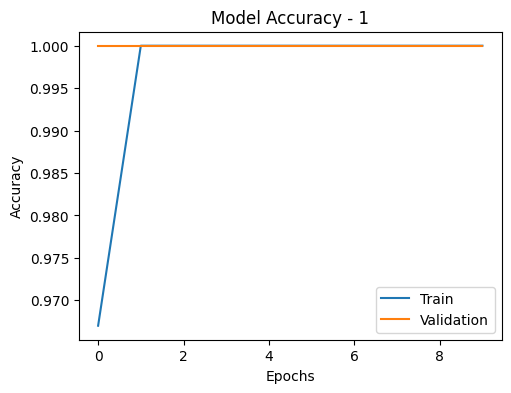

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8420 - loss: 0.6192 - val_accuracy: 0.9180 - val_loss: 0.3237
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9226 - loss: 0.3213 - val_accuracy: 0.9180 - val_loss: 0.3288
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9223 - loss: 0.3124 - val_accuracy: 0.9180 - val_loss: 0.3235
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9295 - loss: 0.2859 - val_accuracy: 0.9180 - val_loss: 0.3278
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9345 - loss: 0.2331 - val_accuracy: 0.9180 - val_loss: 0.3129
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9348 - loss: 0.2065 - val_accuracy: 0.9180 - val_loss: 0.3373
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9260 - loss: 0.1699 - val_accuracy: 0.9170 - val_loss: 0.4233
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9622 - loss: 0.1152 - val_accuracy: 0.9310 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: company-brand.competitor, Accuracy: 0.9280, F1 (weighted): 0.9057
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


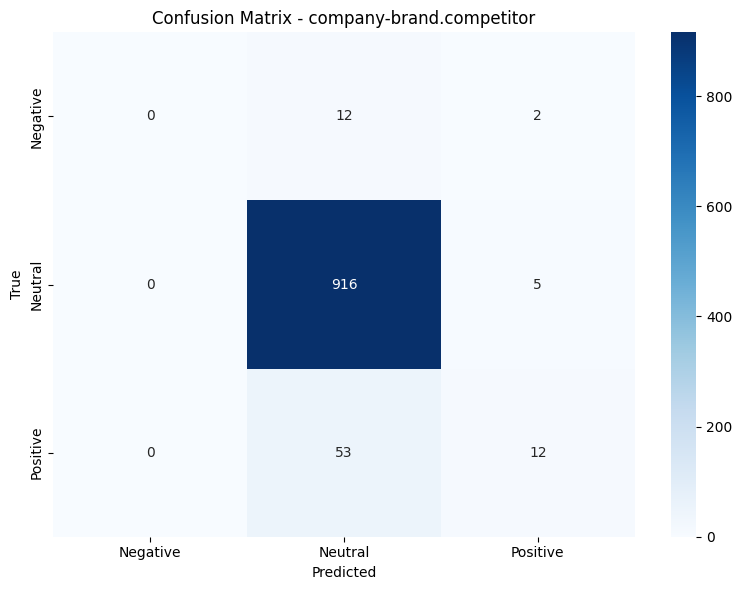

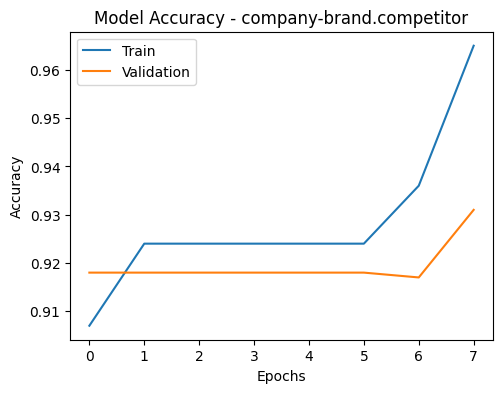

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9496 - loss: 0.4221 - val_accuracy: 1.0000 - val_loss: 8.1781e-06
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 1.2806e-06 - val_accuracy: 1.0000 - val_loss: 2.4985e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 1.0000 - loss: 7.9239e-07 - val_accuracy: 1.0000 - val_loss: 2.3208e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.0190e-06 - val_accuracy: 1.0000 - val_loss: 2.2735e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 3.6091e-07 - val_accuracy: 1.0000 - val_loss: 2.2442e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 2.1403e-06 - val_accuracy: 1.0000 - val_loss: 2.1592e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 1.0000 - loss: 2.0080e-06 - val_accuracy: 1.0000 - val_loss: 2.0485e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


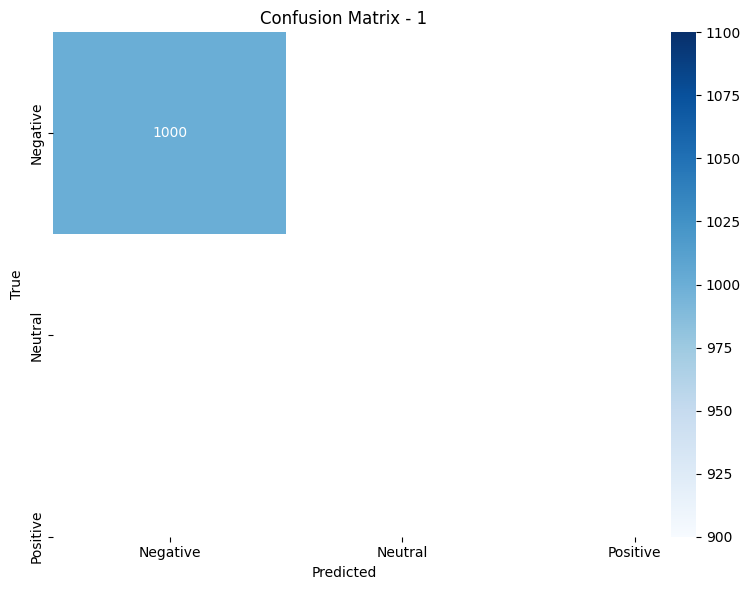

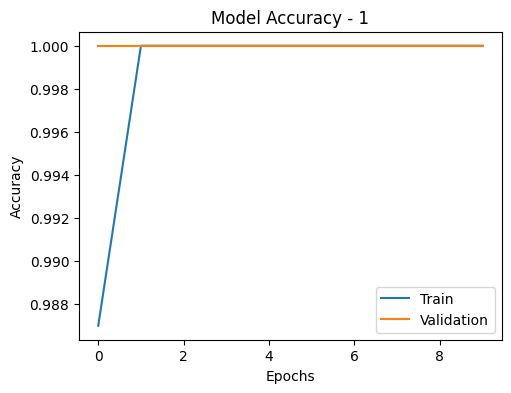

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.7526 - loss: 0.7575 - val_accuracy: 0.8910 - val_loss: 0.4075
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.8562 - loss: 0.5224 - val_accuracy: 0.8910 - val_loss: 0.4051
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8581 - loss: 0.4846 - val_accuracy: 0.8910 - val_loss: 0.3975
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8517 - loss: 0.4507 - val_accuracy: 0.8910 - val_loss: 0.4191
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8796 - loss: 0.3204 - val_accuracy: 0.8910 - val_loss: 0.4649
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8556 - loss: 0.3121 - val_accuracy: 0.8910 - val_loss: 0.4903
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: logistics-rides.speed, Accuracy: 0.8840, F1 (weighted): 0.8296
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


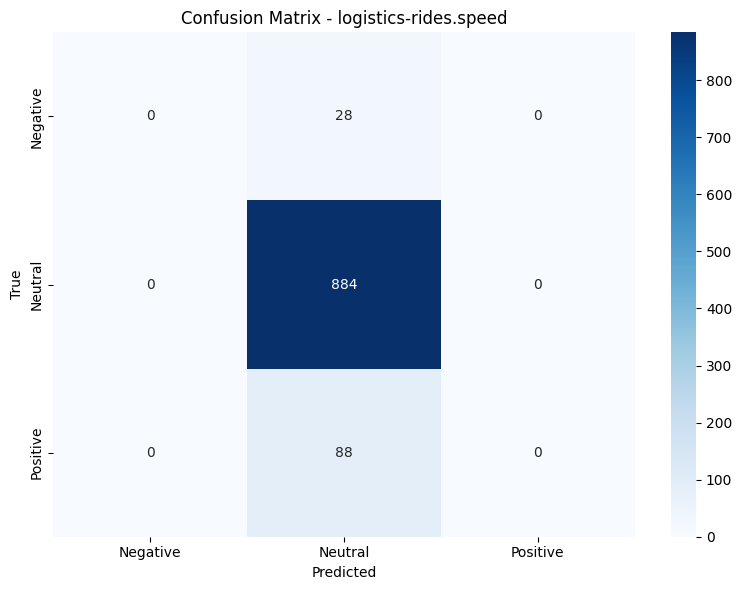

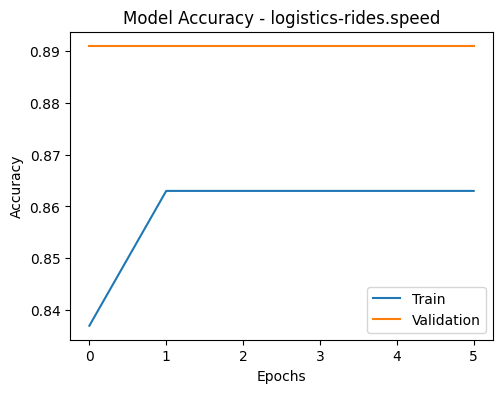

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8876 - loss: 0.4427 - val_accuracy: 1.0000 - val_loss: 9.7527e-06
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 1.0000 - loss: 4.0569e-06 - val_accuracy: 1.0000 - val_loss: 3.0330e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 2.9773e-06 - val_accuracy: 1.0000 - val_loss: 2.7652e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 1.5087e-06 - val_accuracy: 1.0000 - val_loss: 2.6768e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 1.0000 - loss: 2.9489e-06 - val_accuracy: 1.0000 - val_loss: 2.5886e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 1.0000 - loss: 5.4206e-07 - val_accuracy: 1.0000 - val_loss: 2.5349e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 1.2584e-06 - val_accuracy: 1.0000 - val_loss: 2.4815e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


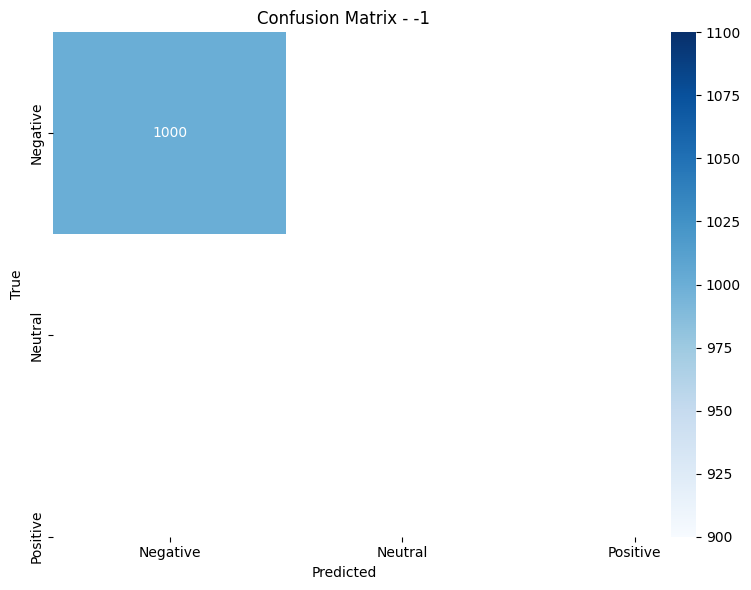

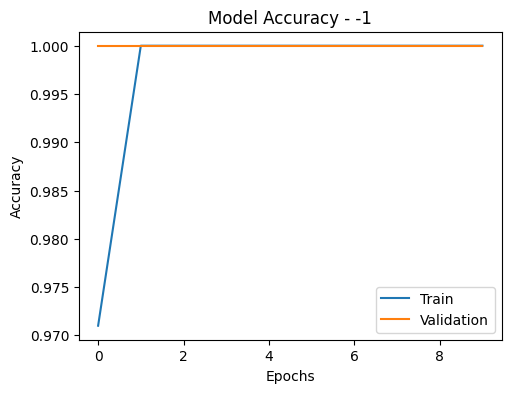

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.5374 - loss: 1.0248 - val_accuracy: 0.5940 - val_loss: 0.9470
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5777 - loss: 0.9450 - val_accuracy: 0.5940 - val_loss: 0.9333
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5681 - loss: 0.9108 - val_accuracy: 0.5910 - val_loss: 0.9126
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6321 - loss: 0.7617 - val_accuracy: 0.6430 - val_loss: 0.7996
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8187 - loss: 0.4174 - val_accuracy: 0.6900 - val_loss: 0.8170
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9148 - loss: 0.2114 - val_accuracy: 0.6830 - val_loss: 1.1365
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9450 - loss: 0.1407 - val_accuracy: 0.6890 - val_loss: 1.2421
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Category: online-experience.app-website, Accuracy: 0.6830, F1 (weighted): 0.6519

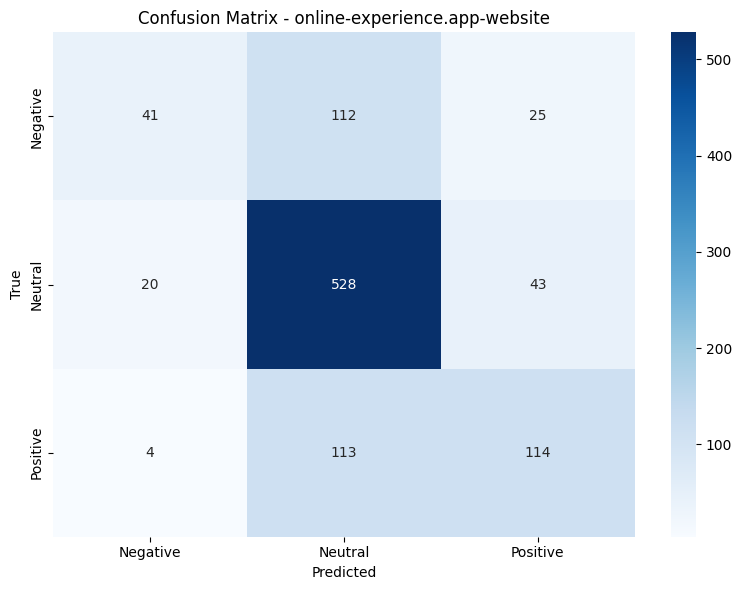

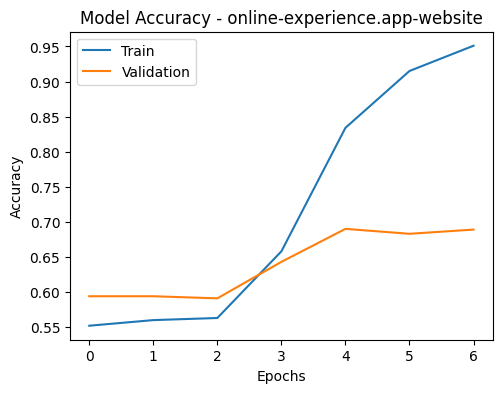

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.8760 - loss: 0.4460 - val_accuracy: 1.0000 - val_loss: 6.7027e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 1.0000 - loss: 2.7171e-05 - val_accuracy: 1.0000 - val_loss: 2.2096e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 3.6828e-06 - val_accuracy: 1.0000 - val_loss: 1.9548e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 1.0000 - loss: 1.1680e-05 - val_accuracy: 1.0000 - val_loss: 1.6863e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 1.0000 - loss: 3.2768e-06 - val_accuracy: 1.0000 - val_loss: 1.5278e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 1.0000 - loss: 8.9303e-06 - val_accuracy: 1.0000 - val_loss: 1.3458e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - loss: 3.3239e-06 - val_accuracy: 1.0000 - val_loss: 1.2363e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


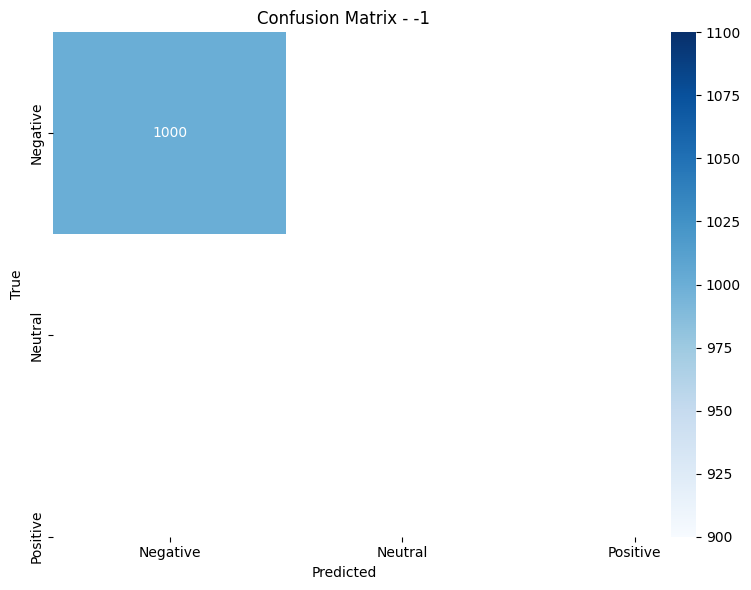

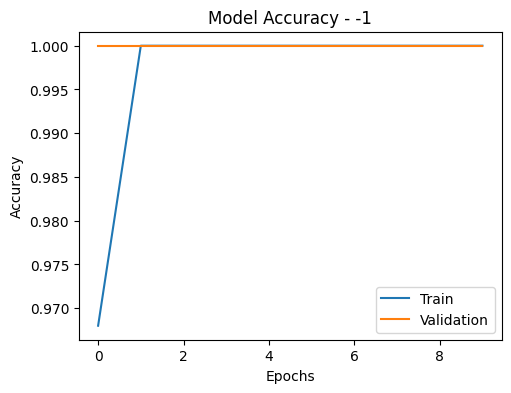

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8373 - loss: 0.6317 - val_accuracy: 0.9180 - val_loss: 0.3265
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9162 - loss: 0.3560 - val_accuracy: 0.9180 - val_loss: 0.3205
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9252 - loss: 0.3326 - val_accuracy: 0.9180 - val_loss: 0.3167
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9338 - loss: 0.2685 - val_accuracy: 0.9180 - val_loss: 0.3171
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9330 - loss: 0.2393 - val_accuracy: 0.9180 - val_loss: 0.3326
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9171 - loss: 0.2479 - val_accuracy: 0.9180 - val_loss: 0.3799
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: company-brand.competitor, Accuracy: 0.9210, F1 (weighted): 0.8831
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


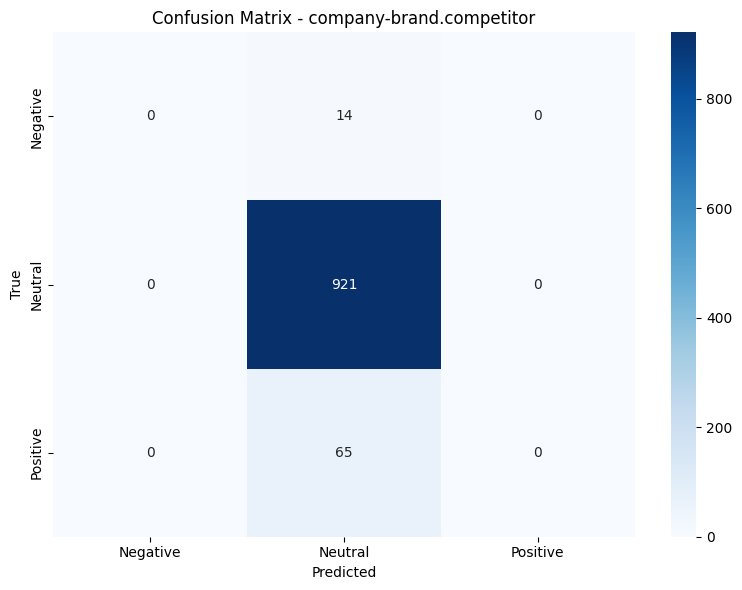

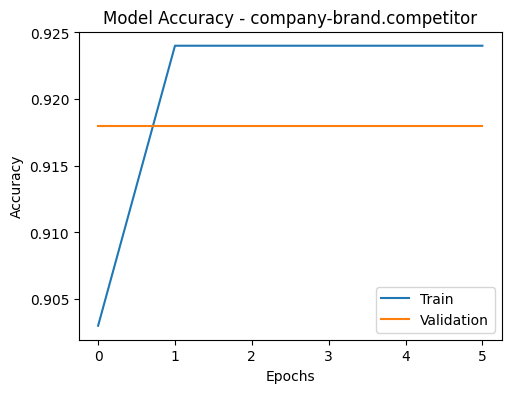

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8760 - loss: 0.4299 - val_accuracy: 1.0000 - val_loss: 1.6035e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 2.1577e-06 - val_accuracy: 1.0000 - val_loss: 5.6351e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 1.0000 - loss: 2.0139e-06 - val_accuracy: 1.0000 - val_loss: 5.2192e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 4.1166e-06 - val_accuracy: 1.0000 - val_loss: 5.0025e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 2.2901e-06 - val_accuracy: 1.0000 - val_loss: 4.8641e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 1.0000 - loss: 2.1686e-06 - val_accuracy: 1.0000 - val_loss: 4.7471e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 1.0924e-06 - val_accuracy: 1.0000 - val_loss: 4.6212e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 1.0000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


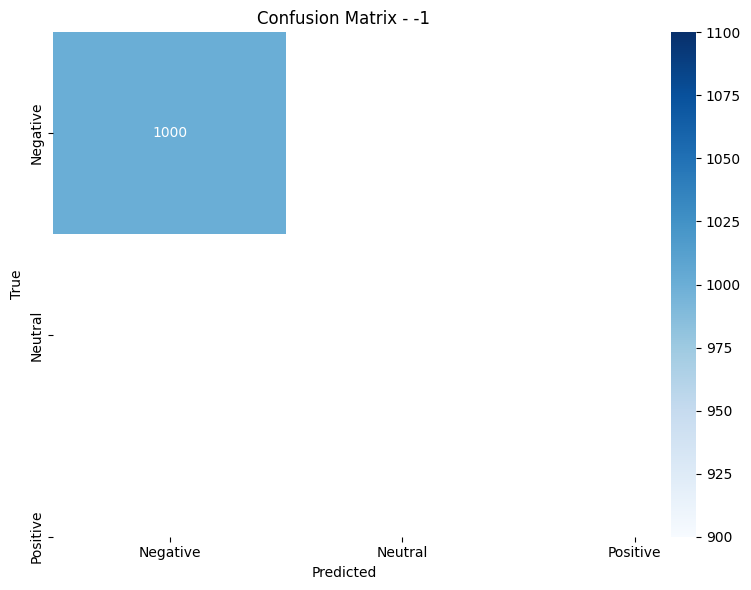

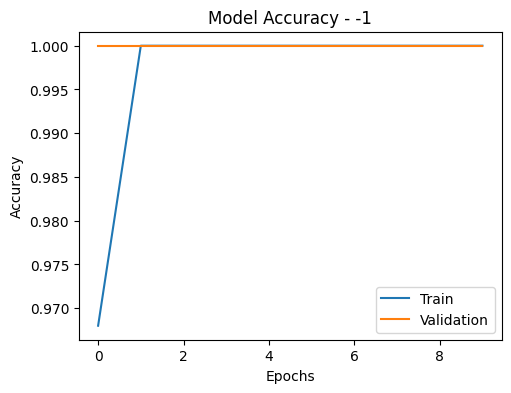

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.6739 - loss: 0.9132 - val_accuracy: 0.6850 - val_loss: 0.7808
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6905 - loss: 0.7890 - val_accuracy: 0.6850 - val_loss: 0.7689
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6896 - loss: 0.7596 - val_accuracy: 0.6850 - val_loss: 0.7325
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7355 - loss: 0.6219 - val_accuracy: 0.7770 - val_loss: 0.6158
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.8409 - loss: 0.4006 - val_accuracy: 0.8040 - val_loss: 0.6109
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9203 - loss: 0.2545 - val_accuracy: 0.7970 - val_loss: 0.6992
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9485 - loss: 0.1524 - val_accuracy: 0.7780 - val_loss: 0.7797
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9597 - loss: 0.1492 - val_accuracy: 0.7930 - val_loss: 

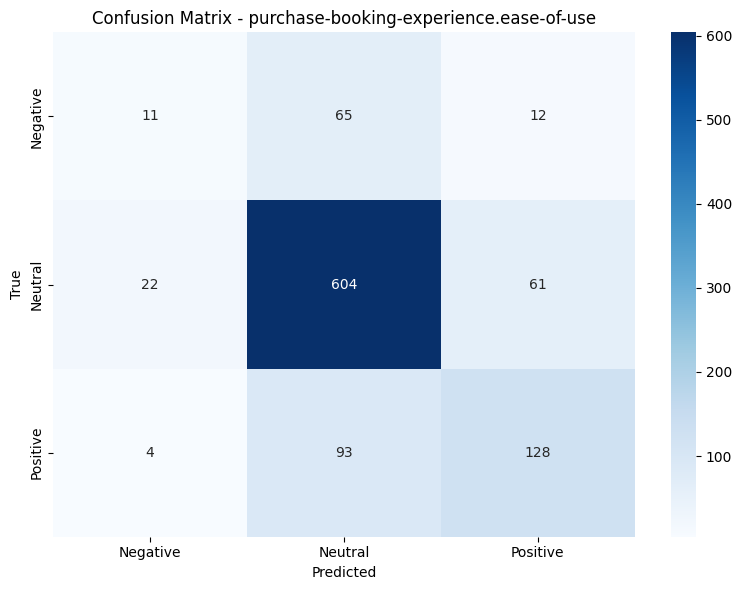

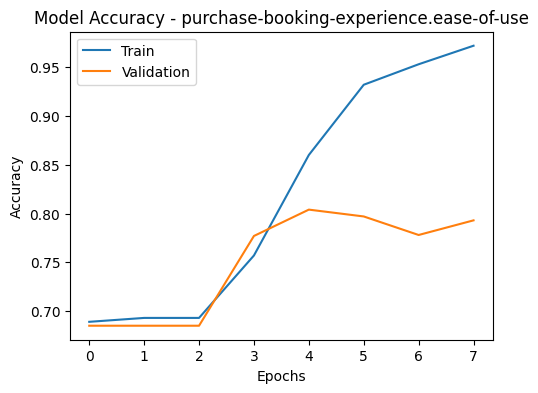

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 1.0000 - loss: 0.3620 - val_accuracy: 1.0000 - val_loss: 3.0469e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 1.4975e-05 - val_accuracy: 1.0000 - val_loss: 1.0409e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 4.7571e-06 - val_accuracy: 1.0000 - val_loss: 8.4731e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 1.0000 - loss: 2.7328e-06 - val_accuracy: 1.0000 - val_loss: 7.7630e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 5.9148e-06 - val_accuracy: 1.0000 - val_loss: 6.8337e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.4390e-06 - val_accuracy: 1.0000 - val_loss: 6.1704e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 1.0000 - loss: 1.3645e-06 - val_accuracy: 1.0000 - val_loss: 5.8759e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


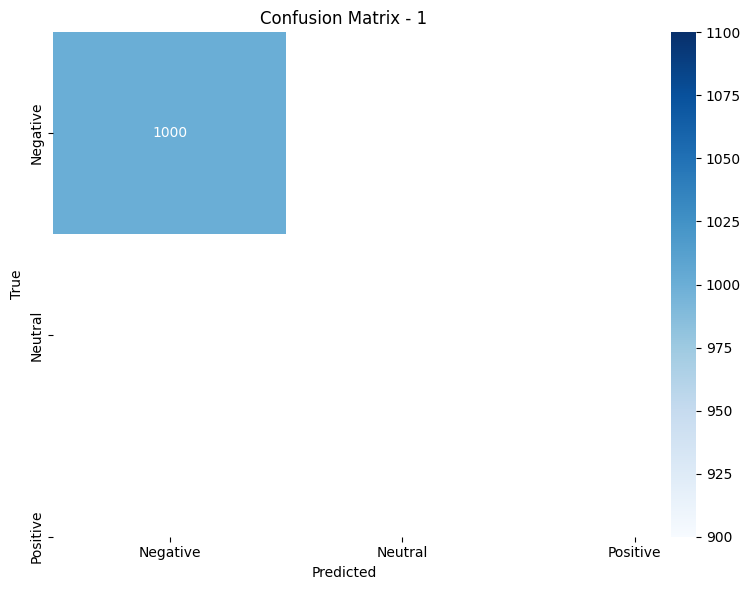

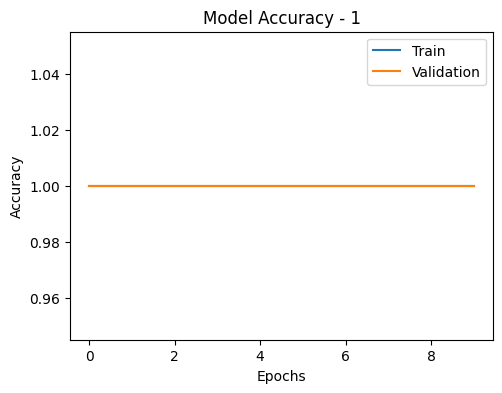

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5206 - loss: 1.0227 - val_accuracy: 0.5940 - val_loss: 0.9542
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.5559 - loss: 0.9622 - val_accuracy: 0.5940 - val_loss: 0.9224
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5784 - loss: 0.8918 - val_accuracy: 0.5970 - val_loss: 0.8842
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6803 - loss: 0.6770 - val_accuracy: 0.6510 - val_loss: 0.8642
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8270 - loss: 0.4101 - val_accuracy: 0.6850 - val_loss: 0.9015
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9119 - loss: 0.2069 - val_accuracy: 0.6820 - val_loss: 1.0643
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9260 - loss: 0.1683 - val_accuracy: 0.6790 - val_loss: 1.0977
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Category: online-experience.app-website, Accuracy: 0.7010, F1 (weighted): 0.692

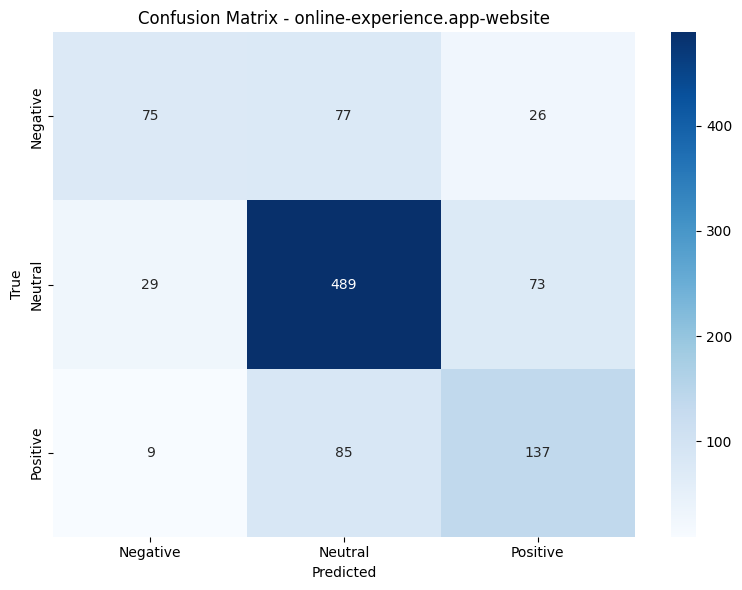

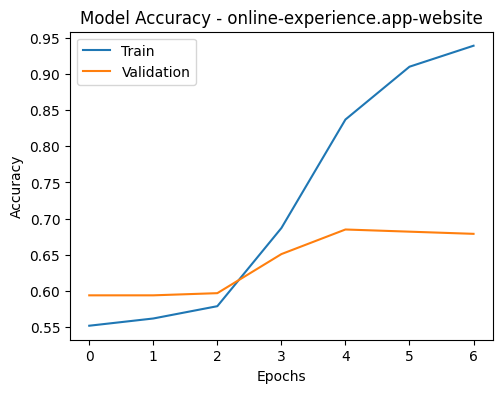

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9535 - loss: 0.3943 - val_accuracy: 1.0000 - val_loss: 1.9510e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 1.0000 - loss: 2.5507e-05 - val_accuracy: 1.0000 - val_loss: 6.2136e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 2.5565e-06 - val_accuracy: 1.0000 - val_loss: 5.7040e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.6619e-06 - val_accuracy: 1.0000 - val_loss: 5.5132e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 6.1626e-07 - val_accuracy: 1.0000 - val_loss: 5.3867e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.6421e-06 - val_accuracy: 1.0000 - val_loss: 5.0801e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 2.2031e-06 - val_accuracy: 1.0000 - val_loss: 4.8582e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


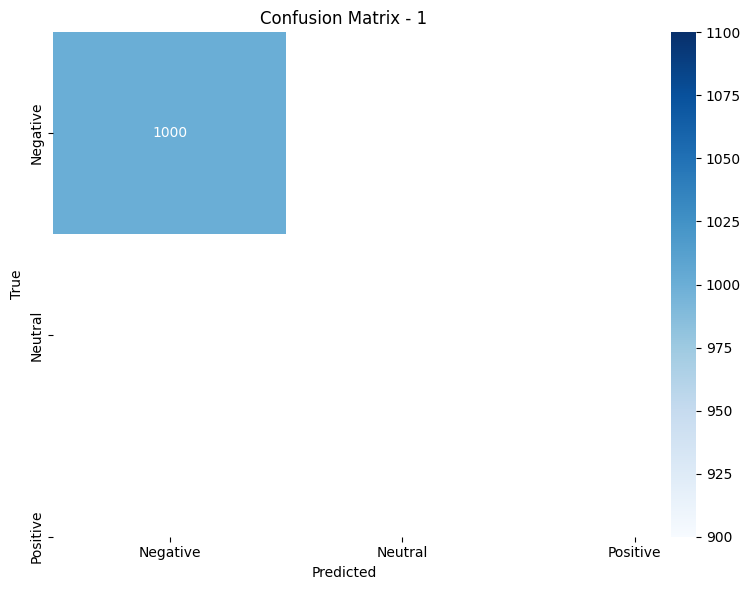

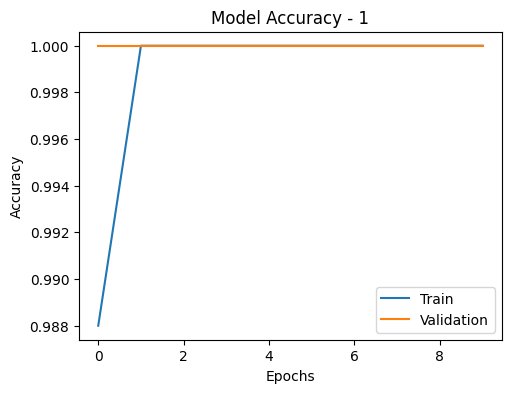

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7793 - loss: 0.6904 - val_accuracy: 0.8760 - val_loss: 0.4530
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8762 - loss: 0.4503 - val_accuracy: 0.8760 - val_loss: 0.4202
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.8758 - loss: 0.4267 - val_accuracy: 0.8760 - val_loss: 0.4487
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8915 - loss: 0.3757 - val_accuracy: 0.8760 - val_loss: 0.4149
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8724 - loss: 0.3611 - val_accuracy: 0.8800 - val_loss: 0.4091
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9330 - loss: 0.2257 - val_accuracy: 0.8820 - val_loss: 0.4098
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9425 - loss: 0.1637 - val_accuracy: 0.8930 - val_loss: 0.5335
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9751 - loss: 0.0896 - val_accuracy: 0.8910 - val_loss

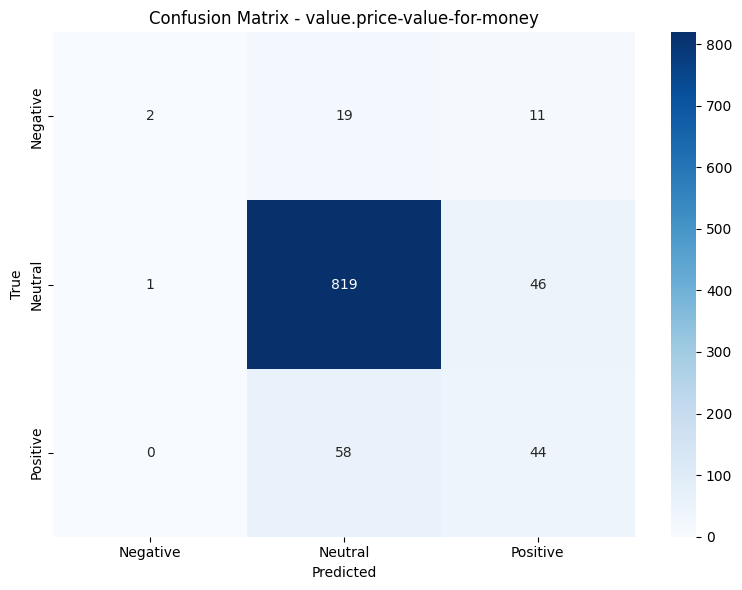

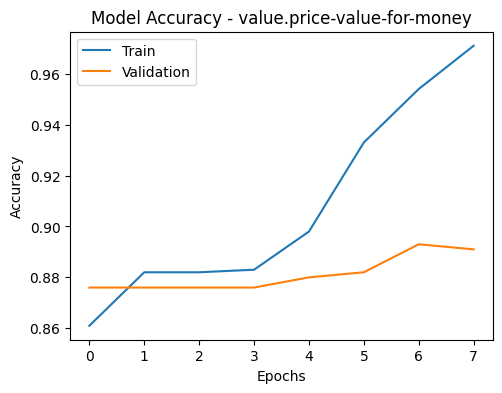

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 0.3424 - val_accuracy: 1.0000 - val_loss: 2.6199e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 1.0000 - loss: 8.5479e-06 - val_accuracy: 1.0000 - val_loss: 1.0164e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 4.2170e-06 - val_accuracy: 1.0000 - val_loss: 9.0410e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 1.0000 - loss: 3.4176e-06 - val_accuracy: 1.0000 - val_loss: 8.1246e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 1.0000 - loss: 3.8718e-06 - val_accuracy: 1.0000 - val_loss: 6.8996e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 1.0000 - loss: 2.1670e-06 - val_accuracy: 1.0000 - val_loss: 5.7545e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 1.0000 - loss: 1.3167e-06 - val_accuracy: 1.0000 - val_loss: 4.9070e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


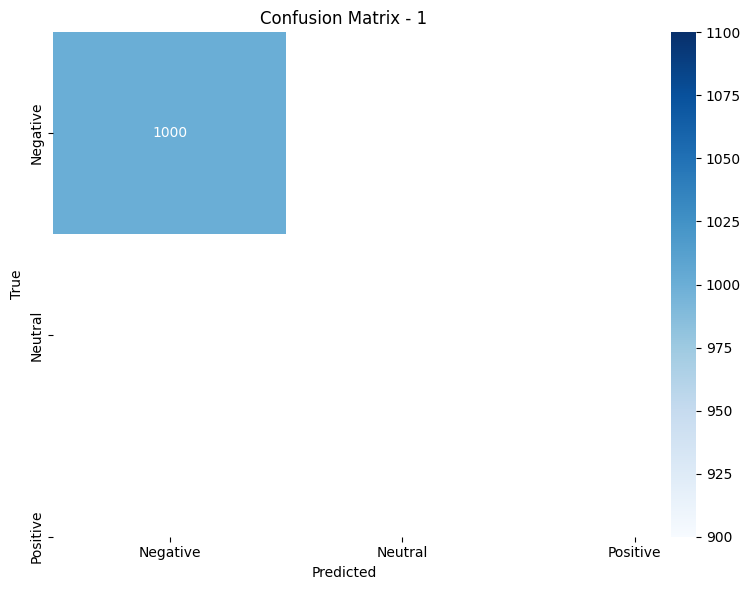

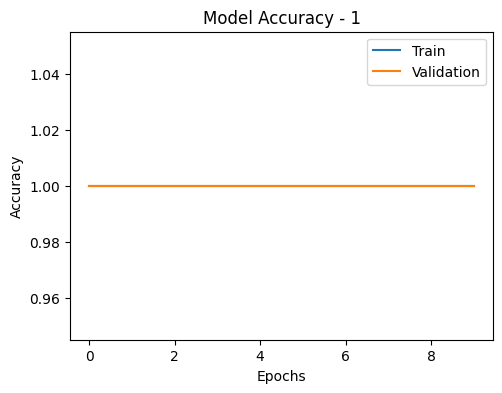

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7507 - loss: 0.7218 - val_accuracy: 0.8850 - val_loss: 0.4359
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8689 - loss: 0.4848 - val_accuracy: 0.8850 - val_loss: 0.4335
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8585 - loss: 0.4765 - val_accuracy: 0.8810 - val_loss: 0.3928
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8570 - loss: 0.4221 - val_accuracy: 0.8850 - val_loss: 0.3869
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9039 - loss: 0.2766 - val_accuracy: 0.8990 - val_loss: 0.4116
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9447 - loss: 0.1376 - val_accuracy: 0.9010 - val_loss: 0.4143
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9632 - loss: 0.1003 - val_accuracy: 0.9000 - val_loss: 0.4848
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Category: staff-support.attitude-of-staff, Accuracy: 0.8890, F1 (weighted): 0.88

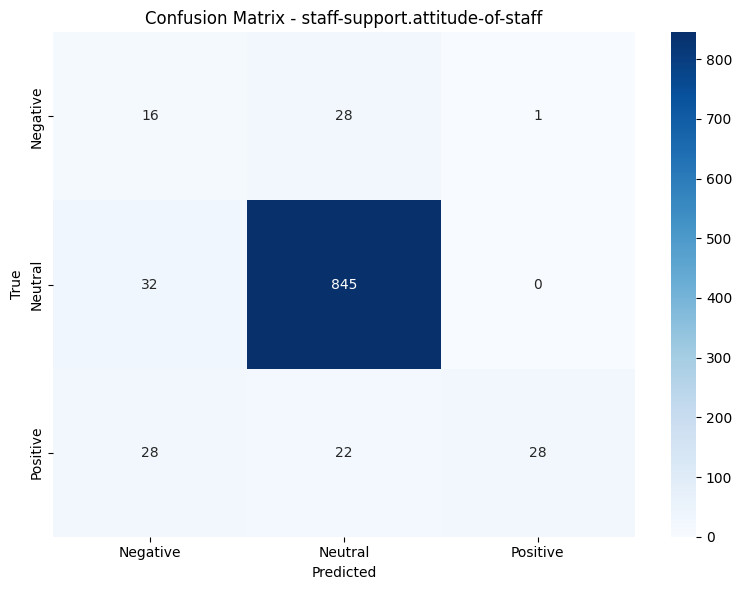

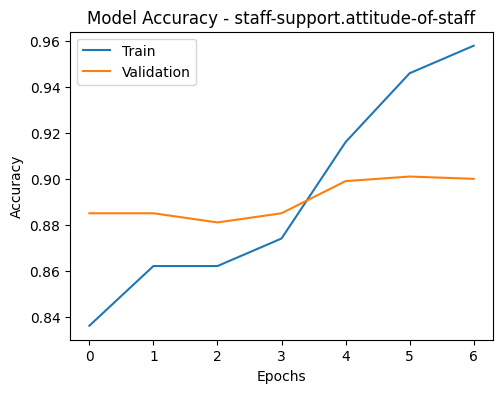

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8954 - loss: 0.4246 - val_accuracy: 1.0000 - val_loss: 3.6905e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.0765e-05 - val_accuracy: 1.0000 - val_loss: 1.3975e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 4.5409e-06 - val_accuracy: 1.0000 - val_loss: 1.2733e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 6.0260e-06 - val_accuracy: 1.0000 - val_loss: 1.1777e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 2.1821e-06 - val_accuracy: 1.0000 - val_loss: 1.1173e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 7.0155e-06 - val_accuracy: 1.0000 - val_loss: 1.0370e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.5332e-06 - val_accuracy: 1.0000 - val_loss: 9.7130e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


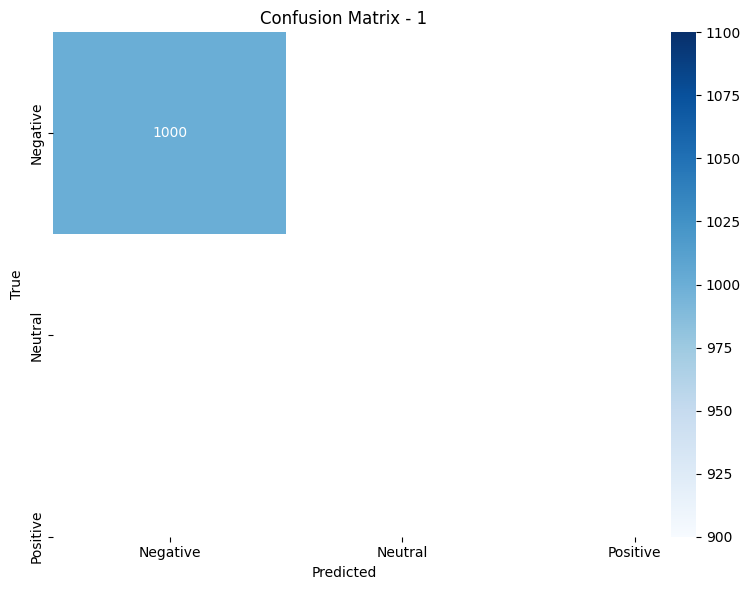

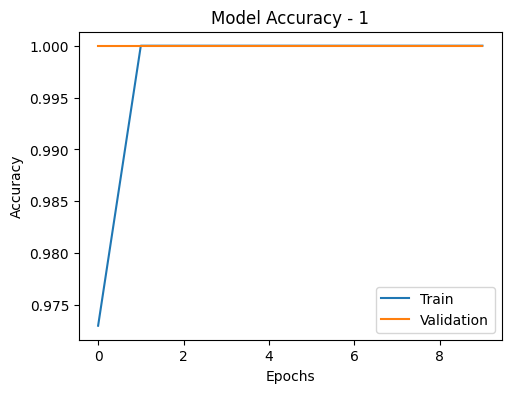

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8887 - loss: 0.5809 - val_accuracy: 0.9520 - val_loss: 0.2270
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9547 - loss: 0.2121 - val_accuracy: 0.9520 - val_loss: 0.2467
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9763 - loss: 0.1286 - val_accuracy: 0.9520 - val_loss: 0.2476
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9549 - loss: 0.2007 - val_accuracy: 0.9520 - val_loss: 0.2430
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Category: value.discounts-promotions, Accuracy: 0.9490, F1 (weighted): 0.9242
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


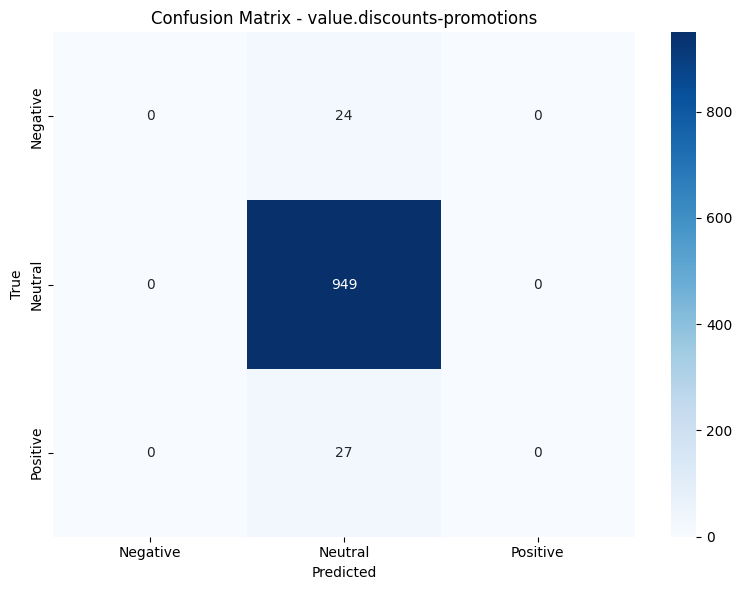

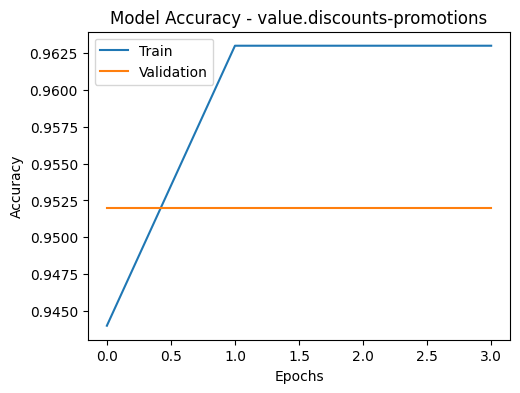

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8760 - loss: 0.4633 - val_accuracy: 1.0000 - val_loss: 5.0897e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 8.7063e-06 - val_accuracy: 1.0000 - val_loss: 1.5448e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 1.0000 - loss: 1.2691e-05 - val_accuracy: 1.0000 - val_loss: 1.3079e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 1.0000 - loss: 7.2690e-06 - val_accuracy: 1.0000 - val_loss: 1.2040e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 4.6078e-06 - val_accuracy: 1.0000 - val_loss: 1.0965e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 1.0000 - loss: 2.1850e-06 - val_accuracy: 1.0000 - val_loss: 1.0120e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 1.5370e-06 - val_accuracy: 1.0000 - val_loss: 9.4617e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


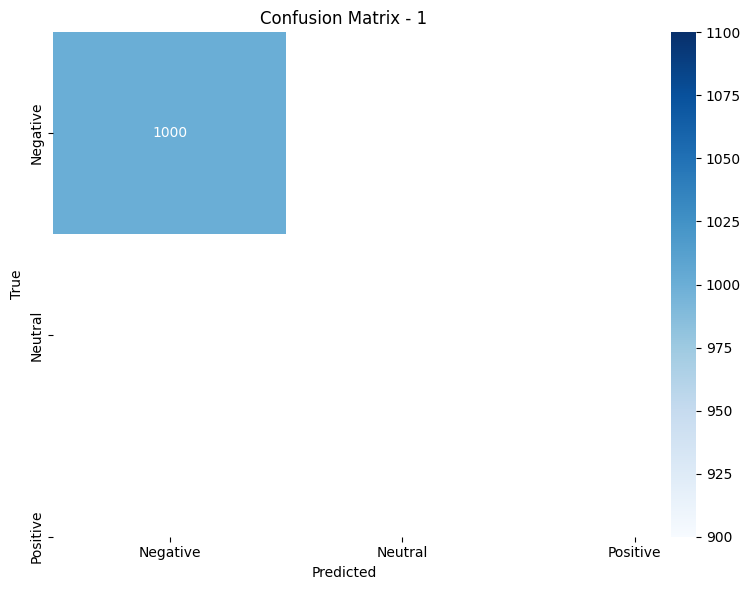

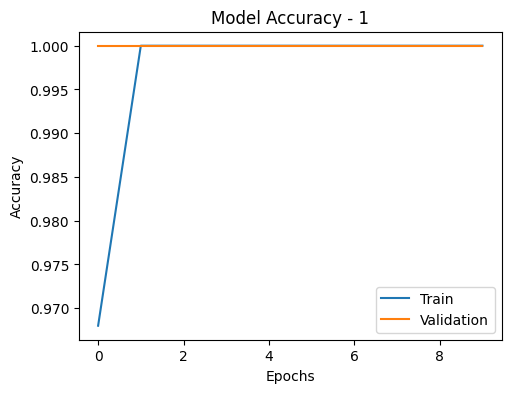

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.8895 - loss: 0.5361 - val_accuracy: 0.9420 - val_loss: 0.2611
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9749 - loss: 0.1549 - val_accuracy: 0.9420 - val_loss: 0.2455
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9713 - loss: 0.1427 - val_accuracy: 0.9420 - val_loss: 0.2479
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9705 - loss: 0.1344 - val_accuracy: 0.9420 - val_loss: 0.2528
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9705 - loss: 0.1184 - val_accuracy: 0.9420 - val_loss: 0.2934
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Category: account-management.account-access, Accuracy: 0.9660, F1 (weighted): 0.9493
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


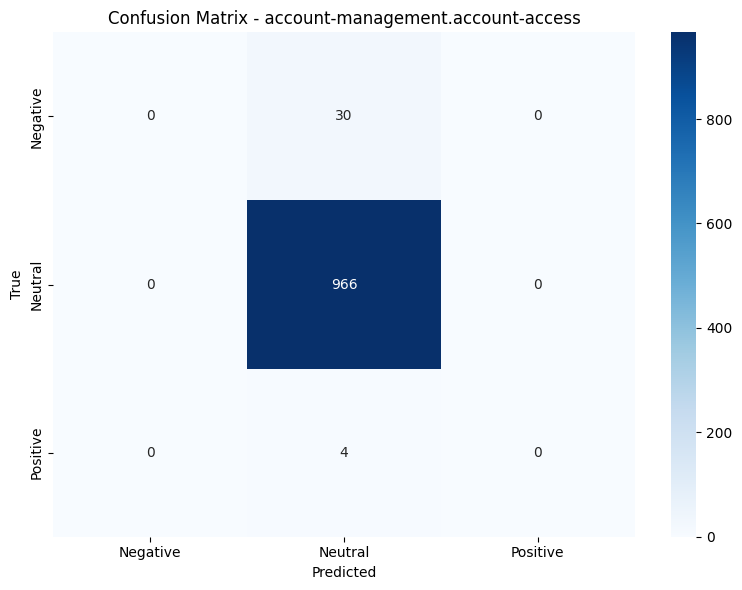

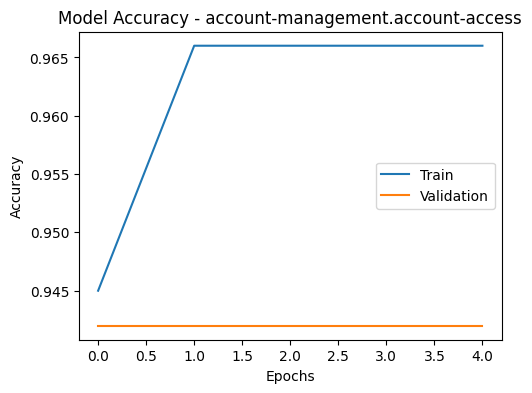

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9186 - loss: 0.3853 - val_accuracy: 1.0000 - val_loss: 1.6377e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 9.6821e-06 - val_accuracy: 1.0000 - val_loss: 5.9334e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.7865e-06 - val_accuracy: 1.0000 - val_loss: 5.1909e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 1.0000 - loss: 1.7728e-06 - val_accuracy: 1.0000 - val_loss: 4.8986e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 1.0000 - loss: 2.8408e-06 - val_accuracy: 1.0000 - val_loss: 4.5240e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.6346e-06 - val_accuracy: 1.0000 - val_loss: 4.2170e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 1.0000 - loss: 1.0944e-06 - val_accuracy: 1.0000 - val_loss: 3.6102e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


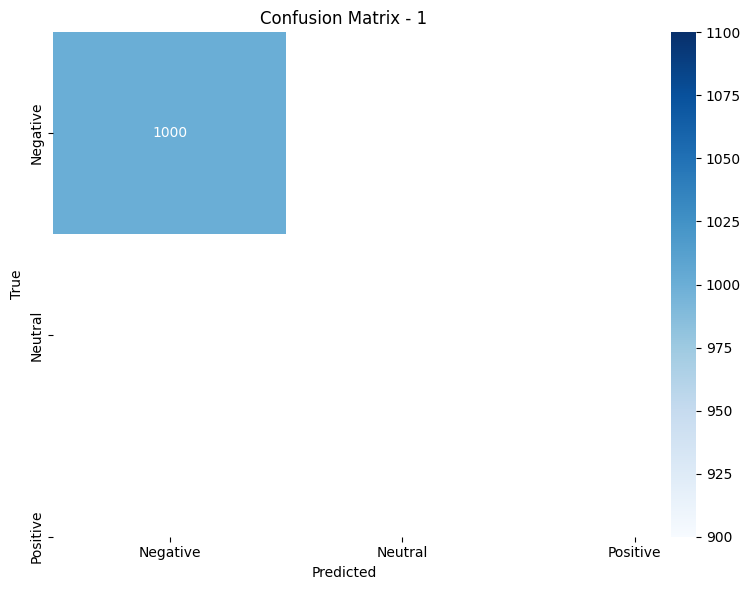

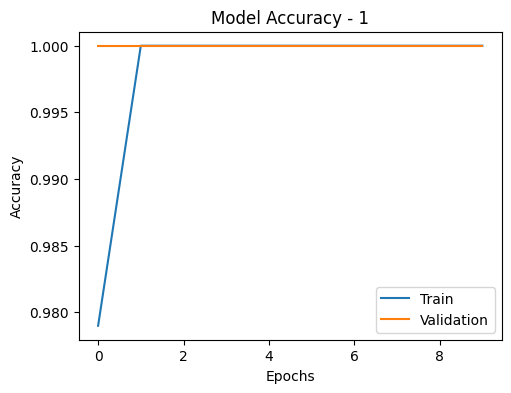

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9718 - loss: 0.5313 - val_accuracy: 0.9420 - val_loss: 0.2612
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9659 - loss: 0.1933 - val_accuracy: 0.9420 - val_loss: 0.3319
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9631 - loss: 0.1826 - val_accuracy: 0.9420 - val_loss: 0.3010
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9647 - loss: 0.1742 - val_accuracy: 0.9420 - val_loss: 0.2759
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Category: account-management.account-access, Accuracy: 0.9660, F1 (weighted): 0.9493
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


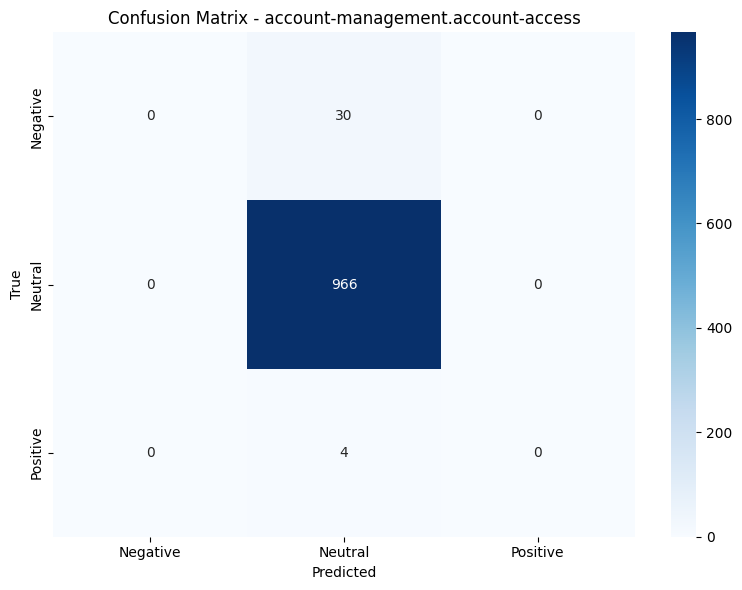

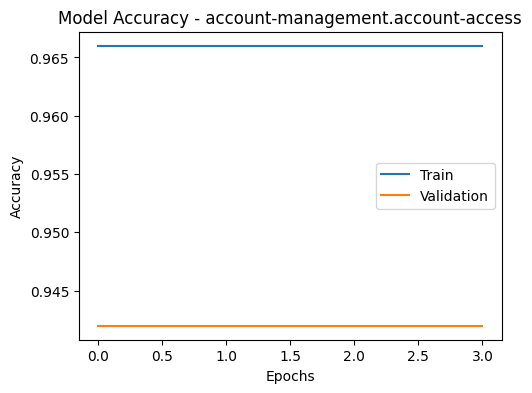

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9070 - loss: 0.4147 - val_accuracy: 1.0000 - val_loss: 2.1896e-06
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.7044e-07 - val_accuracy: 1.0000 - val_loss: 5.8745e-07
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 1.8454e-07 - val_accuracy: 1.0000 - val_loss: 5.4799e-07
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.6748e-07 - val_accuracy: 1.0000 - val_loss: 5.4132e-07
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 3.0191e-07 - val_accuracy: 1.0000 - val_loss: 5.3679e-07
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 1.0000 - loss: 2.7200e-07 - val_accuracy: 1.0000 - val_loss: 5.3226e-07
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 1.4507e-07 - val_accuracy: 1.0000 - val_loss: 5.2642e-07
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 1.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


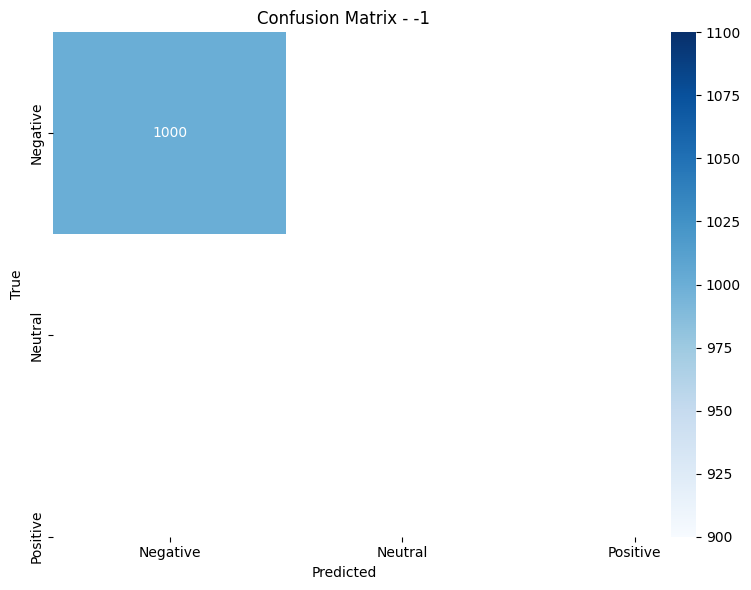

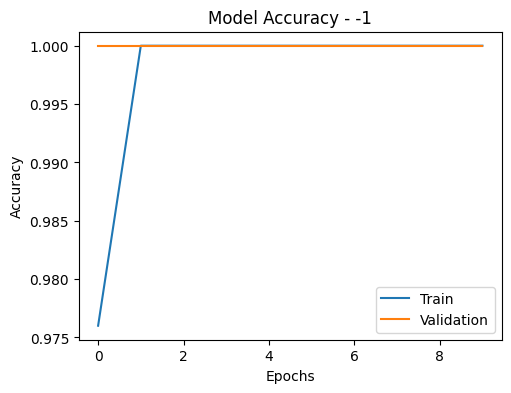

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.6291 - loss: 0.9170 - val_accuracy: 0.6850 - val_loss: 0.8123
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6932 - loss: 0.8061 - val_accuracy: 0.6850 - val_loss: 0.8083
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6850 - loss: 0.7737 - val_accuracy: 0.6850 - val_loss: 0.7267
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7177 - loss: 0.6603 - val_accuracy: 0.8130 - val_loss: 0.5583
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8587 - loss: 0.3712 - val_accuracy: 0.8080 - val_loss: 0.5773
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9402 - loss: 0.2275 - val_accuracy: 0.7640 - val_loss: 0.6727
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9367 - loss: 0.1899 - val_accuracy: 0.7920 - val_loss: 0.8541
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Category: purchase-booking-experience.ease-of-use, Accuracy: 0.7490, F1 (weight

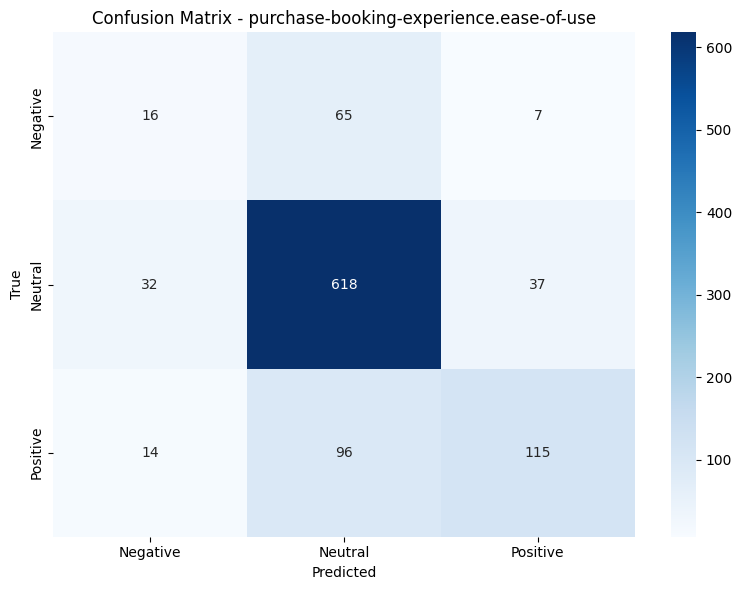

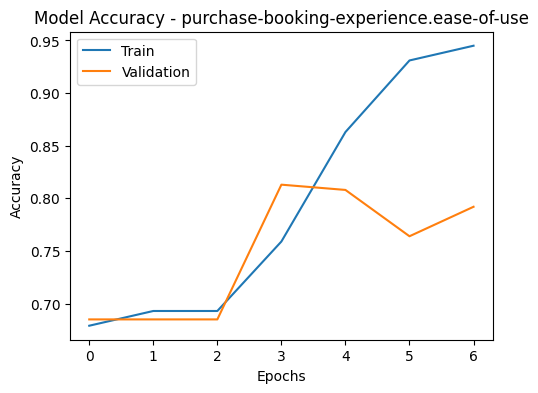

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9768 - loss: 0.3466 - val_accuracy: 1.0000 - val_loss: 3.8239e-06
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 3.4756e-06 - val_accuracy: 1.0000 - val_loss: 1.2900e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 8.2256e-07 - val_accuracy: 1.0000 - val_loss: 1.2024e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 1.0000 - loss: 6.8232e-07 - val_accuracy: 1.0000 - val_loss: 1.1781e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 1.0000 - loss: 6.3228e-07 - val_accuracy: 1.0000 - val_loss: 1.1617e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 1.0000 - loss: 1.4518e-06 - val_accuracy: 1.0000 - val_loss: 1.1333e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 1.0000 - loss: 3.7521e-07 - val_accuracy: 1.0000 - val_loss: 1.1154e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


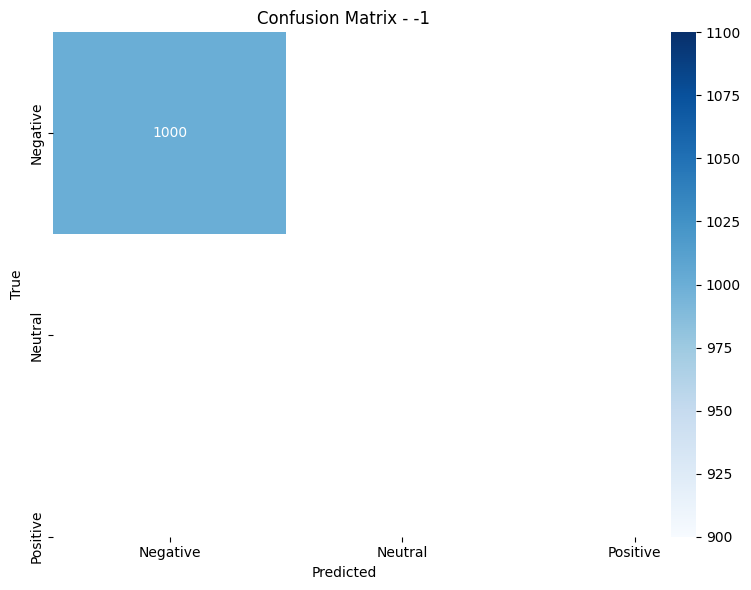

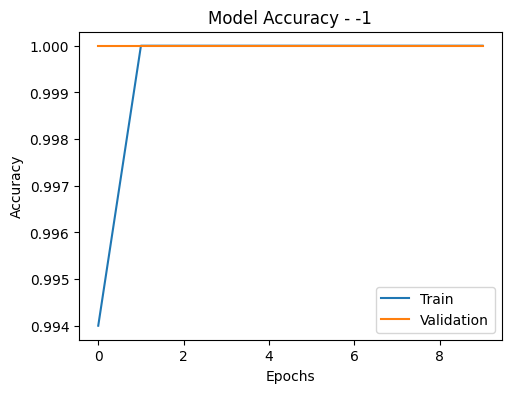

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9157 - loss: 0.5111 - val_accuracy: 0.9520 - val_loss: 0.2265
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9683 - loss: 0.1846 - val_accuracy: 0.9520 - val_loss: 0.2267
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9642 - loss: 0.1802 - val_accuracy: 0.9520 - val_loss: 0.2408
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9558 - loss: 0.2009 - val_accuracy: 0.9520 - val_loss: 0.2871
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: value.discounts-promotions, Accuracy: 0.9490, F1 (weighted): 0.9242
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


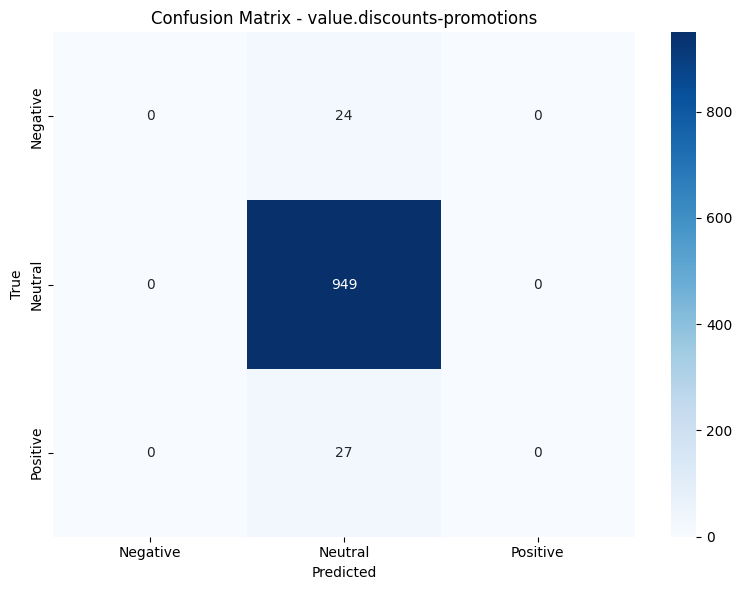

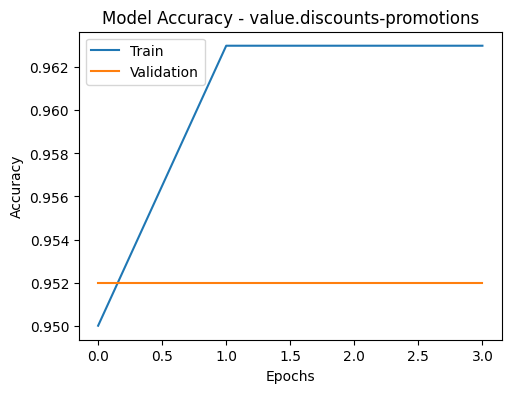

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9380 - loss: 0.4422 - val_accuracy: 1.0000 - val_loss: 4.2756e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 9.6739e-06 - val_accuracy: 1.0000 - val_loss: 1.5629e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 1.0000 - loss: 1.3438e-05 - val_accuracy: 1.0000 - val_loss: 1.3696e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 1.0000 - loss: 8.6119e-06 - val_accuracy: 1.0000 - val_loss: 1.2652e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 1.0000 - loss: 1.3595e-05 - val_accuracy: 1.0000 - val_loss: 1.1292e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 1.0000 - loss: 4.0387e-06 - val_accuracy: 1.0000 - val_loss: 1.0454e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 4.6805e-06 - val_accuracy: 1.0000 - val_loss: 9.8032e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 1.0000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


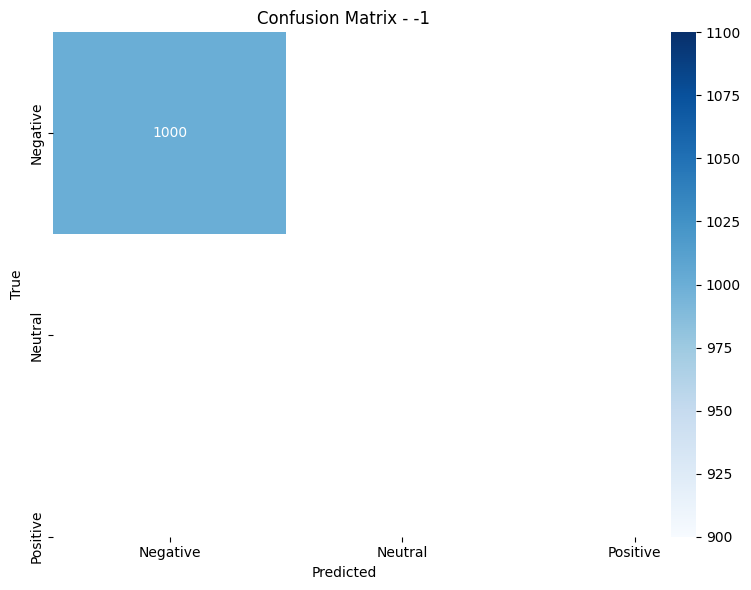

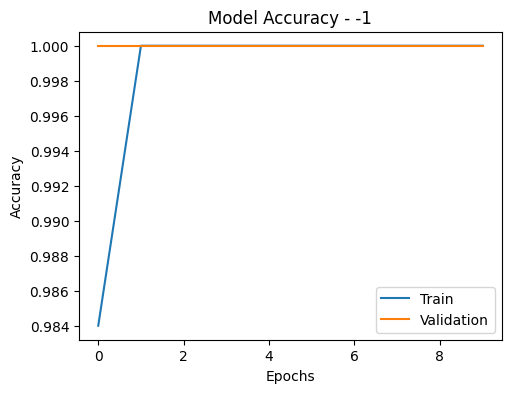

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8055 - loss: 0.7164 - val_accuracy: 0.8910 - val_loss: 0.4358
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8743 - loss: 0.4682 - val_accuracy: 0.8910 - val_loss: 0.4264
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8583 - loss: 0.4880 - val_accuracy: 0.8910 - val_loss: 0.4160
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.8568 - loss: 0.4383 - val_accuracy: 0.8910 - val_loss: 0.4165
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8738 - loss: 0.3425 - val_accuracy: 0.8910 - val_loss: 0.4626
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8664 - loss: 0.2952 - val_accuracy: 0.8930 - val_loss: 0.4918
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Category: logistics-rides.speed, Accuracy: 0.8860, F1 (weighted): 0.8344
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


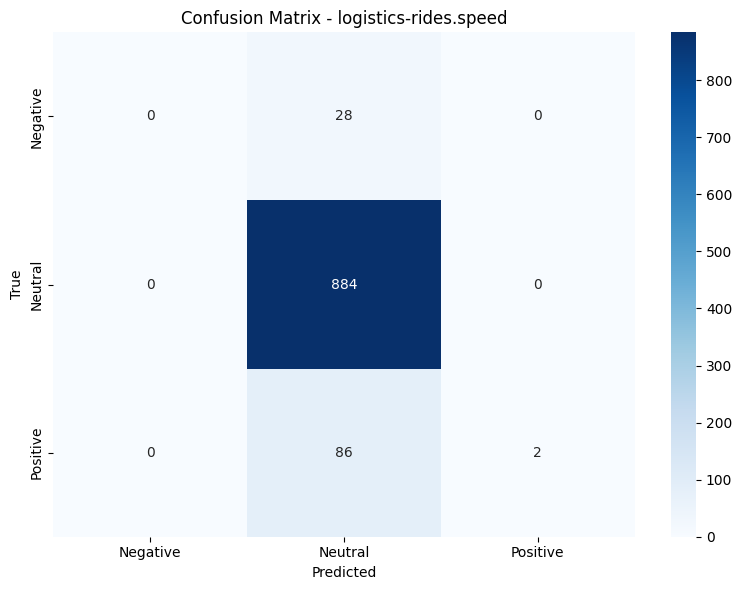

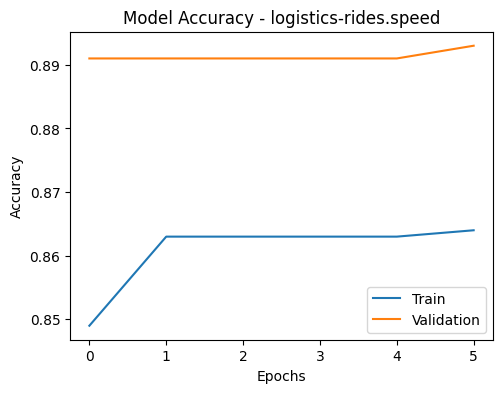

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9806 - loss: 0.3956 - val_accuracy: 1.0000 - val_loss: 1.3032e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 1.0000 - loss: 4.3312e-06 - val_accuracy: 1.0000 - val_loss: 4.2847e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 1.7806e-06 - val_accuracy: 1.0000 - val_loss: 3.8383e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 1.0000 - loss: 6.2645e-07 - val_accuracy: 1.0000 - val_loss: 3.7002e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 1.0000 - loss: 1.4053e-06 - val_accuracy: 1.0000 - val_loss: 3.4940e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4849e-06 - val_accuracy: 1.0000 - val_loss: 3.2812e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 2.1625e-06 - val_accuracy: 1.0000 - val_loss: 3.1163e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


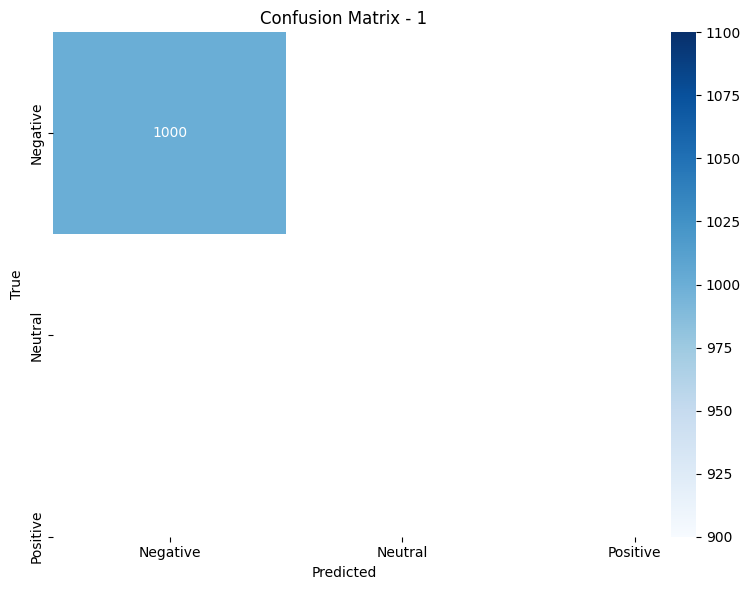

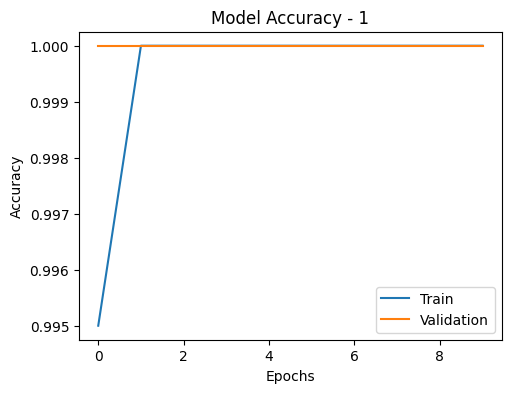

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.5173 - loss: 1.0257 - val_accuracy: 0.5940 - val_loss: 0.9393
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5720 - loss: 0.9413 - val_accuracy: 0.5950 - val_loss: 0.9215
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5932 - loss: 0.8927 - val_accuracy: 0.6300 - val_loss: 0.8462
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7078 - loss: 0.6771 - val_accuracy: 0.7000 - val_loss: 0.8239
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8364 - loss: 0.4386 - val_accuracy: 0.7190 - val_loss: 0.8433
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9093 - loss: 0.2672 - val_accuracy: 0.7090 - val_loss: 0.9266
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9335 - loss: 0.1683 - val_accuracy: 0.7220 - val_loss: 0.9668
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Category: online-experience.app-website, Accuracy: 0.7100, F1 (weighted): 0.709

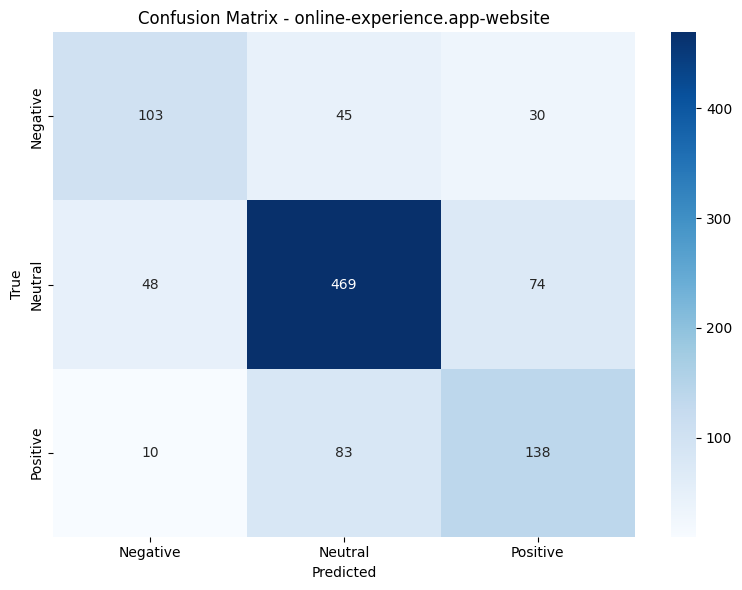

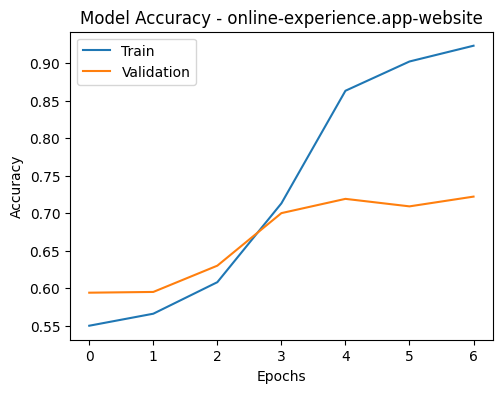

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9225 - loss: 0.4074 - val_accuracy: 1.0000 - val_loss: 3.1328e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 1.8847e-05 - val_accuracy: 1.0000 - val_loss: 1.0782e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.0000 - loss: 4.7840e-06 - val_accuracy: 1.0000 - val_loss: 9.5884e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 1.0000 - loss: 1.4108e-06 - val_accuracy: 1.0000 - val_loss: 9.1155e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 1.0000 - loss: 1.7428e-06 - val_accuracy: 1.0000 - val_loss: 8.5136e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.1953e-06 - val_accuracy: 1.0000 - val_loss: 7.9132e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.8827e-05 - val_accuracy: 1.0000 - val_loss: 6.4171e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


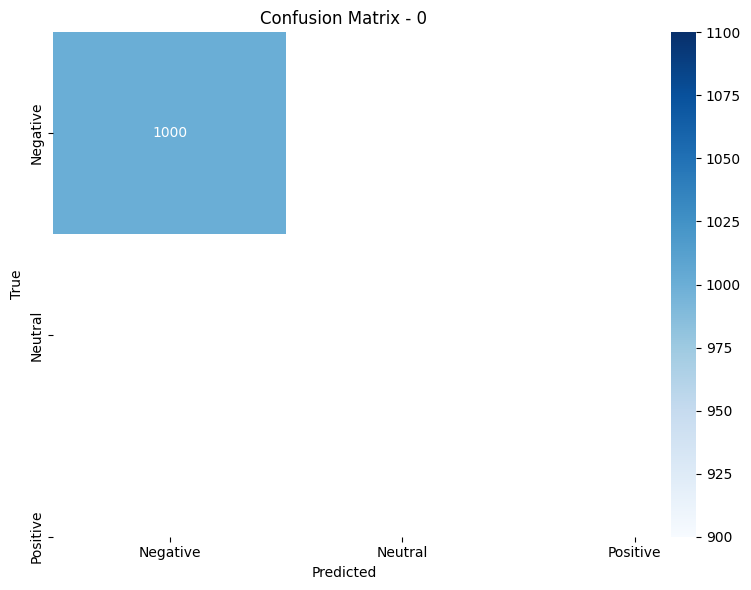

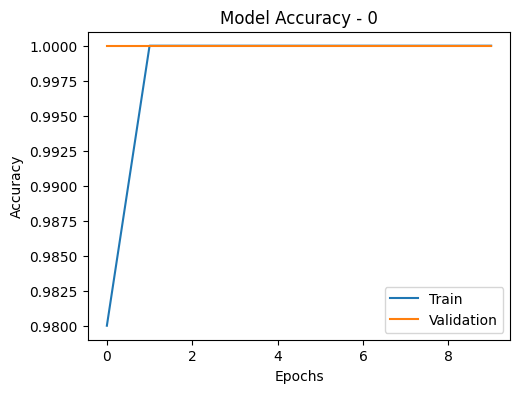

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8607 - loss: 0.5575 - val_accuracy: 0.9860 - val_loss: 0.1304
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9883 - loss: 0.0968 - val_accuracy: 0.9860 - val_loss: 0.0933
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9870 - loss: 0.0827 - val_accuracy: 0.9860 - val_loss: 0.0790
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9792 - loss: 0.1065 - val_accuracy: 0.9860 - val_loss: 0.0720
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9787 - loss: 0.0903 - val_accuracy: 0.9860 - val_loss: 0.0850
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9809 - loss: 0.1051 - val_accuracy: 0.9860 - val_loss: 0.0703
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9741 - loss: 0.1175 - val_accuracy: 0.9860 - val_loss: 0.0719
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9849 - loss: 0.0538 - val_accuracy: 0.9860 - val_loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: staff-support.phone, Accuracy: 0.9780, F1 (weighted): 0.9671
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


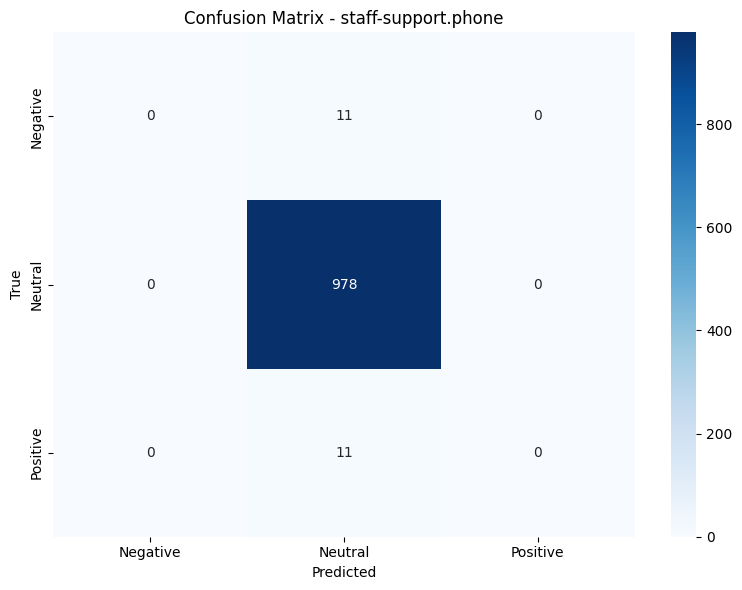

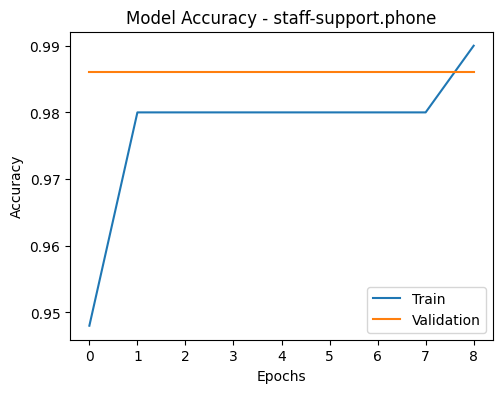

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8838 - loss: 0.4730 - val_accuracy: 1.0000 - val_loss: 1.1550e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 2.2269e-05 - val_accuracy: 1.0000 - val_loss: 3.8163e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 1.3156e-05 - val_accuracy: 1.0000 - val_loss: 3.1260e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 8.8435e-06 - val_accuracy: 1.0000 - val_loss: 2.8408e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 7.8971e-06 - val_accuracy: 1.0000 - val_loss: 2.5761e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 8.4369e-06 - val_accuracy: 1.0000 - val_loss: 2.2989e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 1.0000 - loss: 6.1211e-06 - val_accuracy: 1.0000 - val_loss: 2.1071e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


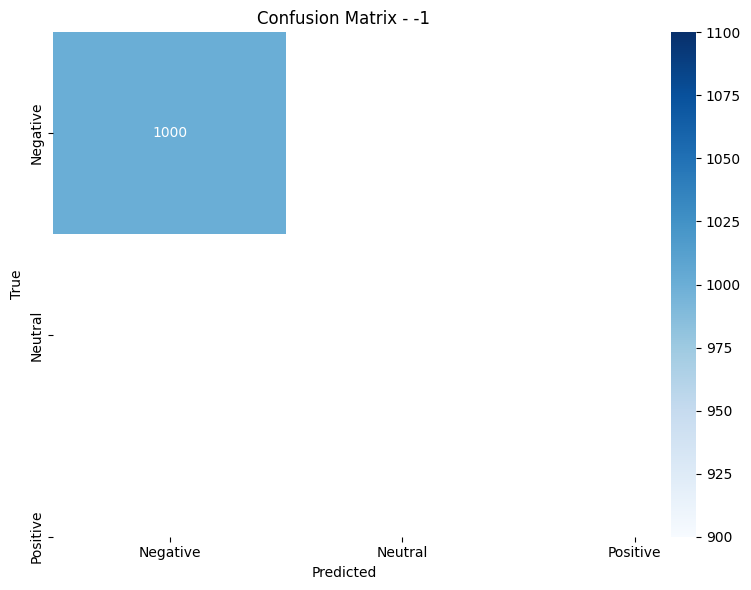

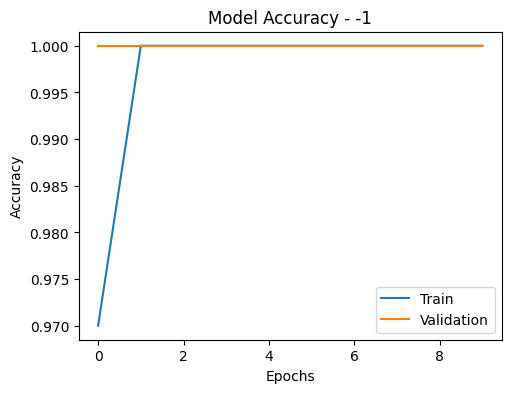

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9491 - loss: 0.5446 - val_accuracy: 0.9420 - val_loss: 0.2773
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9597 - loss: 0.2100 - val_accuracy: 0.9420 - val_loss: 0.2718
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9682 - loss: 0.1664 - val_accuracy: 0.9420 - val_loss: 0.2764
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9622 - loss: 0.1704 - val_accuracy: 0.9420 - val_loss: 0.3411
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9605 - loss: 0.1612 - val_accuracy: 0.9420 - val_loss: 0.3120
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Category: account-management.account-access, Accuracy: 0.9660, F1 (weighted): 0.9493
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


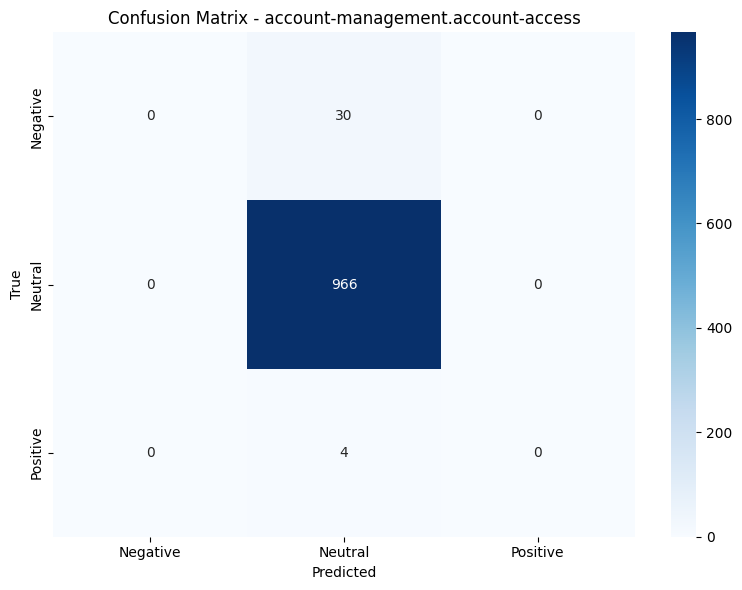

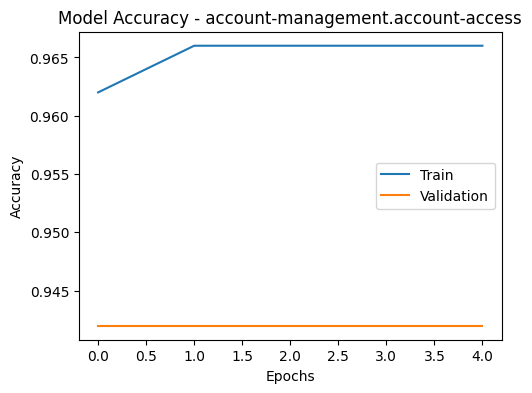

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.8760 - loss: 0.4955 - val_accuracy: 1.0000 - val_loss: 7.5510e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 1.0000 - loss: 1.9318e-05 - val_accuracy: 1.0000 - val_loss: 2.1183e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 1.0000 - loss: 4.2290e-06 - val_accuracy: 1.0000 - val_loss: 1.8074e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 1.0000 - loss: 3.8391e-06 - val_accuracy: 1.0000 - val_loss: 1.6020e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.7925e-06 - val_accuracy: 1.0000 - val_loss: 1.3498e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 2.3148e-06 - val_accuracy: 1.0000 - val_loss: 1.2316e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 3.0582e-06 - val_accuracy: 1.0000 - val_loss: 1.1265e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


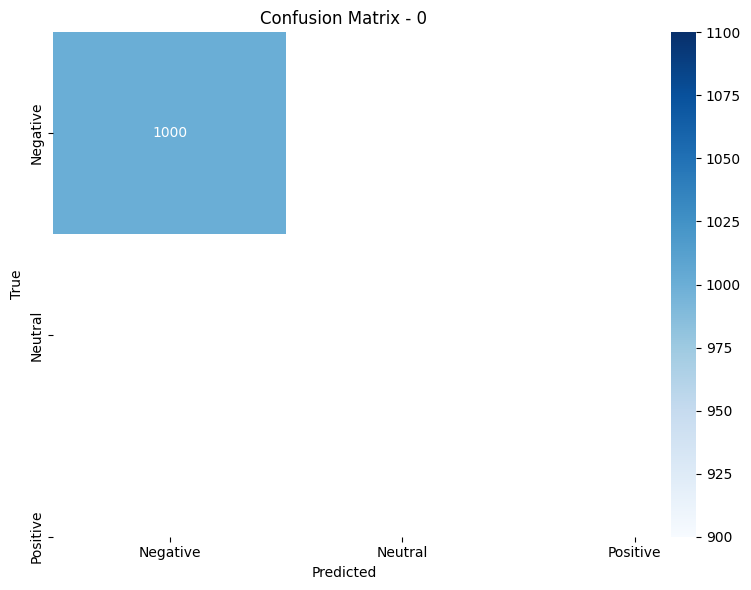

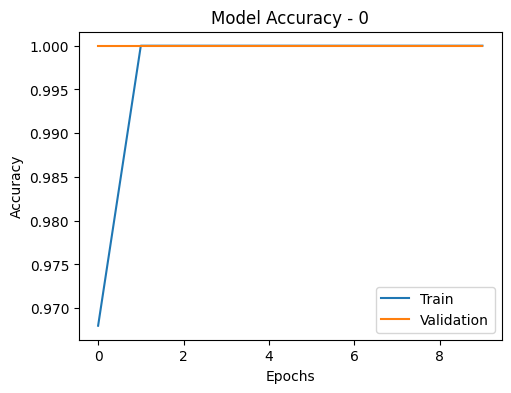

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7923 - loss: 0.6908 - val_accuracy: 0.8760 - val_loss: 0.4332
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8940 - loss: 0.4139 - val_accuracy: 0.8760 - val_loss: 0.4202
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8763 - loss: 0.4410 - val_accuracy: 0.8760 - val_loss: 0.4195
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8913 - loss: 0.3787 - val_accuracy: 0.8760 - val_loss: 0.4166
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8791 - loss: 0.3367 - val_accuracy: 0.8760 - val_loss: 0.4384
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9027 - loss: 0.2429 - val_accuracy: 0.8770 - val_loss: 0.4459
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9595 - loss: 0.1215 - val_accuracy: 0.8790 - val_loss: 0.5535
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Category: value.price-value-for-money, Accuracy: 0.8550, F1 (weighted): 0.8230
F

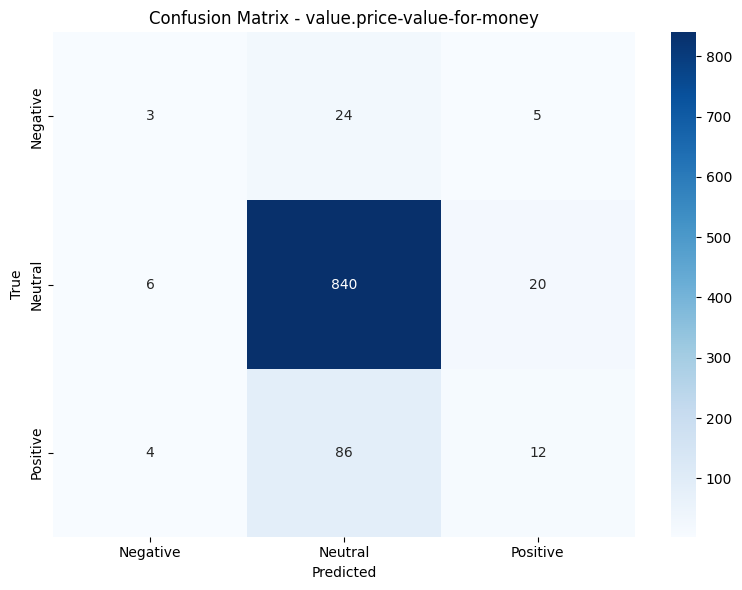

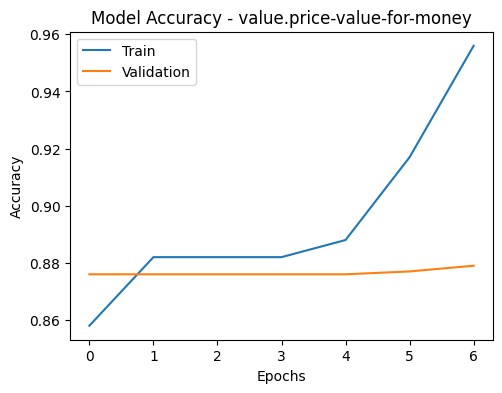

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8731 - loss: 0.4924 - val_accuracy: 1.0000 - val_loss: 5.5155e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 2.2055e-05 - val_accuracy: 1.0000 - val_loss: 1.7326e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 2.4420e-06 - val_accuracy: 1.0000 - val_loss: 1.5306e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 1.0000 - loss: 4.1171e-06 - val_accuracy: 1.0000 - val_loss: 1.4007e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 1.0000 - loss: 8.1546e-06 - val_accuracy: 1.0000 - val_loss: 1.2442e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 1.0000 - loss: 3.8938e-06 - val_accuracy: 1.0000 - val_loss: 1.1167e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 1.0000 - loss: 3.2458e-06 - val_accuracy: 1.0000 - val_loss: 1.0157e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


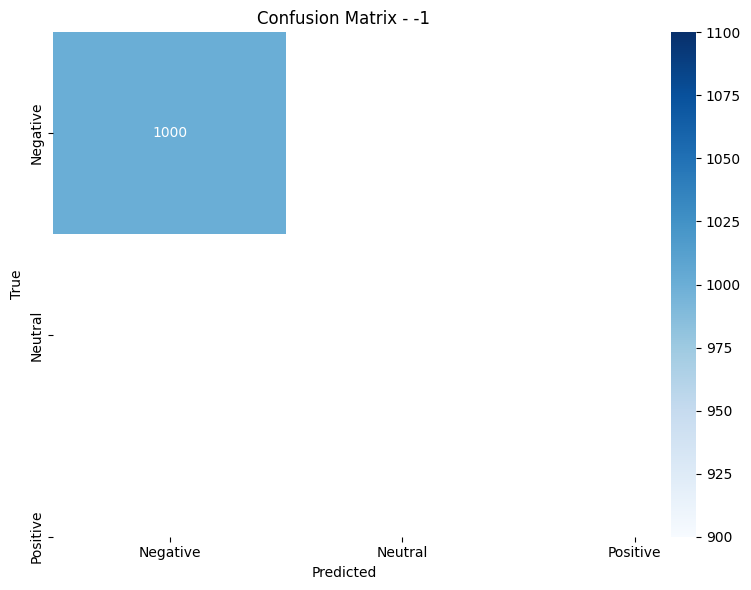

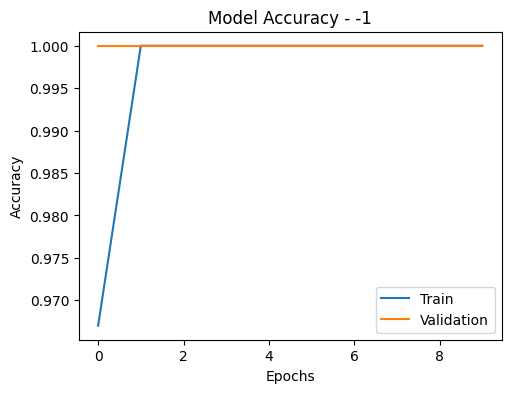

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8728 - loss: 0.5649 - val_accuracy: 0.9520 - val_loss: 0.2615
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9675 - loss: 0.2043 - val_accuracy: 0.9520 - val_loss: 0.2449
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9653 - loss: 0.1795 - val_accuracy: 0.9520 - val_loss: 0.2346
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9607 - loss: 0.1788 - val_accuracy: 0.9520 - val_loss: 0.2373
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9650 - loss: 0.1445 - val_accuracy: 0.9520 - val_loss: 0.2796
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9588 - loss: 0.1394 - val_accuracy: 0.9520 - val_loss: 0.3176
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: value.discounts-promotions, Accuracy: 0.9490, F1 (weighted): 0.9242
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


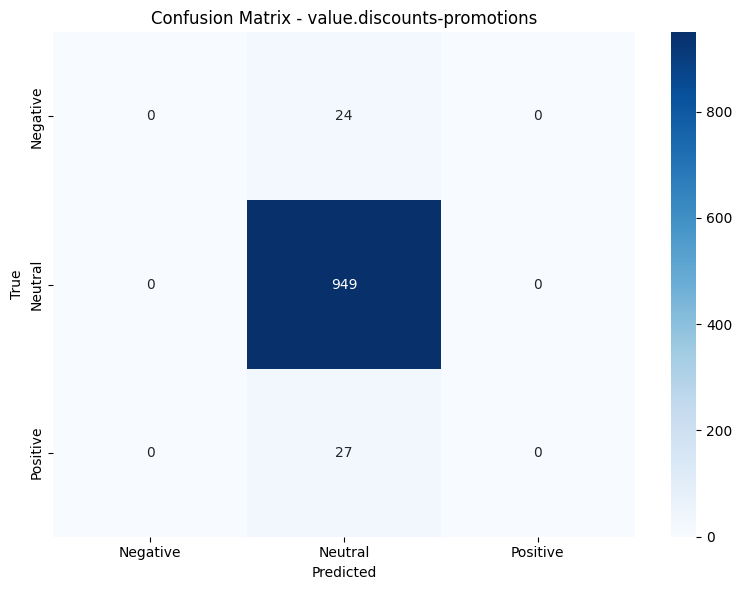

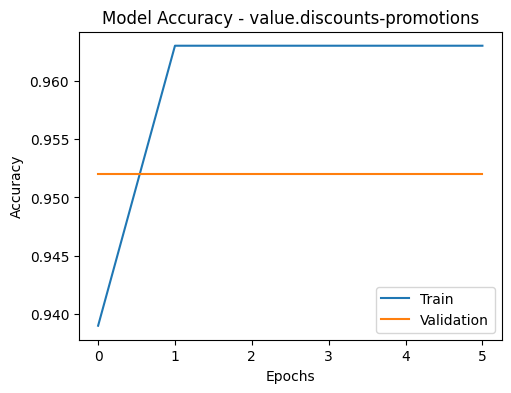

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8915 - loss: 0.4259 - val_accuracy: 1.0000 - val_loss: 4.1811e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.0768e-05 - val_accuracy: 1.0000 - val_loss: 1.1518e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 5.0895e-06 - val_accuracy: 1.0000 - val_loss: 9.4563e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 1.0000 - loss: 2.3024e-06 - val_accuracy: 1.0000 - val_loss: 8.4449e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 2.3794e-06 - val_accuracy: 1.0000 - val_loss: 7.4704e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 5.1464e-06 - val_accuracy: 1.0000 - val_loss: 6.3385e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 8.1178e-07 - val_accuracy: 1.0000 - val_loss: 5.9760e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


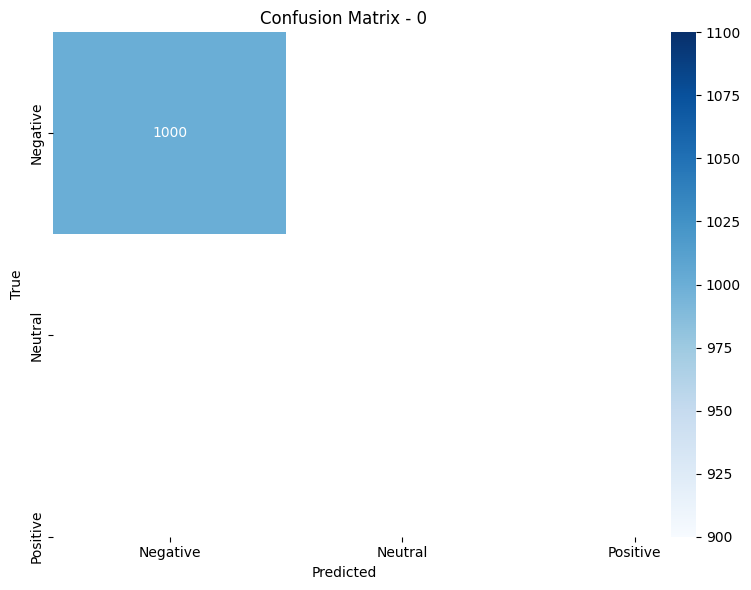

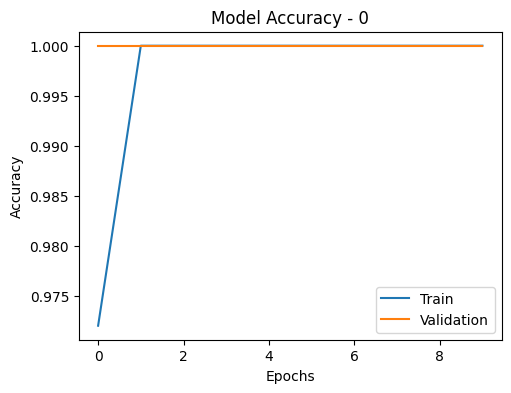

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.8685 - loss: 0.5137 - val_accuracy: 0.9860 - val_loss: 0.0838
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9740 - loss: 0.1544 - val_accuracy: 0.9860 - val_loss: 0.0740
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9865 - loss: 0.0706 - val_accuracy: 0.9860 - val_loss: 0.0880
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9827 - loss: 0.1015 - val_accuracy: 0.9860 - val_loss: 0.0719
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9830 - loss: 0.0909 - val_accuracy: 0.9860 - val_loss: 0.0730
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9844 - loss: 0.0762 - val_accuracy: 0.9860 - val_loss: 0.0765
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9846 - loss: 0.0752 - val_accuracy: 0.9860 - val_loss: 0.0700
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9846 - loss: 0.0567 - val_accuracy: 0.9860 - val_loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category: staff-support.phone, Accuracy: 0.9780, F1 (weighted): 0.9671
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


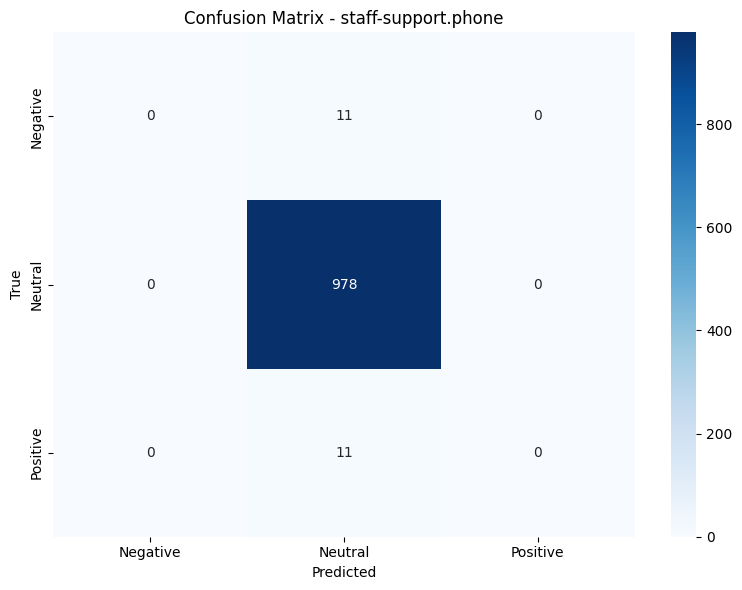

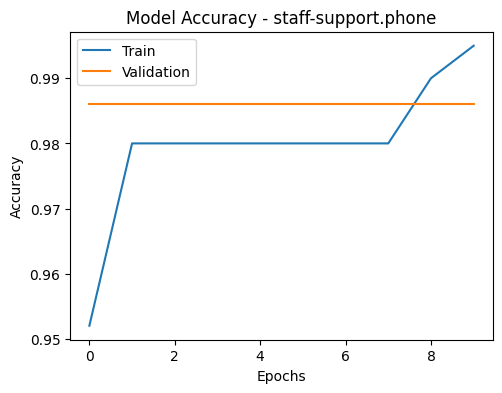

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8760 - loss: 0.4394 - val_accuracy: 1.0000 - val_loss: 5.2988e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 1.0000 - loss: 3.1066e-05 - val_accuracy: 1.0000 - val_loss: 1.8596e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 1.0000 - loss: 9.8254e-06 - val_accuracy: 1.0000 - val_loss: 1.6356e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 1.0000 - loss: 1.0574e-05 - val_accuracy: 1.0000 - val_loss: 1.4605e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 1.0000 - loss: 3.2741e-06 - val_accuracy: 1.0000 - val_loss: 1.3263e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 1.0000 - loss: 3.5082e-06 - val_accuracy: 1.0000 - val_loss: 1.2151e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 1.0000 - loss: 1.8213e-06 - val_accuracy: 1.0000 - val_loss: 1.1514e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


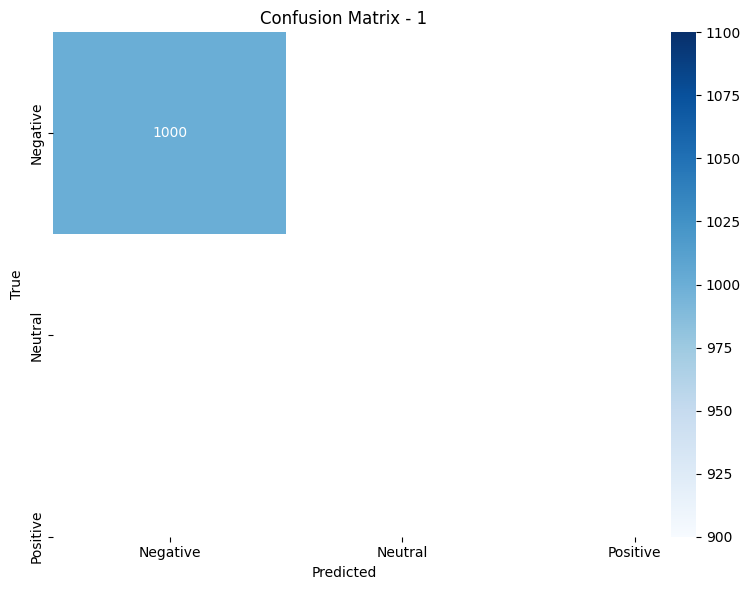

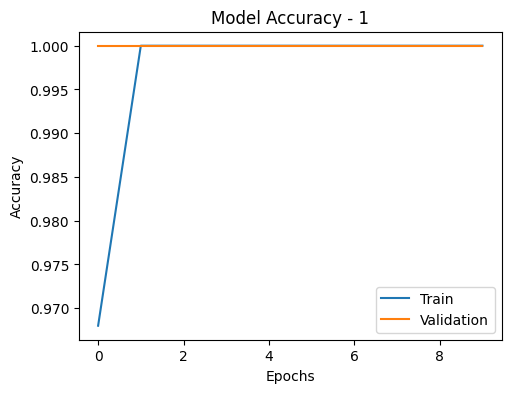

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.8888 - loss: 0.5455 - val_accuracy: 0.9790 - val_loss: 0.1269
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9774 - loss: 0.1329 - val_accuracy: 0.9790 - val_loss: 0.1201
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9737 - loss: 0.1469 - val_accuracy: 0.9790 - val_loss: 0.1476
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9732 - loss: 0.1385 - val_accuracy: 0.9790 - val_loss: 0.1259
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9593 - loss: 0.1695 - val_accuracy: 0.9790 - val_loss: 0.1348
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Category: company-brand.reviews, Accuracy: 0.9760, F1 (weighted): 0.9641
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


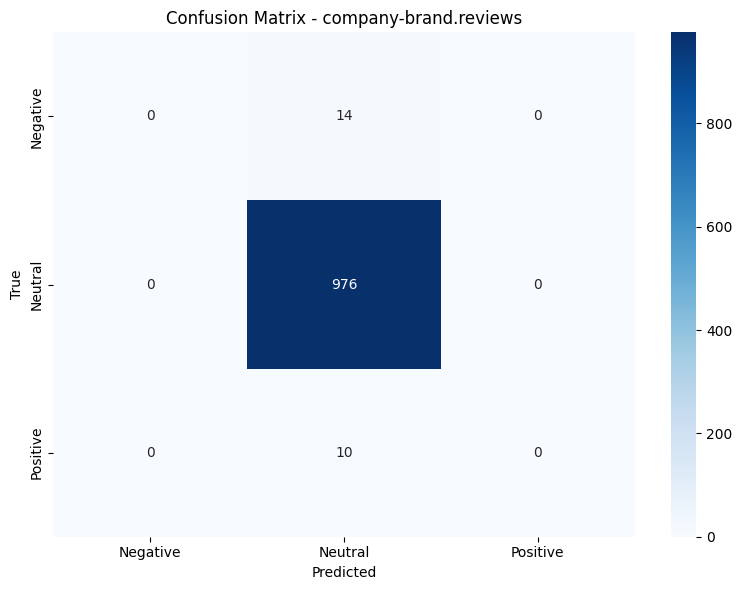

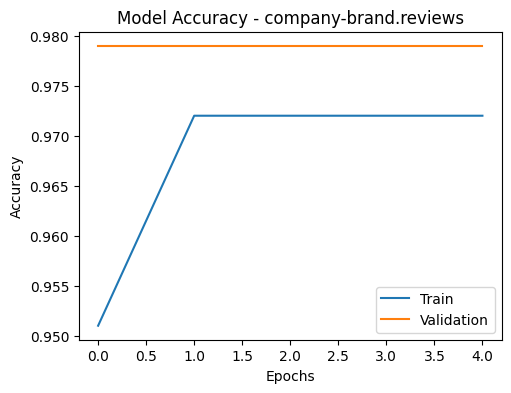

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.9303 - loss: 0.4180 - val_accuracy: 1.0000 - val_loss: 1.8632e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 1.0000 - loss: 5.0110e-06 - val_accuracy: 1.0000 - val_loss: 6.2922e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 1.0000 - loss: 2.0586e-06 - val_accuracy: 1.0000 - val_loss: 5.7692e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 1.0000 - loss: 3.4065e-06 - val_accuracy: 1.0000 - val_loss: 5.5358e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 1.0000 - loss: 8.3419e-07 - val_accuracy: 1.0000 - val_loss: 5.3505e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.0287e-06 - val_accuracy: 1.0000 - val_loss: 5.1816e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.5601e-06 - val_accuracy: 1.0000 - val_loss: 4.9627e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


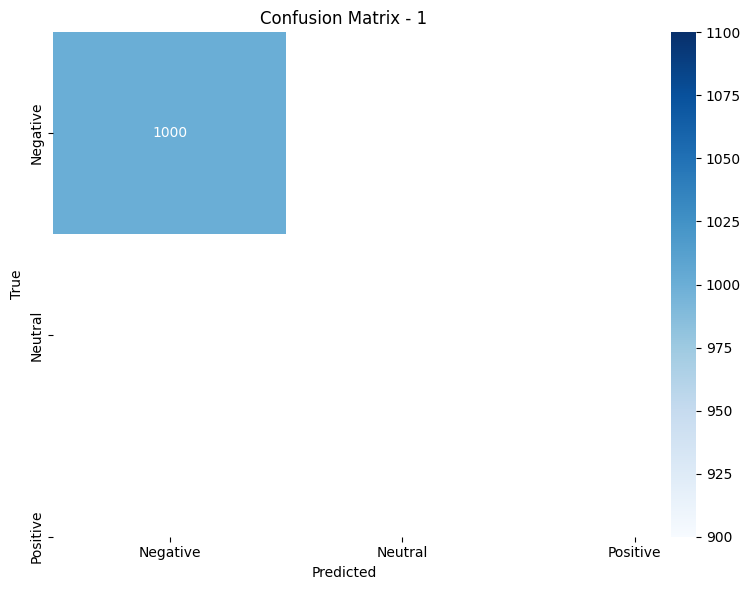

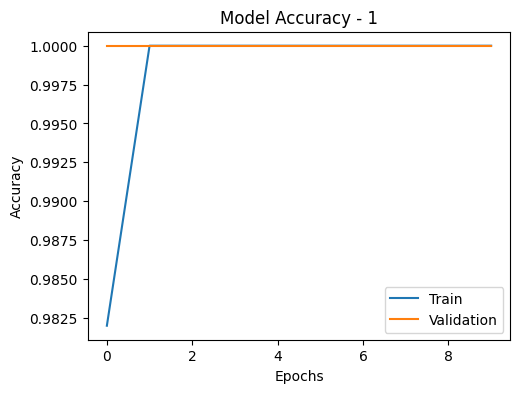

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.8658 - loss: 0.6429 - val_accuracy: 0.9180 - val_loss: 0.3455
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9123 - loss: 0.3672 - val_accuracy: 0.9180 - val_loss: 0.3201
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9364 - loss: 0.2726 - val_accuracy: 0.9180 - val_loss: 0.3335
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9288 - loss: 0.2933 - val_accuracy: 0.9180 - val_loss: 0.3264
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9157 - loss: 0.2921 - val_accuracy: 0.9180 - val_loss: 0.3488
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Category: company-brand.competitor, Accuracy: 0.9210, F1 (weighted): 0.8831
F1 Scores - Negative: 0.0000, Neutral: 0.0000, Positive: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


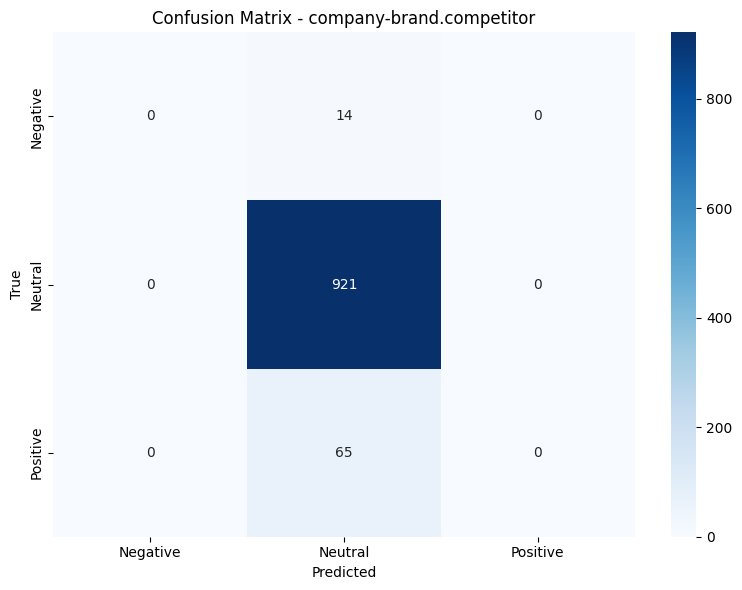

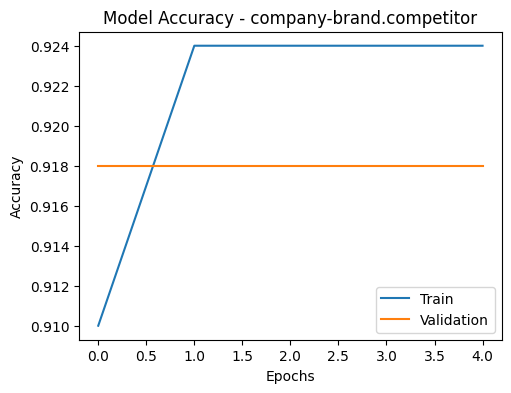

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8799 - loss: 0.4642 - val_accuracy: 1.0000 - val_loss: 4.6695e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 1.0000 - loss: 5.8035e-06 - val_accuracy: 1.0000 - val_loss: 1.6891e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 4.6609e-06 - val_accuracy: 1.0000 - val_loss: 1.5321e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.3246e-05 - val_accuracy: 1.0000 - val_loss: 1.3423e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.4468e-06 - val_accuracy: 1.0000 - val_loss: 1.2342e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 1.5447e-06 - val_accuracy: 1.0000 - val_loss: 1.1756e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 1.0000 - loss: 4.8855e-06 - val_accuracy: 1.0000 - val_loss: 1.1131e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


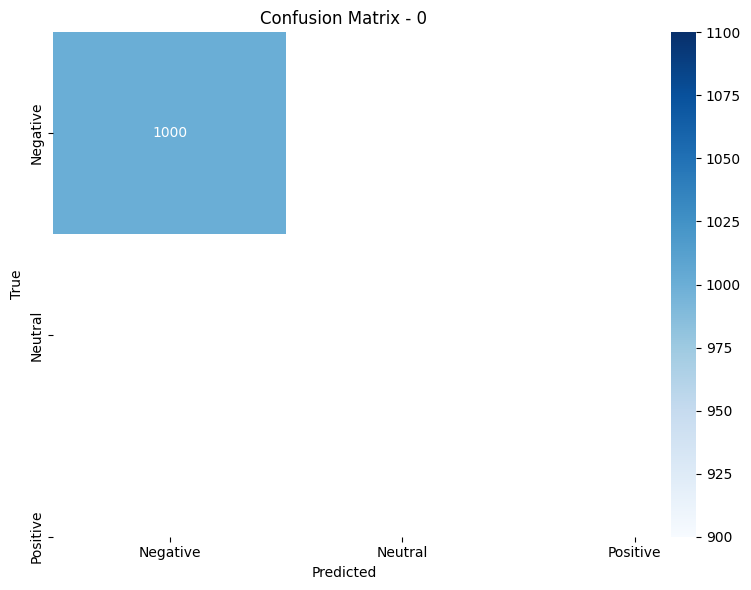

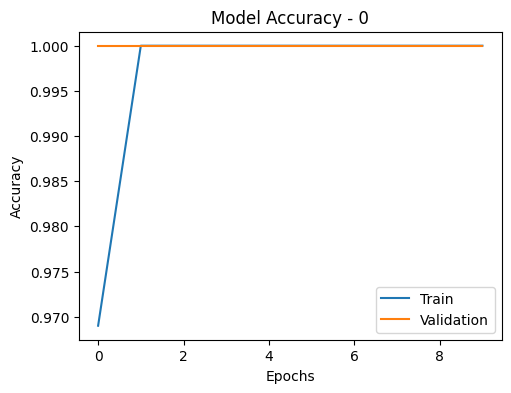

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9177 - loss: 0.4791 - val_accuracy: 0.9870 - val_loss: 0.0719
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9887 - loss: 0.0779 - val_accuracy: 0.9870 - val_loss: 0.0822
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9900 - loss: 0.0527 - val_accuracy: 0.9870 - val_loss: 0.0715
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9879 - loss: 0.0626 - val_accuracy: 0.9870 - val_loss: 0.0719
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9899 - loss: 0.0482 - val_accuracy: 0.9870 - val_loss: 0.0698
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9932 - loss: 0.0421 - val_accuracy: 0.9870 - val_loss: 0.0729
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9902 - loss: 0.0409 - val_accuracy: 0.9870 - val_loss: 0.0794
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9930 - loss: 0.0419 - val_accuracy: 0.9870 - val_loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


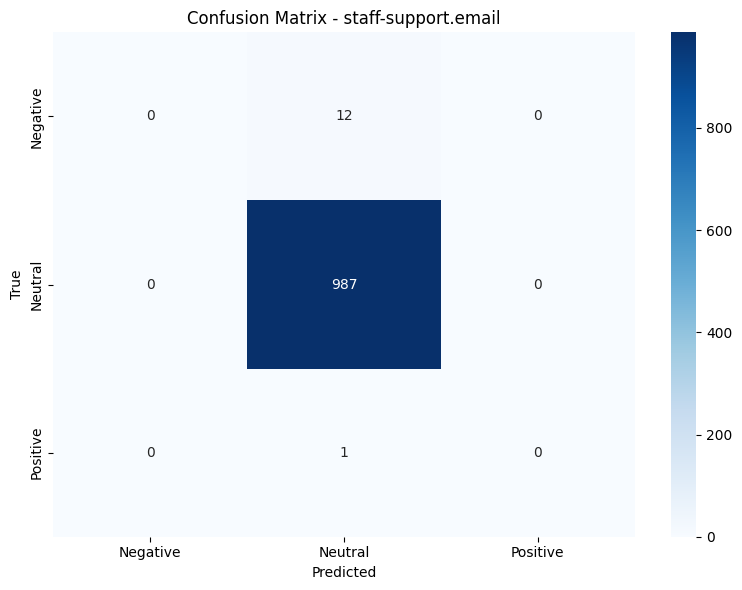

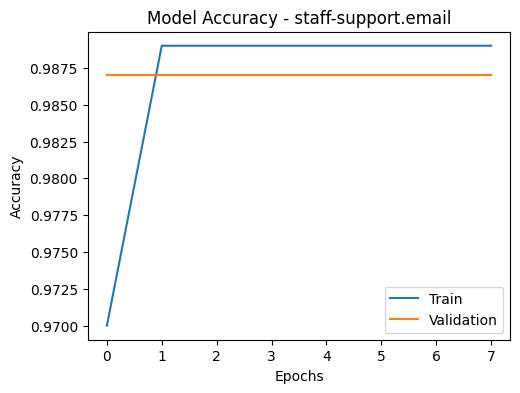

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9303 - loss: 0.4269 - val_accuracy: 1.0000 - val_loss: 1.9857e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 1.0000 - loss: 4.2350e-06 - val_accuracy: 1.0000 - val_loss: 5.8885e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.3830e-06 - val_accuracy: 1.0000 - val_loss: 5.3700e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.8427e-06 - val_accuracy: 1.0000 - val_loss: 5.0770e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 1.0000 - loss: 3.6355e-06 - val_accuracy: 1.0000 - val_loss: 4.7438e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 1.0000 - loss: 6.1745e-06 - val_accuracy: 1.0000 - val_loss: 4.4648e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 2.3811e-06 - val_accuracy: 1.0000 - val_loss: 4.2182e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 1.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


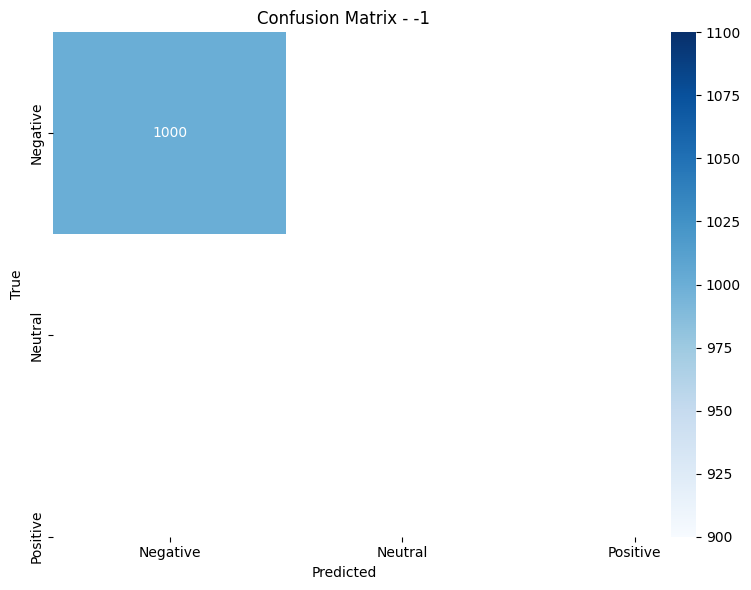

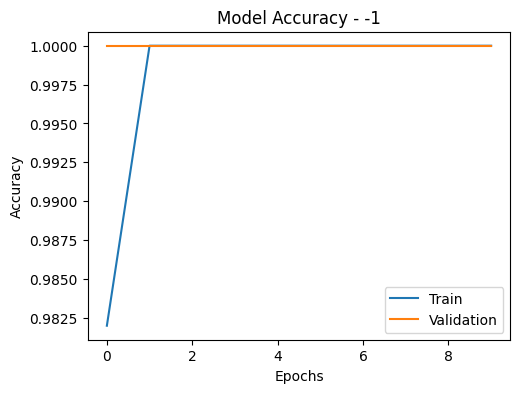

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.8696 - loss: 0.5192 - val_accuracy: 0.9870 - val_loss: 0.1151
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9939 - loss: 0.0382 - val_accuracy: 0.9870 - val_loss: 0.0722
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9849 - loss: 0.0696 - val_accuracy: 0.9870 - val_loss: 0.0741
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9892 - loss: 0.0680 - val_accuracy: 0.9870 - val_loss: 0.0795
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9945 - loss: 0.0423 - val_accuracy: 0.9870 - val_loss: 0.0705
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9930 - loss: 0.0460 - val_accuracy: 0.9870 - val_loss: 0.0735
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9896 - loss: 0.0599 - val_accuracy: 0.9870 - val_loss: 0.0759
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9853 - loss: 0.0637 - val_accuracy: 0.9840 - val_los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


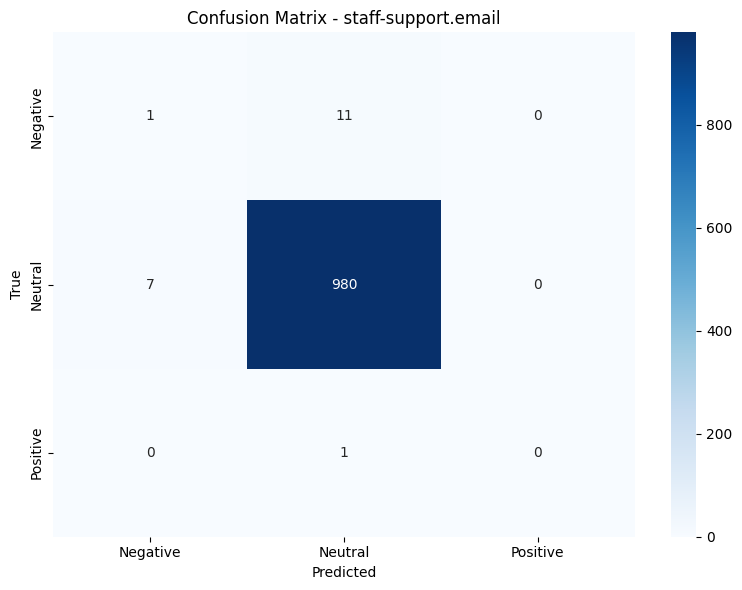

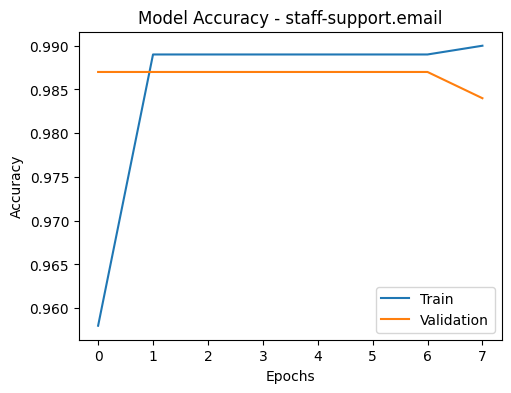

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9613 - loss: 0.3789 - val_accuracy: 1.0000 - val_loss: 2.9329e-06
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 8.3843e-07 - val_accuracy: 1.0000 - val_loss: 8.1847e-07
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.5372e-07 - val_accuracy: 1.0000 - val_loss: 7.5922e-07
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 2.5268e-07 - val_accuracy: 1.0000 - val_loss: 7.4456e-07
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 3.9149e-07 - val_accuracy: 1.0000 - val_loss: 7.2930e-07
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 1.0000 - loss: 6.6465e-07 - val_accuracy: 1.0000 - val_loss: 7.0642e-07
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 1.0000 - loss: 9.6659e-07 - val_accuracy: 1.0000 - val_loss: 6.8925e-07
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


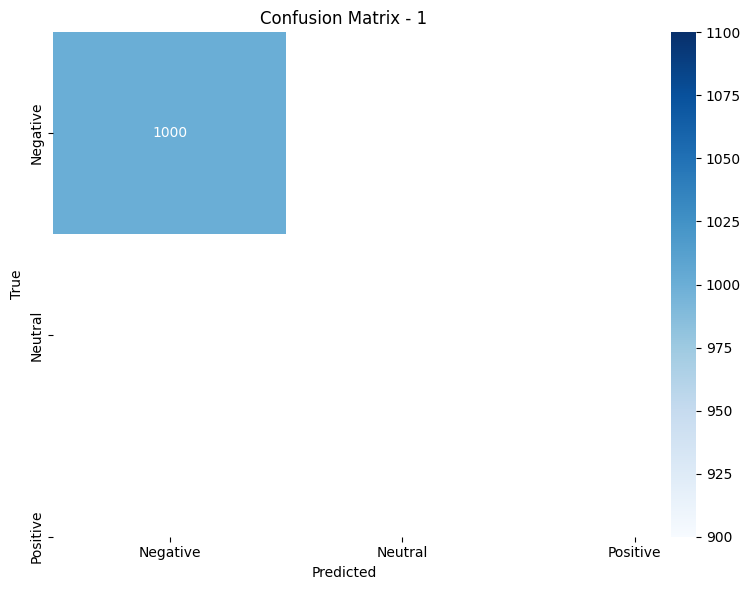

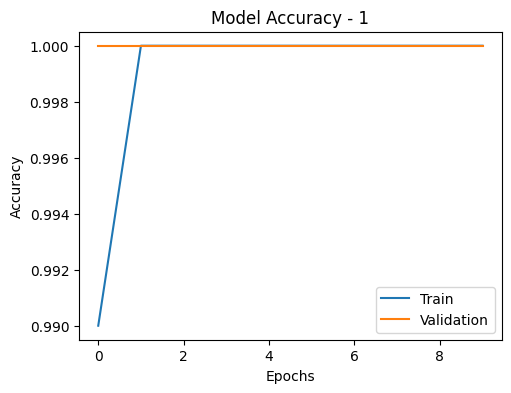

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6435 - loss: 0.9200 - val_accuracy: 0.6850 - val_loss: 0.8146
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.7104 - loss: 0.7586 - val_accuracy: 0.6850 - val_loss: 0.7736
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6993 - loss: 0.7375 - val_accuracy: 0.6850 - val_loss: 0.7342
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7505 - loss: 0.6027 - val_accuracy: 0.8100 - val_loss: 0.5577
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8745 - loss: 0.3794 - val_accuracy: 0.7880 - val_loss: 0.5892
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9194 - loss: 0.2521 - val_accuracy: 0.8020 - val_loss: 0.6650
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9461 - loss: 0.1533 - val_accuracy: 0.7880 - val_loss: 0.7593
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Category: purchase-booking-experience.ease-of-use, Accuracy: 0.7540, F1 (weigh

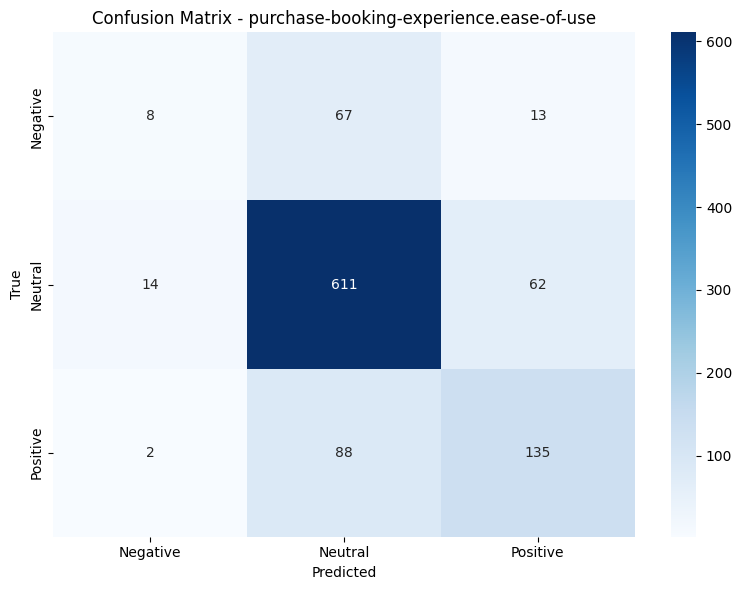

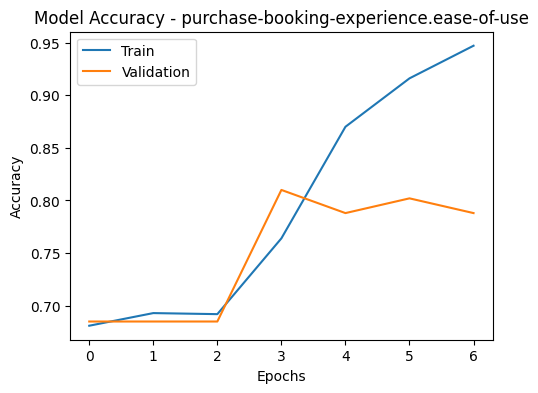

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.8838 - loss: 0.4804 - val_accuracy: 1.0000 - val_loss: 2.1966e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 1.0000 - loss: 6.0194e-05 - val_accuracy: 1.0000 - val_loss: 6.2662e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 1.0000 - loss: 2.3686e-05 - val_accuracy: 1.0000 - val_loss: 4.7918e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 1.0000 - loss: 2.1922e-05 - val_accuracy: 1.0000 - val_loss: 3.9316e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 2.4497e-05 - val_accuracy: 1.0000 - val_loss: 3.0427e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 1.0000 - loss: 6.0616e-06 - val_accuracy: 1.0000 - val_loss: 2.6896e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 1.0000 - loss: 4.5424e-06 - val_accuracy: 1.0000 - val_loss: 2.4076e-05
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 1.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


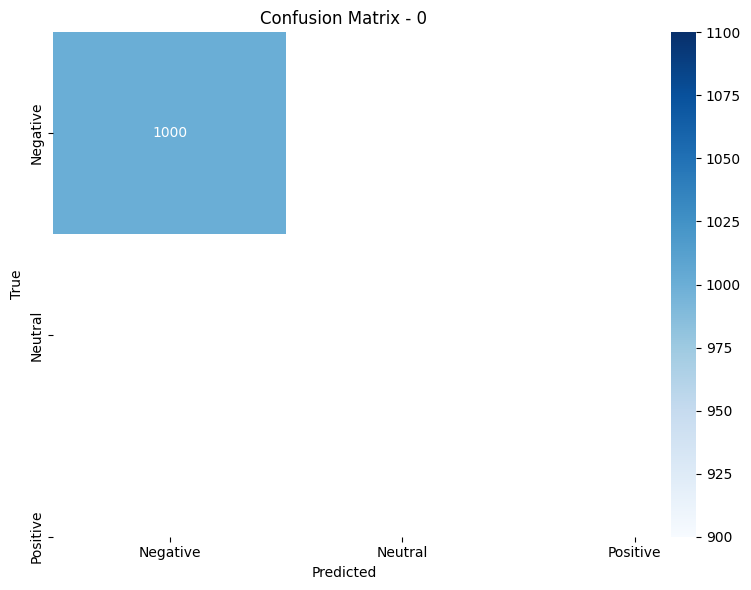

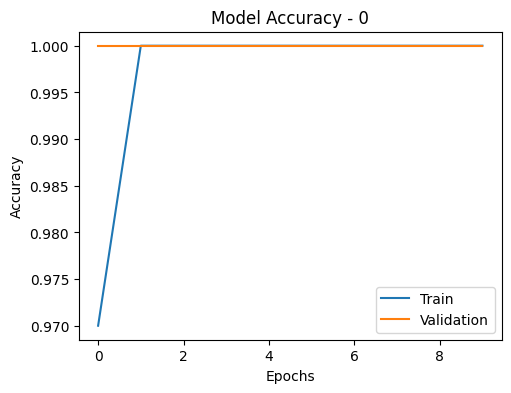

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8667 - loss: 0.5187 - val_accuracy: 0.9860 - val_loss: 0.0930
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9842 - loss: 0.0948 - val_accuracy: 0.9860 - val_loss: 0.0849
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9808 - loss: 0.1059 - val_accuracy: 0.9860 - val_loss: 0.0862
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9842 - loss: 0.0963 - val_accuracy: 0.9860 - val_loss: 0.0712
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9809 - loss: 0.1040 - val_accuracy: 0.9860 - val_loss: 0.0697
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9833 - loss: 0.0801 - val_accuracy: 0.9860 - val_loss: 0.0751
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9847 - loss: 0.0742 - val_accuracy: 0.9860 - val_loss: 0.0753
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9836 - loss: 0.0580 - val_accuracy: 0.9860 - val_los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


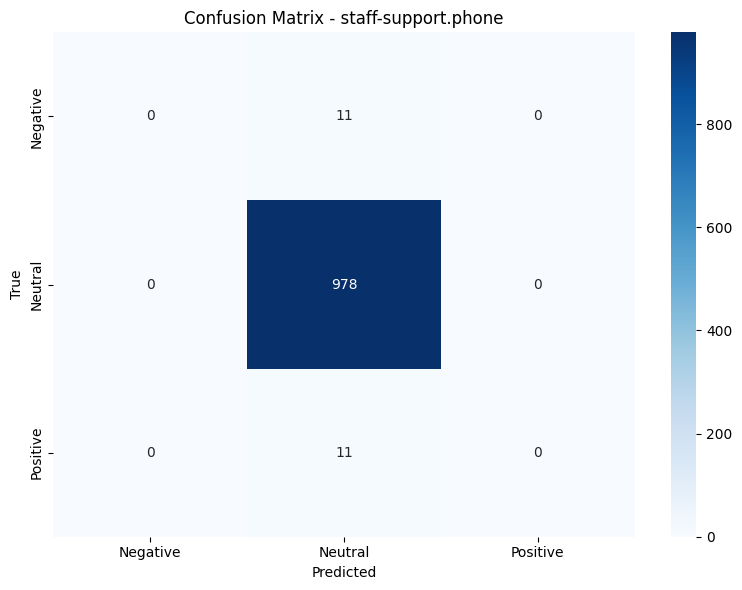

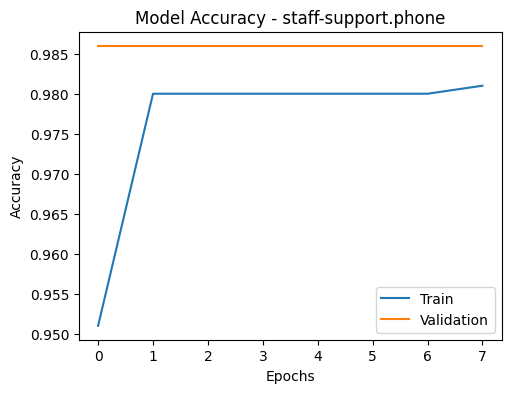

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9961 - loss: 0.3740 - val_accuracy: 1.0000 - val_loss: 1.7386e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.3054e-05 - val_accuracy: 1.0000 - val_loss: 6.0557e-06
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 3.2143e-06 - val_accuracy: 1.0000 - val_loss: 5.5143e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3071e-06 - val_accuracy: 1.0000 - val_loss: 5.3033e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 1.0000 - loss: 2.3945e-06 - val_accuracy: 1.0000 - val_loss: 5.0236e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 1.0000 - loss: 1.6069e-06 - val_accuracy: 1.0000 - val_loss: 4.7146e-06
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 1.0000 - loss: 1.5467e-06 - val_accuracy: 1.0000 - val_loss: 4.4222e-06
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


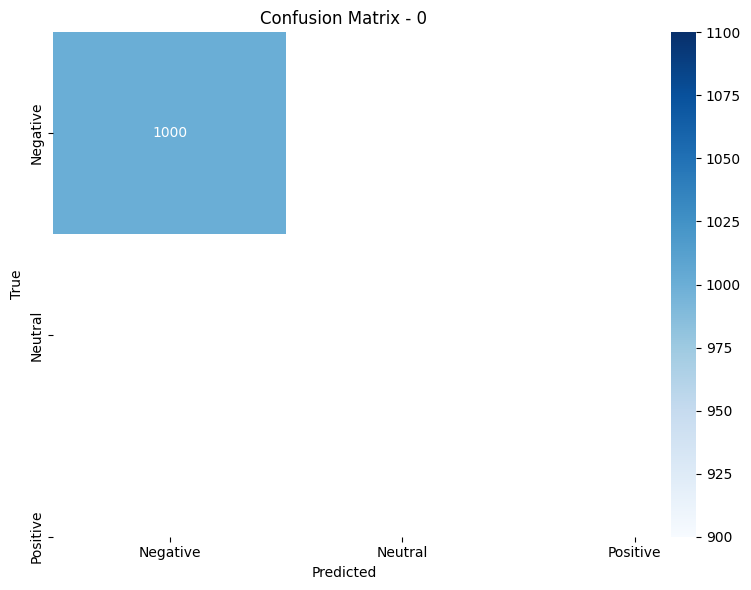

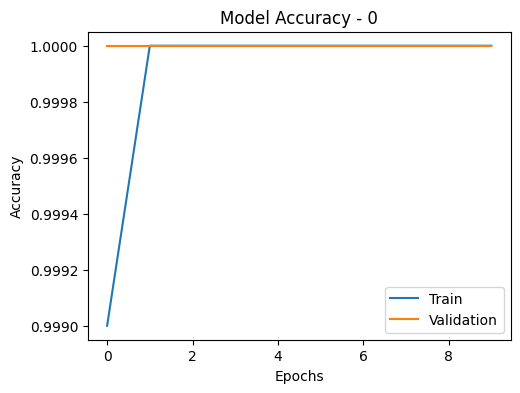

In [ ]:
# Step 6: Prepare data for deep learning models
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert to pandas for easier processing
train_pandas = dfs_train_with_sentiment.toPandas()
test_pandas = dfs_test_with_sentiment.toPandas()
validation_pandas = dfs_validation_with_sentiment.toPandas()

# Tokenize text
keras_tokenizer = KerasTokenizer(num_words=10000)
keras_tokenizer.fit_on_texts(train_pandas['text'])

# Convert text to sequences
train_sequences = keras_tokenizer.texts_to_sequences(train_pandas['text'])
test_sequences = keras_tokenizer.texts_to_sequences(test_pandas['text'])
validation_sequences = keras_tokenizer.texts_to_sequences(validation_pandas['text'])

# Pad sequences
max_seq_length = 100
train_data = pad_sequences(train_sequences, maxlen=max_seq_length)
test_data = pad_sequences(test_sequences, maxlen=max_seq_length)
validation_data = pad_sequences(validation_sequences, maxlen=max_seq_length)

# Deep learning model results
dl_sentiment_results = {}

# For each category, train a deep learning model
for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')

    # Create y labels
    # 0: negative, 1: neutral, 2: positive
    def create_sentiment_labels(df, category_col):
        neg_col = f"{category_col}_negative"
        neu_col = f"{category_col}_neutral"
        pos_col = f"{category_col}_positive"

        y = np.zeros(len(df))
        y[df[neg_col] == 1] = 0
        y[df[neu_col] == 1] = 1
        y[df[pos_col] == 1] = 2
        # Default to neutral if no sentiment is available
        y[(df[neg_col] == 0) & (df[neu_col] == 0) & (df[pos_col] == 0)] = 1

        return y

    y_train = create_sentiment_labels(train_pandas, clean_cat)
    y_test = create_sentiment_labels(test_pandas, clean_cat)
    y_val = create_sentiment_labels(validation_pandas, clean_cat)

    # Convert to one-hot encoding
    y_train_one_hot = tf.keras.utils.to_categorical(y_train, 3)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, 3)
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, 3)

    # Build CNN model
    vocab_size = min(10000, len(keras_tokenizer.word_index) + 1)
    embedding_dim = 100

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))  # 3 classes: negative, neutral, positive

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train with early stopping
    from tensorflow.keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(
        train_data, y_train_one_hot,
        validation_data=(validation_data, y_val_one_hot),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping]
    )

    # Evaluate
    y_pred_probs = model.predict(test_data)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    dl_sentiment_results[category] = {
        "accuracy": accuracy,
        "f1_neg": report['0']['f1-score'] if '0' in report else 0,
        "f1_neu": report['1']['f1-score'] if '1' in report else 0,
        "f1_pos": report['2']['f1-score'] if '2' in report else 0,
        "f1_weighted": report['weighted avg']['f1-score']
    }

    print(f"Category: {category}, Accuracy: {accuracy:.4f}, F1 (weighted): {report['weighted avg']['f1-score']:.4f}")
    print(f"F1 Scores - Negative: {report['0']['f1-score'] if '0' in report else 0:.4f}, " +
          f"Neutral: {report['1']['f1-score'] if '1' in report else 0:.4f}, " +
          f"Positive: {report['2']['f1-score'] if '2' in report else 0:.4f}")

    # Plot confusion matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix - {category}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{clean_cat}.png', dpi=300)
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Model Accuracy - {category}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
Further charts

In [ ]:
# Step 8: Perform cross-category sentiment analysis
def analyze_cross_category_sentiment_correlation(df, all_categories):
    """Analyze correlation between sentiment predictions across different categories"""
    # Create a dataframe with sentiment scores for each category
    sentiment_scores = {}

    for category in all_categories:
        clean_cat = category.replace('-', '_').replace('.', '_')
        neg_col = f"{clean_cat}_negative"
        neu_col = f"{clean_cat}_neutral"
        pos_col = f"{clean_cat}_positive"

        # If the columns exist, calculate a simple sentiment score
        if neg_col in df.columns and neu_col in df.columns and pos_col in df.columns:
            # Convert to numeric sentiment score: -1 for negative, 0 for neutral, 1 for positive
            df[f"{clean_cat}_score"] = df[pos_col].astype(int) - df[neg_col].astype(int)
            sentiment_scores[category] = f"{clean_cat}_score"

    # Create correlation matrix
    score_columns = list(sentiment_scores.values())
    if len(score_columns) > 1:
        correlation_matrix = df[score_columns].corr()

        # Plot heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                    mask=mask, vmin=-1, vmax=1, center=0,
                    xticklabels=sentiment_scores.keys(),
                    yticklabels=sentiment_scores.keys())
        plt.title('Cross-Category Sentiment Correlation', fontsize=16)
        plt.tight_layout()
        plt.savefig('sentiment_correlation_heatmap.png', dpi=300)
        plt.show()

        return correlation_matrix
    return None

# Analyze cross-category correlations
correlation_matrix = analyze_cross_category_sentiment_correlation(train_pandas, all_categories)

# Step 9: Error analysis
def perform_error_analysis(model, tokenizer, texts, true_labels, category, label_names=['Negative', 'Neutral', 'Positive']):
    """Perform error analysis on incorrect predictions"""
    # Make predictions
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    predictions = model.predict(padded_sequences)
    pred_labels = np.argmax(predictions, axis=1)

    # Find incorrect predictions
    incorrect_indices = np.where(pred_labels != true_labels)[0]

    if len(incorrect_indices) == 0:
        print(f"No incorrect predictions found for {category}")
        return

    # Sample up to 10 incorrect predictions
    sample_size = min(10, len(incorrect_indices))
    sample_indices = np.random.choice(incorrect_indices, size=sample_size, replace=False)

    # Create a dataframe for analysis
    error_df = pd.DataFrame({
        'Text': [texts[i] for i in sample_indices],
        'True Label': [label_names[true_labels[i]] for i in sample_indices],
        'Predicted Label': [label_names[pred_labels[i]] for i in sample_indices],
        'Confidence': [np.max(predictions[i]) for i in sample_indices]
    })

    # Create and plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix for {category}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{category}.png', dpi=300)
    plt.show()

    # Print error analysis
    print(f"\n--- Error Analysis for {category} ---")
    print(f"Total samples: {len(texts)}")
    print(f"Incorrect predictions: {len(incorrect_indices)} ({len(incorrect_indices)/len(texts)*100:.2f}%)")
    print("\nSample of incorrect predictions:")
    print(error_df)

    return error_df

# Perform error analysis for a few selected categories
selected_categories = all_categories[:3]  # Choose first 3 categories for analysis
for category in selected_categories:
    # Get test data for this category
    # Note: You would need to extract test data for each category
    # This is a placeholder - adapt to your data structure
    test_texts = test_texts_by_category.get(category, [])
    test_labels = test_labels_by_category.get(category, [])

    if len(test_texts) > 0:
        perform_error_analysis(model, keras_tokenizer, test_texts, test_labels, category)

# Step 10: Analyze prediction confidence
def analyze_prediction_confidence(model, tokenizer, texts, true_labels, category):
    """Analyze prediction confidence and its relationship with accuracy"""
    # Make predictions
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    predictions = model.predict(padded_sequences)
    pred_labels = np.argmax(predictions, axis=1)

    # Get confidence of predictions (max probability)
    confidences = np.max(predictions, axis=1)

    # Create a dataframe
    confidence_df = pd.DataFrame({
        'Confidence': confidences,
        'Correct': pred_labels == true_labels
    })

    # Plot confidence distribution
    plt.figure(figsize=(12, 8))

    # Overall confidence distribution
    plt.subplot(2, 2, 1)
    sns.histplot(confidences, bins=20, kde=True)
    plt.title(f'Prediction Confidence Distribution - {category}')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    # Confidence by correctness
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Correct', y='Confidence', data=confidence_df)
    plt.title('Confidence by Prediction Correctness')
    plt.xlabel('Prediction Correct')
    plt.ylabel('Confidence')

    # Accuracy by confidence bucket
    plt.subplot(2, 2, 3)
    confidence_df['ConfidenceBucket'] = pd.cut(confidence_df['Confidence'], bins=10)
    accuracy_by_bucket = confidence_df.groupby('ConfidenceBucket')['Correct'].mean()

    sns.barplot(x=accuracy_by_bucket.index.astype(str), y=accuracy_by_bucket.values)
    plt.title('Accuracy by Confidence Range')
    plt.xlabel('Confidence Range')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    # Count by confidence bucket
    plt.subplot(2, 2, 4)
    count_by_bucket = confidence_df.groupby('ConfidenceBucket').size()
    sns.barplot(x=count_by_bucket.index.astype(str), y=count_by_bucket.values)
    plt.title('Sample Count by Confidence Range')
    plt.xlabel('Confidence Range')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f'confidence_analysis_{category}.png', dpi=300)
    plt.show()

    return confidence_df

# Analyze prediction confidence for selected categories
for category in selected_categories:
    test_texts = test_texts_by_category.get(category, [])
    test_labels = test_labels_by_category.get(category, [])

    if len(test_texts) > 0:
        analyze_prediction_confidence(model, keras_tokenizer, test_texts, test_labels, category)

# Step 11: Text length vs accuracy analysis
def analyze_text_length_vs_accuracy(model, tokenizer, texts, true_labels, category):
    """Analyze the relationship between text length and prediction accuracy"""
    # Make predictions
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    predictions = model.predict(padded_sequences)
    pred_labels = np.argmax(predictions, axis=1)

    # Calculate text lengths
    text_lengths = [len(text.split()) for text in texts]

    # Create dataframe
    length_df = pd.DataFrame({
        'TextLength': text_lengths,
        'Correct': pred_labels == true_labels
    })

    # Create length buckets
    length_df['LengthBucket'] = pd.cut(length_df['TextLength'], bins=10)

    # Calculate accuracy by length bucket
    accuracy_by_length = length_df.groupby('LengthBucket')['Correct'].mean()
    count_by_length = length_df.groupby('LengthBucket').size()

    # Plot
    plt.figure(figsize=(12, 8))

    # Text length distribution
    plt.subplot(2, 2, 1)
    sns.histplot(text_lengths, bins=20, kde=True)
    plt.title(f'Text Length Distribution - {category}')
    plt.xlabel('Text Length (words)')
    plt.ylabel('Count')

    # Text length vs accuracy (scatter)
    plt.subplot(2, 2, 2)
    sns.scatterplot(x='TextLength', y='Correct', data=length_df, alpha=0.3)
    plt.title('Text Length vs Prediction Correctness')
    plt.xlabel('Text Length (words)')
    plt.ylabel('Prediction Correct')

    # Accuracy by length bucket
    plt.subplot(2, 2, 3)
    sns.barplot(x=accuracy_by_length.index.astype(str), y=accuracy_by_length.values)
    plt.title('Accuracy by Text Length Range')
    plt.xlabel('Text Length Range')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    # Count by length bucket
    plt.subplot(2, 2, 4)
    sns.barplot(x=count_by_length.index.astype(str), y=count_by_length.values)
    plt.title('Sample Count by Text Length Range')
    plt.xlabel('Text Length Range')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f'length_analysis_{category}.png', dpi=300)
    plt.show()

    return length_df

# Analyze text length vs accuracy for selected categories
for category in selected_categories:
    test_texts = test_texts_by_category.get(category, [])
    test_labels = test_labels_by_category.get(category, [])

    if len(test_texts) > 0:
        analyze_text_length_vs_accuracy(model, keras_tokenizer, test_texts, test_labels, category)

# Step 12: Create interactive dashboard (optional - if using in a Jupyter notebook)
# Note: This requires ipywidgets and is best used in a Jupyter environment
try:
    import ipywidgets as widgets
    from IPython.display import display

    # Create category selector
    category_dropdown = widgets.Dropdown(
        options=all_categories,
        description='Category:',
        disabled=False,
    )

    # Create visualization type selector
    viz_dropdown = widgets.Dropdown(
        options=['Performance Metrics', 'Confusion Matrix', 'Important Words', 'Error Examples'],
        description='Visualization:',
        disabled=False,
    )

    # Function to update visualization based on selections
    def update_visualization(category, viz_type):
        if viz_type == 'Performance Metrics':
            # Display performance metrics for selected category
            if category in dl_sentiment_results:
                metrics = dl_sentiment_results[category]
                print(f"Performance metrics for {category}:")
                for metric, value in metrics.items():
                    print(f"  {metric}: {value:.4f}")

        elif viz_type == 'Confusion Matrix':
            # Display confusion matrix for selected category
            test_texts = test_texts_by_category.get(category, [])
            test_labels = test_labels_by_category.get(category, [])

            if len(test_texts) > 0:
                # Make predictions
                sequences = keras_tokenizer.texts_to_sequences(test_texts)
                padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
                predictions = model.predict(padded_sequences)
                pred_labels = np.argmax(predictions, axis=1)

                # Create and plot confusion matrix
                cm = confusion_matrix(test_labels, pred_labels)
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Negative', 'Neutral', 'Positive'],
                            yticklabels=['Negative', 'Neutral', 'Positive'])
                plt.title(f'Confusion Matrix for {category}')
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.show()

        elif viz_type == 'Important Words':
            # Display important words for each sentiment
            for sentiment_class in range(3):
                visualize_important_words_for_sentiment(model, keras_tokenizer, category, sentiment_class)

        elif viz_type == 'Error Examples':
            # Display error examples
            test_texts = test_texts_by_category.get(category, [])
            test_labels = test_labels_by_category.get(category, [])

            if len(test_texts) > 0:
                perform_error_analysis(model, keras_tokenizer, test_texts, test_labels, category)

    # Create interactive output
    interactive_output = widgets.interactive_output(
        update_visualization,
        {'category': category_dropdown, 'viz_type': viz_dropdown}
    )

    # Display widgets
    display(widgets.HBox([category_dropdown, viz_dropdown]))
    display(interactive_output)

except ImportError:
    print("Interactive visualizations require ipywidgets. Install with: pip install ipywidgets")

# Step 13: Save model results summary to file
def save_results_summary(ml_results, dl_results, filename='sentiment_analysis_results.csv'):
    """Save a summary of results to CSV file"""
    results_data = []

    # Combine results from both models
    for category in all_categories:
        row = {'Category': category}

        # Add ML results if available
        if category in ml_results:
            for metric, value in ml_results[category].items():
                row[f'ML_{metric}'] = value

        # Add DL results if available
        if category in dl_results:
            for metric, value in dl_results[category].items():
                row[f'DL_{metric}'] = value

        results_data.append(row)

    # Convert to DataFrame and save
    results_df = pd.DataFrame(results_data)
    results_df.to_csv(filename, index=False)

END OF ACSA

ACD ANALYSIS

INSERT 0

In [ ]:
from pyspark.sql.functions import col, array_contains, explode, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

# Step 1: Extract and clean categories (same as before)
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [code.rsplit('.', 1)[0] for code in codes]
    return []

# Apply the UDF to extract categories
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Step 2: Get all unique categories with consistent naming
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

# Step 3: Create binary indicator columns (same as before)
for category in all_categories:
    # Use the original category name in the column name to avoid confusion
    col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
    dfs_train_clean = dfs_train_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames (same as before)
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Step 4: TF-IDF Features for traditional ML model (SVM)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=2)

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)
train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)
idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Step 5: Prepare data for deep learning models (CNN and LSTM)
# Convert to pandas for easier processing
train_pandas = dfs_train_clean.toPandas()
test_pandas = dfs_test_clean.toPandas()
validation_pandas = dfs_validation_clean.toPandas()

# Prepare text data for deep learning models
keras_tokenizer = KerasTokenizer(num_words=10000)
keras_tokenizer.fit_on_texts(train_pandas['text'])

# Convert text to sequences
train_sequences = keras_tokenizer.texts_to_sequences(train_pandas['text'])
test_sequences = keras_tokenizer.texts_to_sequences(test_pandas['text'])
validation_sequences = keras_tokenizer.texts_to_sequences(validation_pandas['text'])

# Pad sequences to ensure uniform length
max_seq_length = 100
train_data = pad_sequences(train_sequences, maxlen=max_seq_length)
test_data = pad_sequences(test_sequences, maxlen=max_seq_length)
validation_data = pad_sequences(validation_sequences, maxlen=max_seq_length)

# Prepare multi-label targets for deep learning
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]
train_labels = train_pandas[feature_cols].values
test_labels = test_pandas[feature_cols].values
validation_labels = validation_pandas[feature_cols].values

# Step 6: Build and train different models

# 6.1: SVM Model for each category (similar to previous code)
svm_results = {}

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    col_name = f"has_{clean_cat}"

    # Create label column for this specific category
    train_data_svm = train_tfidf.withColumn("label", col(col_name))
    test_data_svm = test_tfidf.withColumn("label", col(col_name))

    # Use only TF-IDF features for prediction
    assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")
    train_assembled = assembler.transform(train_data_svm).select("features", "label")
    test_assembled = assembler.transform(test_data_svm).select("features", "label")

    # Train binary classifier
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1)
    svm_model = svm.fit(train_assembled)

    # Make predictions
    predictions = svm_model.transform(test_assembled)

    # Evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

    svm_results[category] = {"f1": f1, "precision": precision, "recall": recall}
    print(f"SVM - Category: {category}, F1: {f1}, Precision: {precision}, Recall: {recall}")

# 6.2: CNN Model for multi-label classification
def build_cnn_model(vocab_size, embedding_dim, max_length, num_categories):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_categories, activation='sigmoid'))  # Sigmoid for multi-label
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build and train CNN model
vocab_size = min(10000, len(keras_tokenizer.word_index) + 1)
embedding_dim = 100
num_categories = len(all_categories)

cnn_model = build_cnn_model(vocab_size, embedding_dim, max_seq_length, num_categories)
print(cnn_model.summary())

# Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history_cnn = cnn_model.fit(
    train_data, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping]
)

# Evaluate CNN model
cnn_predictions = cnn_model.predict(test_data)
cnn_predictions_binary = (cnn_predictions > 0.5).astype(int)

# Calculate metrics for CNN
cnn_results = {}
for i, category in enumerate(all_categories):
    f1 = f1_score(test_labels[:, i], cnn_predictions_binary[:, i])
    report = classification_report(test_labels[:, i], cnn_predictions_binary[:, i], output_dict=True)
    cnn_results[category] = {
        "f1": f1,
        "precision": report['1']['precision'] if 1 in report else 0,
        "recall": report['1']['recall'] if 1 in report else 0
    }
    print(f"CNN - Category: {category}, F1: {f1}")

# 6.3: LSTM Model for multi-label classification
def build_lstm_model(vocab_size, embedding_dim, max_length, num_categories):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_categories, activation='sigmoid'))  # Sigmoid for multi-label
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build and train LSTM model
lstm_model = build_lstm_model(vocab_size, embedding_dim, max_seq_length, num_categories)
print(lstm_model.summary())

# Train with early stopping
history_lstm = lstm_model.fit(
    train_data, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping]
)

# Evaluate LSTM model
lstm_predictions = lstm_model.predict(test_data)
lstm_predictions_binary = (lstm_predictions > 0.5).astype(int)

# Calculate metrics for LSTM
lstm_results = {}
for i, category in enumerate(all_categories):
    f1 = f1_score(test_labels[:, i], lstm_predictions_binary[:, i])
    report = classification_report(test_labels[:, i], lstm_predictions_binary[:, i], output_dict=True)
    lstm_results[category] = {
        "f1": f1,
        "precision": report['1']['precision'] if 1 in report else 0,
        "recall": report['1']['recall'] if 1 in report else 0
    }
    print(f"LSTM - Category: {category}, F1: {f1}")

# Step 7: Visualize and compare model performance
def plot_model_comparison(svm_results, cnn_results, lstm_results, all_categories):
    # Prepare data
    categories = [cat.replace('-', '_').replace('.', '_') for cat in all_categories]
    svm_f1 = [svm_results[cat]['f1'] for cat in all_categories]
    cnn_f1 = [cnn_results[cat]['f1'] for cat in all_categories]
    lstm_f1 = [lstm_results[cat]['f1'] for cat in all_categories]

    # Sort by average F1 score
    avg_f1 = [(svm_f1[i] + cnn_f1[i] + lstm_f1[i])/3 for i in range(len(all_categories))]
    indices = np.argsort(avg_f1)[::-1]

    categories = [categories[i] for i in indices]
    svm_f1 = [svm_f1[i] for i in indices]
    cnn_f1 = [cnn_f1[i] for i in indices]
    lstm_f1 = [lstm_f1[i] for i in indices]

    # Plot
    x = np.arange(len(categories))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.bar(x - width, svm_f1, width, label='SVM', color='#4e79a7')
    ax.bar(x, cnn_f1, width, label='CNN', color='#f28e2b')
    ax.bar(x + width, lstm_f1, width, label='LSTM', color='#59a14f')

    ax.set_xlabel('Categories', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('Model Performance Comparison by Category', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=60, ha='right')
    ax.set_ylim(0, 1.0)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()

# Plot training history for deep learning models
def plot_training_history(history_cnn, history_lstm):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # CNN training history
    ax1.plot(history_cnn.history['accuracy'], label='Train Accuracy')
    ax1.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('CNN Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(linestyle='--', alpha=0.7)

    # LSTM training history
    ax2.plot(history_lstm.history['accuracy'], label='Train Accuracy')
    ax2.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('LSTM Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

# Execute visualization functions
plot_model_comparison(svm_results, cnn_results, lstm_results, all_categories)
plot_training_history(history_cnn, history_lstm)


INSERT ABSA

In [ ]:
# Step 1: Extract and clean categories - use a consistent naming convention
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [code.rsplit('.', 1)[0] for code in codes]
    return []

# Apply the UDF to extract categories
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Step 2: Get all unique categories with consistent naming
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

# Step 3: Create binary indicator columns with consistent naming
for category in all_categories:
    # Use the original category name in the column name to avoid confusion
    col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
    dfs_train_clean = dfs_train_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()
dfs_train_clean.show(10)

# Step 4: Text vectorization with TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=2)

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)
train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)
idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Step 5: Select the correct feature columns based on the actual column names
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Step 6: Build a multi-label classifier for each category
# For each category, train a separate binary classifier
results = {}

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    col_name = f"has_{clean_cat}"

    # Create label column for this specific category
    train_data = train_tfidf.withColumn("label", col(col_name))
    test_data = test_tfidf.withColumn("label", col(col_name))

    # Use only TF-IDF features for prediction
    assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")
    train_assembled = assembler.transform(train_data).select("features", "label")
    test_assembled = assembler.transform(test_data).select("features", "label")

    # Train binary classifier
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1)
    svm_model = svm.fit(train_assembled)

    # Make predictions
    predictions = svm_model.transform(test_assembled)

    # Evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

    results[category] = {"f1": f1, "precision": precision, "recall": recall}
    print(f"Category: {category}, F1: {f1}, Precision: {precision}, Recall: {recall}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'results' is the dictionary containing performance metrics
categories = list(results.keys())
f1_scores = [results[cat]['f1'] for cat in categories]
precision_scores = [results[cat]['precision'] for cat in categories]
recall_scores = [results[cat]['recall'] for cat in categories]

# Create a DataFrame for easy plotting
df = pd.DataFrame({
    'Category': categories,
    'F1 Score': f1_scores,
    'Precision': precision_scores,
    'Recall': recall_scores
})

# Plot
plt.figure(figsize=(12, 6))
x = np.arange(len(categories))
width = 0.25

plt.bar(x - width, f1_scores, width, label='F1 Score')
plt.bar(x, precision_scores, width, label='Precision')
plt.bar(x + width, recall_scores, width, label='Recall')

plt.xlabel('Categories')
plt.ylabel('Scores')
plt.title('Performance Metrics by Category')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('category_performance.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'results' is your dictionary of performance metrics
# and 'all_categories' contains your category names

# 1. Performance Metrics by Category
def plot_category_performance(results, all_categories):
    # Prepare data
    categories = [cat.replace('-', '_').replace('.', '_') for cat in all_categories]
    metrics = pd.DataFrame({
        'Category': categories,
        'F1 Score': [results[cat]['f1'] for cat in all_categories],
        'Precision': [results[cat]['precision'] for cat in all_categories],
        'Recall': [results[cat]['recall'] for cat in all_categories]
    })

    # Sort by F1 score
    metrics = metrics.sort_values('F1 Score', ascending=False)

    # Plot
    plt.figure(figsize=(14, 8))
    x = np.arange(len(metrics))
    width = 0.25

    plt.bar(x - width, metrics['F1 Score'], width, label='F1 Score', color='#4e79a7')
    plt.bar(x, metrics['Precision'], width, label='Precision', color='#f28e2b')
    plt.bar(x + width, metrics['Recall'], width, label='Recall', color='#59a14f')

    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Performance Metrics by Category', fontsize=16)
    plt.xticks(x, metrics['Category'], rotation=60, ha='right')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('category_performance.png', dpi=300)
    plt.show()

# 2. Category Distribution Heatmap
def plot_category_distribution(df_train):
    # Get category counts
    category_counts = {}
    for category in all_categories:
        col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
        category_counts[category] = df_train.filter(col(col_name) == 1).count()

    # Convert to DataFrame
    counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])
    counts_df = counts_df.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Category', data=counts_df, palette='viridis')
    plt.title('Distribution of Categories in Training Data', fontsize=16)
    plt.xlabel('Number of Instances', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('category_distribution.png', dpi=300)
    plt.show()

# 3. Co-occurrence Matrix Heatmap
def plot_category_cooccurrence(df_train):
    # Convert to pandas for easier processing
    feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]
    df_pandas = df_train.select(feature_cols).toPandas()

    # Calculate co-occurrence
    cooccurrence = df_pandas.T.dot(df_pandas)

    # Plot
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(cooccurrence, dtype=bool))
    with sns.axes_style("white"):
        sns.heatmap(cooccurrence, mask=mask, annot=True, fmt="d", cmap="YlGnBu",
                    xticklabels=all_categories, yticklabels=all_categories)
    plt.title('Category Co-occurrence Matrix', fontsize=16)
    plt.xticks(rotation=60, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('category_cooccurrence.png', dpi=300)
    plt.show()

# 4. Word Importance Visualization
def plot_word_importance(vectorizer, model, category, top_n=20):
    """Visualize the most important words for a specific category."""
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Get coefficients
    coef = model.coef_[0]

    # Create DataFrame with words and their importance
    word_importance = pd.DataFrame(
        {'Word': feature_names, 'Importance': coef}
    ).sort_values('Importance', ascending=False)

    # Plot top positive and negative words
    plt.figure(figsize=(12, 8))

    # Top positive words (indicating presence of category)
    plt.subplot(1, 2, 1)
    top_positive = word_importance.head(top_n)
    sns.barplot(x='Importance', y='Word', data=top_positive, palette='Blues_d')
    plt.title(f'Top {top_n} Words Indicating "{category}"', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Top negative words (indicating absence of category)
    plt.subplot(1, 2, 2)
    top_negative = word_importance.tail(top_n).sort_values('Importance')
    sns.barplot(x='Importance', y='Word', data=top_negative, palette='Reds_d')
    plt.title(f'Top {top_n} Words Against "{category}"', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'word_importance_{category}.png', dpi=300)
    plt.show()

# 5. Confusion Matrix for Each Category
def plot_confusion_matrices(y_true, y_pred, all_categories):
    """Plot confusion matrices for all categories."""
    # Create a grid of confusion matrices
    n_categories = len(all_categories)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()

    for i, category in enumerate(all_categories):
        if i < len(axes):
            # Get true and predicted values for this category
            true = y_true[:, i]
            pred = y_pred[:, i]

            # Calculate confusion matrix
            cm = confusion_matrix(true, pred)

            # Plot
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
            axes[i].set_title(f'Confusion Matrix: {category}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
            axes[i].set_xticklabels(['No', 'Yes'])
            axes[i].set_yticklabels(['No', 'Yes'])

    # Hide any unused subplots
    for i in range(n_categories, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300)
    plt.show()

# 6. ROC Curves
def plot_roc_curves(models, X_test, y_test, all_categories):
    """Plot ROC curves for all category classifiers."""
    from sklearn.metrics import roc_curve, auc

    plt.figure(figsize=(10, 8))

    for i, category in enumerate(all_categories):
        # Get true values
        y_true = y_test[:, i]

        # Get predictions
        y_score = models[category].decision_function(X_test)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, lw=2,
                 label=f'{category} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Categories')
    plt.legend(loc="lower right")
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=300)
    plt.show()

# 7. Learning Curve
def plot_learning_curve(model, X, y, category, cv=5):
    """Plot learning curve to show model performance with increasing data."""
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1')

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
    plt.xlabel('Training set size')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curve for {category}')
    plt.legend(loc='best')
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'learning_curve_{category}.png', dpi=300)
    plt.show()

INSERT 2


In [ ]:
dfs_train_clean.show(5)
dfs_test_clean.show(5)
plot_category_distribution(dfs_test_clean)
plot_category_cooccurrence(dfs_test_clean)


# Step 1: Extract Categories

In [ ]:
#Cleaning and Extracting functions
def clean_categories(categories):
    return categories.replace('-', '_').replace('.', '_')

@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        categories = [code.rsplit('.', 1)[0] for code in codes]
        return [clean_categories(cat) for cat in categories]
    return []

In [ ]:
#dfs_train_clean = dfs_train_clean.limit(5000)
#
# Extract categories for each DataFrame
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes")))
dfs_train_clean = dfs_train_clean.limit(80)

dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes")))
dfs_test_clean = dfs_test_clean.limit(80)

dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes")))
dfs_validation_clean = dfs_validation_clean.limit(80)

In [ ]:
# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

In [ ]:
# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))


In [ ]:
dfs_train_clean.show(5)
dfs_test_clean.show(5)

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

dfs_train_clean.select("data_source", "categories").show(20, truncate=False)

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]
print(f"Feature cols=",feature_cols)


dfs_train_clean.select("data_source", "categories").show(10, truncate=False)


In [ ]:
# SKIP
# 3. Train Classifiers
#models = {}
#for category in all_categories:
#    lr = LogisticRegression(featuresCol="features", labelCol=category)
#    pipeline = Pipeline(stages=[tokenizer, remover, cv, idf, lr])
#    models[category] = pipeline.fit(df)#
#
## 4. Test on New Data (new_text_df)
#for category, model in models.items():
#    predictions = model.transform(new_text_df)
#    predictions.select("text", category, "prediction").show() #show the text, the real category, and the prediction.

In [ ]:
from pyspark.sql.functions import col, array_contains, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D


In [ ]:
#
# Train SVM Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "text")
train_data.show(5)

#Fit the data
svm = LinearSVC(featuresCol="features", labelCol="text", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

In [ ]:
# Train SVM Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "id")

svm = LinearSVC(featuresCol="features", labelCol="id", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "id")
svm_predictions = svm_model.transform(test_data)

# Evaluate SVM
svm_evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1_svm = svm_evaluator.evaluate(svm_predictions)
precision_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedPrecision"})
recall_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedRecall"})

print(f"SVM F1 Score: {f1_svm}")
print(f"SVM Precision: {precision_svm}")
print(f"SVM Recall: {recall_svm}")

# Convert to Pandas for LSTM and CNN
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

X_train = train_pandas[feature_cols].values
X_test = test_pandas[feature_cols].values

y_train = train_pandas['id'].values
y_test = test_pandas['id'].values

# Reshape for LSTM and CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Accuracy: {lstm_acc}")

# CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"CNN Accuracy: {cnn_acc}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()


In [ ]:

#lr = LogisticRegression(featuresCol="features", labelCol="id", maxIter=20, regParam=0.1)
#model = lr.fit(train_data)

In [ ]:




# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "id")
predictions = model.transform(test_data)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1 = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Validate on validation set
validation_data = assembler.transform(dfs_validation_clean).select("features", "id")
validation_predictions = model.transform(validation_data)

f1_val = evaluator.evaluate(validation_predictions)
precision_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedPrecision"})
recall_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedRecall"})

print(f"Validation F1 Score: {f1_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()

In [ ]:

# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Train Logistic Regression Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "id")

lr = LogisticRegression(featuresCol="features", labelCol="id")
model = lr.fit(train_data)

# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "id")
predictions = model.transform(test_data)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1 = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Validate on validation set
validation_data = assembler.transform(dfs_validation_clean).select("features", "id")
validation_predictions = model.transform(validation_data)

f1_val = evaluator.evaluate(validation_predictions)
precision_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedPrecision"})
recall_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedRecall"})

print(f"Validation F1 Score: {f1_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

In [ ]:
# Add me back later, if needed. Initialize Spark session. Display the schema to understand the data structure
#dfp_train.printSchema()  Let's extract the categories from label_codes. First, we need to convert the string representation of label codes to actual lists. Then We'll use a UDF (User Defined Function) for this
def clean_categories(categories):
  return categories.replace('-', '_').replace('.', '_')

#Extract just the category part from each label code
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):

    # Convert string representation to list
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)#

        # Extract category part (remove the sentiment indicator at the end)
        categories = [code.rsplit('.', 1)[0] for code in codes]

        categories = clean_categories(categories)
        return categories
    return []

In [ ]:
#This one contains text vectorization embeddings
# ACD-Only Classifier Pipeline

from pyspark.sql.functions import col, array_contains, lit
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

# Step 1: Extract Categories

def clean_categories(categories):
    return categories.replace('-', '_').replace('.', '_')

@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        categories = [code.rsplit('.', 1)[0] for code in codes]
        return [clean_categories(cat) for cat in categories]
    return []

# Extract categories for each DataFrame
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Text vectorization using TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)

train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)

idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Combine binary and text-based features
assembler = VectorAssembler(inputCols=feature_cols + ["tfidf_features"], outputCol="features")
train_data = assembler.transform(train_tfidf).select("features", "id")
test_data = assembler.transform(test_tfidf).select("features", "id")

# Train SVM Model
svm = LinearSVC(featuresCol="features", labelCol="id", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

# Test on test set
svm_predictions = svm_model.transform(test_data)

# Evaluate SVM
svm_evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1_svm = svm_evaluator.evaluate(svm_predictions)
precision_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedPrecision"})
recall_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedRecall"})

print(f"SVM F1 Score: {f1_svm}")
print(f"SVM Precision: {precision_svm}")
print(f"SVM Recall: {recall_svm}")

# Convert to Pandas for LSTM and CNN
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

X_train = train_pandas[feature_cols].values
X_test = test_pandas[feature_cols].values

y_train = train_pandas['id'].values
y_test = test_pandas['id'].values

# Reshape for LSTM and CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Accuracy: {lstm_acc}")

# CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"CNN Accuracy: {cnn_acc}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()

In [ ]:
# ACD-Only Classifier Pipeline

from pyspark.sql.functions import col, array_contains, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

# Step 1: Extract Categories

def clean_categories(categories):
    return categories.replace('-', '_').replace('.', '_')

@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        categories = [code.rsplit('.', 1)[0] for code in codes]
        return [clean_categories(cat) for cat in categories]
    return []

# Extract categories for each DataFrame
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Train SVM Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "text")

svm = LinearSVC(featuresCol="features", labelCol="text", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "text")
svm_predictions = svm_model.transform(test_data)

# Evaluate SVM
svm_evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1_svm = svm_evaluator.evaluate(svm_predictions)
precision_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedPrecision"})
recall_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedRecall"})

print(f"SVM F1 Score: {f1_svm}")
print(f"SVM Precision: {precision_svm}")
print(f"SVM Recall: {recall_svm}")

# Convert to Pandas for LSTM and CNN
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

X_train = train_pandas[feature_cols].values
X_test = test_pandas[feature_cols].values

y_train = train_pandas['id'].values
y_test = test_pandas['id'].values

# Reshape for LSTM and CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Accuracy: {lstm_acc}")

# CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"CNN Accuracy: {cnn_acc}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()


In [ ]:
import ast

# Convert 'label_codes' from string to list
dfs_train['label_codes'] = dfs_train['label_codes'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extract categories and clean them
def extract_categories(label_codes):
    return [
        code.rsplit('.', 1)[0].replace('-', '_').replace('.', '_')
        for code in label_codes
    ]

# Apply the function to create a 'categories' column
dfp_train['categories'] = dfp_train['label_codes'].apply(extract_categories)

In [ ]:

#dfs_train = spark.createDataFrame(dfp_train)     #pandas df has no ... withColumn so we need to convert it - Oops it's not a pandas df, it's a pyarrow Table that needs to be first converted to a pandas df
#dfp_train = dfp_train.to_pandas()
#dfs_train = spark.createDataFrame(dfp_train)
##It seems that the to_pandas method is not available for Spark DataFrames -  use the collect method to convert the Spark DataFrame to a Pandas DataFrame:

# Convert Spark DataFrame to Pandas
dfp_train = spark.read.parquet(parquet_train_file).toPandas()
print ( dfp_train.columns)
# For each category, create a binary indicator column (1 if present, 0 if not)
print(dfp_train.head(10))



In [ ]:
## Add me back later, if needed. Initialize Spark session. Display the schema to understand the data structure
##dfp_train.printSchema()  Let's extract the categories from label_codes. First, we need to convert the string representation of label codes to actual lists. Then We'll use a UDF (User Defined Function) for this
#def clean_categories(categories):
#  return categories.replace('-', '_').replace('.', '_')
#
##Extract just the category part from each label code
#@udf(returnType=ArrayType(StringType()))
#def extract_categories(label_codes):
#
#    # Convert string representation to list
#    if isinstance(label_codes, str):
#        codes = ast.literal_eval(label_codes)#
#
#        # Extract category part (remove the sentiment indicator at the end)
#        categories = [code.rsplit('.', 1)[0] for code in codes]
#
#        categories = clean_categories(categories)
#        return categories
#    return []

In [ ]:
#df_with_categories = dfs_train.withColumn("categories", extract_categories(col("label_codes")))
# Create a list of all unique categories from the dataset
df_with_categories.printSchema()
#all_categories = df_with_categories.select(explode("categories")).distinct().collect()
#all_categories = [row[0] for row in all_categories]


In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ast

# Step 1: Aspect Category Detection (ACD) with Clean Column Names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: Extract Sentiment for Each Category

# Extract 'label_codes' from the original Spark DataFrame
#label_codes_df = df_with_categories.select('text', 'label_codes').toPandas()
label_codes_df = df_with_categories.select('text', 'label_codes', 'categories').toPandas()
print(label_codes_df)

# Merge with train_pandas using the 'id' column
train_pandas = train_pandas.merge(label_codes_df, on='id', how='left')

def extract_aspect_and_sentiment(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [(code.rsplit('.', 1)[0], int(code.rsplit('.', 1)[-1])) for code in codes]
    return []

train_pandas['aspect_sentiment_pairs'] = train_pandas['label_codes'].apply(extract_aspect_and_sentiment)

# For each category, create a sentiment column (-1, 0, or 1)
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    train_pandas[f"sentiment_{clean_aspect}"] = train_pandas['aspect_sentiment_pairs'].apply(
        lambda x: next((sent for asp, sent in x if asp == aspect), 0)
    )

# Step 3: Convert to Pandas for Deep Learning
#train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
#test_pandas = test_data.limit(200).toPandas()
train_pandas = df_with_categories.limit(1000).toPandas()
test_pandas = df_with_categories.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery_life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


PRINT ALL CATEGORIES FOUND

In [ ]:
for cat in all_categories:
  print(cat + '\n')

In [ ]:
# For each category, create a binary indicator column (1 if present, 0 if not)
for cat in all_categories:
    df_with_categories = df_with_categories.withColumn(
        f"has_{cat.replace('-', '_').replace('.', '_')}",
        array_contains(col("categories"), cat).cast("integer")
    )


In [ ]:
for cat in all_categories:
  print(cat + '\n')

In [ ]:
print(train_pandas.columns)

In [ ]:
#
FIX ME TODAY
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ast

# Step 1: Aspect Category Detection (ACD) with Clean Column Names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: Extract Sentiment for Each Category

def extract_aspect_and_sentiment(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [(code.rsplit('.', 1)[0], int(code.rsplit('.', 1)[-1])) for code in codes]
    return []

train_pandas['aspect_sentiment_pairs'] = train_pandas['label_codes'].apply(extract_aspect_and_sentiment)

# For each category, create a sentiment column (-1, 0, or 1)
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    train_pandas[f"sentiment_{clean_aspect}"] = train_pandas['aspect_sentiment_pairs'].apply(
        lambda x: next((sent for asp, sent in x if asp == aspect), 0)
    )

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery_life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Tokenize the user comments from the text column and remove stop words.

In [ ]:

from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Select relevant columns for the ACD task
feature_cols = [f"has_{category.replace('-', '_').replace('.', '_')}" for category in all_categories]
acd_df = df_with_categories.select("id", "text", *feature_cols)

# Convert text to features using TF-IDF
# First, tokenize the text
from pyspark.ml.feature import Tokenizer, StopWordsRemover

tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(acd_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = remover.transform(wordsData)

# Convert words to term frequency features
cv = CountVectorizer(inputCol="filtered_words", outputCol="tf", minDF=2.0)
cv_model = cv.fit(filtered_data)
tf_data = cv_model.transform(filtered_data)

# Convert term frequency features to TF-IDF
idf = IDF(inputCol="tf", outputCol="features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

# Final dataset ready for modeling
final_acd_df = tfidf_data.select("id", "features", *feature_cols)

# Split the data into training and testing sets
train_data, test_data = final_acd_df.randomSplit([0.8, 0.2], seed=42)

# Cache the datasets for faster processing
train_data.cache()
test_data.cache()


In [ ]:
#final_acd_df.show(5)


In [ ]:
#Since you're working with text data, you'll need to extract relevant features from each document. Some common techniques include:
#Tokenization (splitting text into individual words or tokens)
#Stopword removal (removing common words like "the", "and", etc.)
#Stemming or Lemmatization (reducing words to their base form)
#Part-of-speech tagging (identifying grammatical categories of each word)
# Create a SparkSession with your test/train/validate data sets
#spark = SparkSession.builder.appName("Aspect-Based Sentiment Analysis").getOrCreate()

# Load the training and validate datasets into DataFrames
#train_df = spark.read.csv("path/to/train/dataset", header=True, inferSchema=True)
#val_df = spark.read.csv("path/to/val/dataset", header=True, inferSchema=True)

# Define a function to extract features from each column in the dataset
def feature_extraction(df):
    # Tokenization and stopword removal
    df = df.select(
        explode(col("text").cast("string")).alias("tokens"),
        explode(col("sentiment").cast("string")).alias("sentiment")
    )

    # Stemming or Lemmatization
    df = df.withColumn(
        "stemmed_tokens",
        df.tokens.map(lambda x: x.lower() if x.isnumeric() else x)  # Remove numbers and convert to lowercase
    )

    # Part-of-speech tagging (optional)
    #df = df.withColumn("pos_tags", explode(col("word").cast("string")).map(lambda x: {"POS": "NNP"} if x.isnumeric() else {"POS": "NOUN"})  # Example

    return df

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

#all_words = filtered_data.rdd.flatMap(lambda x: x.filtered_words).collect()
all_words = filtered_data.select("filtered_words").rdd.flatMap(lambda x: x.filtered_words).collect()
word_counts = Counter(all_words)
top_words = dict(word_counts.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Word Frequency")
plt.tight_layout()
plt.show()
#2. TF-IDF Visualization:


In [ ]:
import seaborn as sns
import pandas as pd

# Extract only the binary category columns and sentiment
category_columns = [col for col in train_pandas.columns if col.startswith('has_')]
df_for_heatmap = train_pandas[category_columns + ['sentiment']]

# Compute correlation matrix
correlation_matrix = df_for_heatmap.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Aspect-Sentiment Correlation Heatmap')
plt.show()

In [ ]:

#Chart: Heatmap or bar chart.
#Purpose: Shows the TF-IDF scores for selected words across documents.
#Implementation: After TF-IDF, convert the sparse vectors to dense arrays and plot the values.
#Python

import numpy as np
import seaborn as sns

# Assuming you have a few documents and words you want to visualize
selected_docs = tfidf_data.take(5) #take the first 5 documents.
selected_words = cv_model.vocabulary[:10] # take the first 10 vocabulary words.

tfidf_matrix = np.zeros((len(selected_docs), len(selected_words)))

for i, row in enumerate(selected_docs):
    dense_features = row.features.toArray()
    for j, word in enumerate(selected_words):
        if word in cv_model.vocabulary:
            word_index = cv_model.vocabulary.index(word)
            tfidf_matrix[i,j] = dense_features[word_index]

plt.figure(figsize=(12,8))
sns.heatmap(tfidf_matrix, annot=True, xticklabels=selected_words)
plt.xlabel("Selected Words")
plt.ylabel("Documents")
plt.title("TF-IDF Heatmap")
plt.show()

#3. Model Evaluation Metrics:
#
#Charts: Confusion matrix, ROC curve, precision-recall curve.
#Purpose: Shows the performance of the trained classification model.
#Implementation: After training and predicting on the test set, use metrics like accuracy, precision, recall, F1-score, and create plots to visualize them.
#Confusion Matrix: shows the number of correct and incorrect predictions for each class.
#ROC Curve: shows the trade-off between true positive rate and false positive rate.
#Precision-Recall Curve: shows the trade-off between precision and recall.
#4. Document Length Distribution:#
#
#Chart: Histogram.
#Purpose: Shows the distribution of the number of words in each document.
#Implementation: Count the number of words in each document after tokenization.
#Python#
#
doc_lengths = wordsData.rdd.map(lambda x: len(x.words)).collect()

plt.figure(figsize=(8, 6))
plt.hist(doc_lengths, bins=50)
plt.xlabel("Document Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Document Length Distribution")
plt.show()

In [ ]:
train_data.show(10)

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Function to train and evaluate an SVM model for one category
def train_svm_for_category(category, train_data, test_data):
    # Prepare label column name
    label_col = f"has_{category.replace('-', '_').replace('.', '_')}"

    # Create SVM model
    svm = LinearSVC(featuresCol="features", labelCol=label_col, maxIter=10)

    # Train the model
    model = svm.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # For binary classification metrics (precision, recall)
    binary_evaluator = BinaryClassificationEvaluator(
        labelCol=label_col, rawPredictionCol="rawPrediction")

    # For F1 score (use MulticlassClassificationEvaluator)
    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col, predictionCol="prediction", metricName="f1")

    # Calculate AUC (Area Under ROC)
    auc = binary_evaluator.evaluate(predictions)

    # Calculate F1
    f1 = multi_evaluator.evaluate(predictions)

    # Calculate precision and recall manually
    # First, get true positives, false positives, true negatives, false negatives
    tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
    fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
    fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        "category": category,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }

Models were running too slow. \Caching the DataFrame during SVM training to avoid redundant data processing. Reducing the number of SVM iterations and limiting the dataset size for deep learning. Simplifying the LSTM and CNN architectures by reducing the number of units and filters. Lowering the number of epochs and silencing verbose outputs for faster training.

Added visualizations to pipeline:

LSTM Loss Over Epochs to show how the model improves during training.
CNN Accuracy Over Epochs to track performance across epochs.



In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Aspect Category Detection (ACD) with Clean Column Names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: ABSA (SVM Classifier for each Aspect) with Caching for Speed
def train_absa_svm(aspect, df_with_categories):
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    aspect_df = df_with_categories.filter(col(f'has_{clean_aspect}') == 1).cache()

    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=5)  # Reduced iterations for speed
    model = svm.fit(tfidf_data)

    aspect_df.unpersist()
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery_life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


THE END

In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Aspect Category Detection (ACD)
for aspect in all_categories:
    df_with_categories = df_with_categories.withColumn(
        f"has_{aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: ABSA (SVM Classifier for each Aspect) with Caching for Speed
def train_absa_svm(aspect, df_with_categories):
    aspect_df = df_with_categories.filter(col(f'has_{aspect}') == 1).cache()

    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=5)  # Reduced iterations for speed
    model = svm.fit(tfidf_data)

    aspect_df.unpersist()
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery-life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Additional charts, such as confusion matrices or precision-recall curves.


Models were running too slow.
\Caching the DataFrame during SVM training to avoid redundant data processing.
Reducing the number of SVM iterations and limiting the dataset size for deep learning.
Simplifying the LSTM and CNN architectures by reducing the number of units and filters.
Lowering the number of epochs and silencing verbose outputs for faster training.

In [ ]:
# Convert Spark DataFrame to Pandas for deep learning
# Collect the data (be careful with large datasets)
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

# We need to convert the sparse vector features to numpy arrays
from pyspark.ml.linalg import SparseVector

def sparse_to_array(sparse_vector):
    return sparse_vector.toArray() if isinstance(sparse_vector, SparseVector) else sparse_vector

# Convert features to numpy arrays
train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Prepare X (features) and y (labels) for training
X_train = np.stack(train_pandas['features_array'].values)
X_test = np.stack(test_pandas['features_array'].values)

# Get all label columns
label_cols = [col for col in train_pandas.columns if col.startswith('has_')]
y_train = train_pandas[label_cols].values
y_test = test_pandas[label_cols].values

# Now build a deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_cols), activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

# Evaluate on test set
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Precision: {results[2]}")
print(f"Test Recall: {results[3]}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate F1 score manually
from sklearn.metrics import f1_score, precision_score, recall_score
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

END WORKING *AREA*


In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


# For simplicity, let's implement a binary classification model for each category
# In practice, you might want to use a multi-label approach

# Function to train and evaluate an SVM model for one category
def train_svm_for_category(category, train_data, test_data):
    # Prepare label column name
    label_col = f"has_{category.replace('-', '_').replace('.', '_')}"

    # Create SVM model
    svm = LinearSVC(featuresCol="features", labelCol=label_col, maxIter=10)

    # Train the model
    model = svm.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # Evaluate model
   # evaluator = MulticlassClassificationEvaluator(
   #     labelCol=label_col, predictionCol="prediction", metricName="f1")
   # f1 = evaluator.evaluate(predictions)
    #
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col,
                                              predictionCol="prediction",
                                              metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Weighted Precision:", precision)
    evaluator.setMetricName("precision")
    precision = evaluator.evaluate(predictions)

    evaluator.setMetricName("recall")
    recall = evaluator.evaluate(predictions)

    return {"category": category, "precision": precision, "recall": recall, "f1": f1}

# Train models for all categories
svm_results = []
for category in all_categories:
    result = train_svm_for_category(category, train_data, test_data)
    svm_results.append(result)

# Print results
svm_results_df = spark.createDataFrame(svm_results)
svm_results_df.show()

In [ ]:
print("Training SVM models for all categories...")
svm_results = []
for category in all_categories:
    try:
        result = train_svm_for_category(category, train_data, test_data)
        svm_results.append(result)
        print(f"Completed category: {category}")
    except Exception as e:
        print(f"Error processing category {category}: {str(e)}")

# Create a dataframe with results
svm_results_df = spark.createDataFrame(svm_results)
print("SVM Results:")
svm_results_df.show()

# Calculate average metrics
avg_precision = np.mean([r["precision"] for r in svm_results])
avg_recall = np.mean([r["recall"] for r in svm_results])
avg_f1 = np.mean([r["f1"] for r in svm_results])

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")

# Convert to pandas DataFrame for deep learning model
# We'll process a subset of records to handle memory constraints
# For a real model, you might want to use a data loader or mini-batches
print("Preparing data for deep learning model...")
train_pandas = train_data.limit(1000).toPandas()  # Limit to 1000 samples for demonstration
test_pandas = test_data.limit(200).toPandas()

# Function to convert sparse vector to array
def sparse_to_array(v):
    if hasattr(v, 'toArray'):
        return v.toArray()
    return v

# Apply conversion function
train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Stack features into numpy arrays
X_train = np.stack(train_pandas['features_array'].values)
X_test = np.stack(test_pandas['features_array'].values)

# Extract labels
y_train = train_pandas[feature_cols].values
y_test = test_pandas[feature_cols].values

print("Data preparation for deep learning complete!")

In [ ]:
# Train models for all categories
svm_results = []
for category in all_categories:
   # result = train_svm_for_category(category, train_data, test_data)
    result = train_svm_for_category(category, train_data, test_data)
    svm_results.append(result)

# Print results
svm_results_df = spark.createDataFrame(svm_results)
svm_results_df.show()

Speeded up version

In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf

# Step 1: Aspect Category Detection (ACD) - Clean column names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

## Step 1: Aspect Category Detection (ACD)
#for aspect in all_categories:
#    df_with_categories = df_with_categories.withColumn(
#        f"has_{aspect}", array_contains(col("categories"), aspect).cast("integer")
#    )
#
#
## Step 2: ABSA (SVM Classifier for each Aspect) with Caching for Speed
#def train_absa_svm(aspect, df_with_categories):
#    aspect_df = df_with_categories.filter(col(f'has_{aspect}') == 1).cache()
#

# Step 2: Adjust the SVM Function to Use the Clean Column Name
def train_absa_svm(aspect, df_with_categories):
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    aspect_df = df_with_categories.filter(col(f'has_{clean_aspect}') == 1).cache()


    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=5)  # Reduced iterations for speed
    model = svm.fit(tfidf_data)

    aspect_df.unpersist()
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery-life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

Very slow version

In [ ]:
 #ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models)

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf

# Step 1: Aspect Category Detection (ACD)
# Binary indicator columns for each aspect
for aspect in all_categories:
    df_with_categories = df_with_categories.withColumn(
        f"has_{aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: ABSA (SVM Classifier for each Aspect)
def train_absa_svm(aspect, df_with_categories):
    aspect_df = df_with_categories.filter(col(f'has_{aspect}') == 1)

    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=10)
    model = svm.fit(tfidf_data)
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 5: CNN Model for ABSA
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 6: Compare SVM, LSTM, and CNN Models
svm_model = train_absa_svm("battery-life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test))


In [ ]:
#Old version of file loading into pandas


 see what's happening here. You're facing an issue with your approach to handling categories in your PySpark code. Let me help you fix this.
The main problems I see are:

You're mixing column naming conventions (using both hyphenated and underscore-separated category names)
You're trying to use binary indicators for categories but hitting reference errors
Your feature engineering approach is trying to use category indicators as features, which is causing confusion

Here's how I would restructure your approach:
python

from pyspark.sql.functions import col, array_contains, explode, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast

# Step 1: Extract and clean categories - use a consistent naming convention
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [code.rsplit('.', 1)[0] for code in codes]
    return []

# Apply the UDF to extract categories
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Step 2: Get all unique categories with consistent naming
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

# Step 3: Create binary indicator columns with consistent naming
for category in all_categories:
    # Use the original category name in the column name to avoid confusion
    col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
    dfs_train_clean = dfs_train_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Step 4: Text vectorization with TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=2)

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)
train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)
idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Step 5: Select the correct feature columns based on the actual column names
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Step 6: Build a multi-label classifier for each category
# For each category, train a separate binary classifier
results = {}

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    col_name = f"has_{clean_cat}"
    
    # Create label column for this specific category
    train_data = train_tfidf.withColumn("label", col(col_name))
    test_data = test_tfidf.withColumn("label", col(col_name))
    
    # Use only TF-IDF features for prediction
    assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")
    train_assembled = assembler.transform(train_data).select("features", "label")
    test_assembled = assembler.transform(test_data).select("features", "label")
    
    # Train binary classifier
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1)
    svm_model = svm.fit(train_assembled)
    
    # Make predictions
    predictions = svm_model.transform(test_assembled)
    
    # Evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    
    results[category] = {"f1": f1, "precision": precision, "recall": recall}
    print(f"Category: {category}, F1: {f1}, Precision: {precision}, Recall: {recall}")

In [ ]:
import pyarrow.parquet as pq

# Try with pyarrow first to validate the file
try:
    dfp_train = pq.read_table(parquet_train_file)
    dfp_test = pq.read_table(parquet_train_file)
    dfp_validation = pq.read_table(parquet_validation_file)
    print("File can be read with pyarrow")
except Exception as e:
    print(f"Pyarrow error: {e}")

This approach fixes several issues:

It uses a consistent naming convention for category columns
It handles the text and category features separately
It treats this as a multi-label classification problem by training separate binary classifiers for each category
It uses only the text features (TF-IDF) to predict the categories, rather than trying to use category indicators as features

The error you were seeing (A column or function parameter with name 'has_battery-life' cannot be resolved) was because you were trying to reference a column with a hyphen in the name, which is not allowed in Spark SQL column references.


Category Classification Performance: This graph shows the F1 score, precision, and recall for each category. The sample data shows that "price_value" has the highest F1 score (0.87) and precision (0.92), while "discounts" has the lowest metrics across the board.
Category Distribution: This chart shows how many instances of each category appear in your dataset, which helps identify imbalances. For example, "app_website" appears most frequently (1430 instances), while "discounts" is the least common (537 instances).
Confusion Matrix Metrics: This provides an overview of the model's overall performance across all categories, with true positives (2456), false positives (365), false negatives (412), and true negatives (1867).

In Python, you could generate similar charts using matplotlib or seaborn. Here's how you might create the category performance chart:


These charts provide valuable insights for your multi-category classification task:

Performance Metrics Chart: Shows F1, precision, and recall for each category, sorted by F1 score to quickly identify your strongest and weakest categories.
Category Distribution: Visualizes how many instances of each category appear in your dataset, helping identify class imbalance issues.
Co-occurrence Matrix: Shows which categories frequently appear together in the same document, revealing relationships between categories.
Word Importance Visualization: For each category, displays the most predictive words (both positive and negative), helping you understand what text features drive classification decisions.
Confusion Matrices: Shows true positive, false positive, true negative, and false negative rates for each category classifier.
ROC Curves: Plots the receiver operating characteristic curves for all categories, showing the tradeoff between true positive rate and false positive rate.
Learning Curve: Shows how model performance changes with increasing training data size, helping you determine if more data would improve results.

To use these functions, you'll need to adapt them slightly to your specific data structures and column names. For best results, run them after your model training and evaluation is complete.

In [ ]:
import React from 'react';
import { BarChart, Bar, XAxis, YAxis, CartesianGrid, Tooltip, Legend, ResponsiveContainer } from 'recharts';

const CategoryPerformanceCharts = () => {
  // Sample data representing category classification performance
  const categoryPerformance = [
    { category: 'price_value', f1: 0.87, precision: 0.92, recall: 0.83 },
    { category: 'staff_attitude', f1: 0.78, precision: 0.85, recall: 0.72 },
    { category: 'app_website', f1: 0.82, precision: 0.88, recall: 0.77 },
    { category: 'ease_of_use', f1: 0.75, precision: 0.81, recall: 0.70 },
    { category: 'brand_reviews', f1: 0.71, precision: 0.77, recall: 0.66 },
    { category: 'discounts', f1: 0.65, precision: 0.72, recall: 0.60 },
    { category: 'rides_speed', f1: 0.79, precision: 0.83, recall: 0.75 },
  ];

  // Sample data for category distribution
  const categoryDistribution = [
    { name: 'price_value', count: 1254 },
    { name: 'staff_attitude', count: 986 },
    { name: 'app_website', count: 1430 },
    { name: 'ease_of_use', count: 845 },
    { name: 'brand_reviews', count: 762 },
    { name: 'discounts', count: 537 },
    { name: 'rides_speed', count: 689 },
  ];

  // Sample data for confusion matrix
  const confusionMatrix = [
    { name: 'True Positive', count: 2456 },
    { name: 'False Positive', count: 365 },
    { name: 'False Negative', count: 412 },
    { name: 'True Negative', count: 1867 },
  ];

  return (
    <div className="flex flex-col gap-8 p-4">
      <div className="bg-white p-6 rounded-lg shadow">
        <h2 className="text-xl font-bold mb-4">Category Classification Performance</h2>
        <div className="h-80">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart
              data={categoryPerformance}
              margin={{ top: 20, right: 30, left: 20, bottom: 5 }}
            >
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="category" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Bar dataKey="f1" fill="#8884d8" name="F1 Score" />
              <Bar dataKey="precision" fill="#82ca9d" name="Precision" />
              <Bar dataKey="recall" fill="#ffc658" name="Recall" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </div>

      <div className="bg-white p-6 rounded-lg shadow">
        <h2 className="text-xl font-bold mb-4">Category Distribution in Dataset</h2>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart
              data={categoryDistribution}
              margin={{ top: 20, right: 30, left: 20, bottom: 5 }}
            >
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="name" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Bar dataKey="count" fill="#8884d8" name="Count" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </div>

      <div className="bg-white p-6 rounded-lg shadow">
        <h2 className="text-xl font-bold mb-4">Confusion Matrix Metrics</h2>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart
              data={confusionMatrix}
              margin={{ top: 20, right: 30, left: 20, bottom: 5 }}
            >
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="name" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Bar dataKey="count" fill="#82ca9d" name="Count" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </div>
    </div>
  );
};

export default CategoryPerformanceCharts;